## Deep learning models for age prediction on EEG data

This notebook aims to experiment with different deep learning architectures for age predicting using EEG data. This notebook uses a processed dataset that was preprocessed differently (not like the preprocessing notebooks included in this project).

The first model is a similar model as in "EEG-Based Age and Gender Prediction Using Deep BLSTM-LSTM Network Model" by Kaushik et al (2019). In this paper, they predict (classification) gender and age using EEG data with this model. However, for age prediction they've used age group bins (e.g. 42-55 years old). We change this classification task to a regression task for our models, and also experiment with different architectures.

In [1]:
import sys
import os
import fnmatch
import csv

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from dataset_generator_old import DataGenerator

In [2]:
from config import PATH_DATA_PROCESSED_OLD, PATH_MODELS

## Load preprocessed data

In [7]:
dirs = os.listdir(PATH_DATA_PROCESSED_OLD) # The directories containing the processed data

files_npy = []
files_csv = []

# Extend the two lists above with all the file names of the data files (.npy and .csv files)
for directory in dirs:
    dir_path = os.path.join(PATH_DATA_PROCESSED_OLD, directory)
    files_in_dir = os.listdir(dir_path)
    files_npy.extend([os.path.join(dir_path, file_name) for file_name in fnmatch.filter(files_in_dir, "*.npy")])
    files_csv.extend([os.path.join(dir_path, file_name) for file_name in fnmatch.filter(files_in_dir, "*.csv")])

In [8]:
len(files_csv), len(files_npy)

(1101, 1101)

### Count the (main) labels for all present files

In [18]:
def read_labels(filename, PATH):
    "Opens the file, reads the meta data and returns the first value"
    
    metadata = []
    filename = os.path.join(PATH, filename)
    
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile, delimiter=',')
        for row in reader:
            #if len(row) > 0:
            metadata.append(row)
            
    readFile.close()
    return metadata[0]

In [19]:
# Slightly 'hacky' way to determine the age related to the data signal

import re

label_collection = []
label_counts = []

for filename in files_csv: # Look at all .csv files
    
    age_in_months = re.findall(r'\d+', filename)[0] # Read the age in months from the file name
    
    y_EEG = read_labels(filename, PATH_DATA_PROCESSED_OLD)
    y_EEG = [float(age_in_months) for label in y_EEG] # Overwrite the label found in the data 
                                                      # with the age in months from the file name
    
    labels_unique = list(set(y_EEG)) # Determine unique labels
    label_collection.append(labels_unique)
    
    # Count instances for each unique label
    label_count = []
    
    for label in labels_unique:
        idx = np.where(np.array(y_EEG) == label)[0]
        label_count.append(len(idx))
    label_counts.append(label_count)

In [20]:
label_counts[:10], label_collection

([[963], [1026], [484], [978], [978], [971], [982], [977], [965], [949]],
 [[35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.0],
  [35.

In [21]:
main_labels = [label[0] for label in label_collection]
len(main_labels)

1101

In [22]:
main_labels.count(17), main_labels.count(23), main_labels.count(29), main_labels.count(35), main_labels.count(41)

(237, 249, 210, 149, 256)

## Import and initiate data generator function

In [17]:
files_csv[:5]

### Split data set into train, validation and test sets

In [23]:
for label in list(set(main_labels)):
    print("Found datapoints for label", label, "--->", main_labels.count(label))

Found datapoints for label 35.0 ---> 149
Found datapoints for label 41.0 ---> 256
Found datapoints for label 17.0 ---> 237
Found datapoints for label 23.0 ---> 249
Found datapoints for label 29.0 ---> 210


In [24]:
np.where(np.array(main_labels) == 41)[0].shape

(256,)

In [13]:
np.random.seed(1098)
split_ratio = (0.7, 0.15, 0.15)

IDs_train = []
IDs_val = []
IDs_test = []

for label in list(set(main_labels)):
    idx = np.where(np.array(main_labels) == label)[0]
    N_label = len(idx)
    print("Found", N_label, "datapoints for label", label)
    
    N_train = int(split_ratio[0] * N_label)
    N_val = int(split_ratio[1] * N_label)
    N_test = N_label - N_train - N_val
    print("Split dataset for label", label, "into train/val/test fractions:", N_train, N_val, N_test)
    
    # Select training, validation, and test IDs:
    trainIDs = np.random.choice(idx, N_train, replace=False)
    valIDs = np.random.choice(list(set(idx) - set(trainIDs)), N_val, replace=False)
    testIDs = list(set(idx) - set(trainIDs) - set(valIDs))
    
    IDs_train.extend(list(trainIDs))
    IDs_val.extend(list(valIDs))
    IDs_test.extend(list(testIDs))

Found 149 datapoints for label 35.0
Split dataset for label 35.0 into train/val/test fractions: 104 22 23
Found 256 datapoints for label 41.0
Split dataset for label 41.0 into train/val/test fractions: 179 38 39
Found 237 datapoints for label 17.0
Split dataset for label 17.0 into train/val/test fractions: 165 35 37
Found 249 datapoints for label 23.0
Split dataset for label 23.0 into train/val/test fractions: 174 37 38
Found 210 datapoints for label 29.0
Split dataset for label 29.0 into train/val/test fractions: 147 31 32


In [14]:
print(IDs_test)

[130, 135, 144, 146, 19, 21, 30, 43, 45, 61, 66, 69, 70, 71, 76, 78, 82, 88, 93, 96, 108, 117, 121, 260, 268, 397, 398, 399, 402, 275, 277, 150, 153, 289, 168, 297, 302, 303, 176, 183, 191, 319, 320, 196, 337, 213, 343, 344, 348, 352, 361, 364, 366, 369, 242, 245, 246, 247, 377, 252, 253, 255, 645, 646, 777, 653, 654, 661, 668, 673, 809, 810, 686, 687, 688, 689, 816, 818, 819, 699, 700, 827, 702, 831, 833, 710, 716, 844, 727, 733, 734, 740, 745, 752, 627, 757, 759, 760, 636, 1030, 1031, 907, 1038, 1039, 913, 1042, 1043, 1053, 926, 1058, 1062, 1066, 940, 1071, 946, 1077, 949, 1080, 953, 962, 1092, 964, 981, 858, 986, 989, 862, 993, 999, 872, 873, 1001, 878, 880, 1008, 885, 887, 515, 525, 534, 536, 413, 421, 550, 425, 426, 557, 559, 433, 564, 437, 440, 576, 448, 580, 455, 456, 585, 589, 462, 591, 472, 476, 478, 490, 491, 496, 498, 509]


In [15]:
print(IDs_train)

[26, 53, 136, 20, 65, 49, 104, 139, 77, 125, 68, 60, 113, 129, 1, 100, 17, 10, 138, 13, 123, 18, 6, 3, 110, 47, 101, 81, 15, 83, 12, 7, 27, 124, 122, 131, 67, 126, 54, 116, 109, 52, 31, 92, 94, 114, 24, 2, 89, 98, 132, 55, 84, 37, 128, 16, 56, 63, 127, 38, 0, 42, 28, 103, 36, 142, 40, 29, 97, 23, 5, 57, 58, 51, 137, 85, 102, 147, 62, 90, 34, 8, 148, 33, 141, 145, 107, 106, 112, 41, 91, 48, 79, 4, 50, 133, 95, 9, 118, 115, 75, 87, 119, 80, 390, 169, 373, 235, 299, 170, 309, 263, 224, 149, 340, 321, 392, 221, 400, 323, 166, 276, 404, 374, 314, 298, 264, 229, 219, 270, 365, 301, 266, 324, 215, 181, 338, 327, 386, 278, 178, 351, 251, 388, 238, 381, 285, 308, 349, 211, 326, 368, 173, 367, 250, 311, 254, 256, 175, 271, 363, 244, 281, 284, 197, 190, 210, 272, 316, 218, 236, 346, 163, 391, 325, 158, 157, 339, 165, 375, 156, 347, 394, 265, 201, 359, 205, 345, 356, 350, 171, 333, 280, 403, 378, 257, 313, 232, 300, 389, 354, 233, 167, 385, 331, 155, 306, 259, 200, 231, 310, 304, 290, 286, 203, 32

In [16]:
train_generator = DataGenerator(list_IDs = IDs_train,
                                 main_labels = main_labels,
                                 filenames = [x[:-4] for x in files_csv],
                                 to_fit=True,
                                 n_average = 40,
                                 batch_size = 10,
                                 iter_per_epoch = 30,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 shuffle=True,
                                 ignore_labels=[])

train_generator_noise = DataGenerator(list_IDs = IDs_train,
                                      main_labels = main_labels,
                                      filenames = [x[:-4] for x in files_csv],
                                      to_fit=True,
                                      gaussian_noise=0.01,
                                      n_average = 40,
                                      batch_size = 10,
                                      iter_per_epoch = 30,
                                      up_sampling = True,
                                      n_timepoints = 501,
                                      n_channels=30, 
                                      shuffle=True,
                                      ignore_labels=[])

val_generator = DataGenerator(list_IDs = IDs_val,
                                 main_labels = main_labels,
                                 filenames = [x[:-4] for x in files_csv],
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 10,
                                 iter_per_epoch = 30,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 shuffle=True,
                                 ignore_labels=[])

test_generator = DataGenerator(list_IDs = IDs_test,
                                 main_labels = main_labels,
                                 filenames = [x[:-4] for x in files_csv],
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 10,
                                 iter_per_epoch = 30,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 shuffle=True,
                                 ignore_labels=[])

In [17]:
X, y  = train_generator.__getitem__(1)

In [18]:
test_generator.__getitem__(50)[1]

array([[29.],
       [35.],
       [41.],
       [23.],
       [17.],
       [29.],
       [17.],
       [41.],
       [35.],
       [35.],
       [23.]])

In [19]:
X.shape, len(y) # Would expect it to be the batch size, but doesn't when it can't find enough samples with this stimilus

((11, 501, 30), 11)

In [20]:
print(y[:11])

[[23.]
 [23.]
 [17.]
 [23.]
 [23.]
 [23.]
 [35.]
 [35.]
 [35.]
 [29.]
 [29.]]


## Definition and testing of DL models

In [21]:
n_timesteps = 501
n_features = 30 # Due to differences in the number of electrodes between ages, less than 62+2 
n_outputs = 1

input_shape = (n_timesteps, n_features)

In [22]:
# Helper functions

def evaluate_model(model):
    """ Evaluates the model """
    model.evaluate(train_generator)
    model.evaluate(val_generator)
    X_test_eval, y_test_eval = test_generator.get_all_data() # Get data of all subjects in test set once
    model.evaluate(X_test_eval, y_test_eval)    
    
def print_few_predictions(model):
    """ Prints a few predictions, as a sanity check """
    x_test, y_test = test_generator.__getitem__(0)

    print(model.predict(x_test))
    print(y_test)
    
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

### Model 1 - BLSTM-LSTM, based on Kaushik et al.

In [23]:
def blstm_lstm_model():
    """ Returns the BLSTM-LSTM model from Kaushik et al. (2019). """
    
    # TODO: This model compresses too much in the last phase, check if possible to improve.
    
    model = keras.Sequential()
    
    # BLSTM layer
    # model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape, merge_mode='ave'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    
    # LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())

    # LSTM layer
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    
#     # LSTM layer
#     model.add(LSTM(64))
#     model.add(BatchNormalization())
    
    # Fully connected layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs))
    
    return model 

In [24]:
model = blstm_lstm_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build((n_timesteps, n_features))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 501, 256)          587776    
_________________________________________________________________
dropout (Dropout)            (None, 501, 256)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 501, 256)          1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 501, 128)          197120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 501, 128)          512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 501, 64)           49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, 501, 64)           2

In [27]:
output_filename = 'BLSTM_EEG_classifier01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001, verbose=1)

In [28]:
epochs = 1500

# fit network
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])


Epoch 1/1500
76/76 [==============================] - 127s 2s/step - loss: 79.1918 - root_mean_squared_error: 8.8990 - mean_absolute_error: 7.6491 - val_loss: 78.7977 - val_root_mean_squared_error: 8.8768 - val_mean_absolute_error: 7.8160

Epoch 00001: val_loss improved from inf to 78.79772, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/BLSTM_EEG_classifier01.hdf5
Epoch 2/1500
76/76 [==============================] - 122s 2s/step - loss: 79.5793 - root_mean_squared_error: 8.9207 - mean_absolute_error: 7.6590 - val_loss: 125.5733 - val_root_mean_squared_error: 11.2059 - val_mean_absolute_error: 8.9063

Epoch 00002: val_loss did not improve from 78.79772
Epoch 3/1500
76/76 [==============================] - 127s 2s/step - loss: 77.6854 - root_mean_squared_error: 8.8139 - mean_absolute_error: 7.6163 - val_loss: 89.1918 - val_root_mean_squared_error: 9.4441 - val_mean_absolute_error: 8.1229

Epoch 00003: val_loss did not improve from 78.79772
Epoch 4/1500



Epoch 00055: val_loss did not improve from 65.27314
Epoch 56/1500
76/76 [==============================] - 113s 1s/step - loss: 73.1553 - root_mean_squared_error: 8.5531 - mean_absolute_error: 7.3793 - val_loss: 69.0484 - val_root_mean_squared_error: 8.3095 - val_mean_absolute_error: 7.1303

Epoch 00056: val_loss did not improve from 65.27314
Epoch 57/1500
76/76 [==============================] - 111s 1s/step - loss: 73.9966 - root_mean_squared_error: 8.6021 - mean_absolute_error: 7.4112 - val_loss: 80.5669 - val_root_mean_squared_error: 8.9759 - val_mean_absolute_error: 7.7306

Epoch 00057: val_loss did not improve from 65.27314
Epoch 58/1500
76/76 [==============================] - 113s 1s/step - loss: 74.5005 - root_mean_squared_error: 8.6314 - mean_absolute_error: 7.5185 - val_loss: 63.4079 - val_root_mean_squared_error: 7.9629 - val_mean_absolute_error: 6.7462

Epoch 00058: val_loss improved from 65.27314 to 63.40789, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Proje

76/76 [==============================] - 110s 1s/step - loss: 74.4151 - root_mean_squared_error: 8.6264 - mean_absolute_error: 7.4509 - val_loss: 72.7800 - val_root_mean_squared_error: 8.5311 - val_mean_absolute_error: 7.3852

Epoch 00083: val_loss did not improve from 60.96295
Epoch 84/1500
76/76 [==============================] - 111s 1s/step - loss: 70.3617 - root_mean_squared_error: 8.3882 - mean_absolute_error: 7.2199 - val_loss: 77.2980 - val_root_mean_squared_error: 8.7919 - val_mean_absolute_error: 7.6684

Epoch 00084: val_loss did not improve from 60.96295
Epoch 85/1500
76/76 [==============================] - 111s 1s/step - loss: 72.5067 - root_mean_squared_error: 8.5151 - mean_absolute_error: 7.3522 - val_loss: 73.7624 - val_root_mean_squared_error: 8.5885 - val_mean_absolute_error: 7.5231

Epoch 00085: val_loss did not improve from 60.96295
Epoch 86/1500
76/76 [==============================] - 112s 1s/step - loss: 79.1551 - root_mean_squared_error: 8.8969 - mean_absolute_e

76/76 [==============================] - 111s 1s/step - loss: 74.5061 - root_mean_squared_error: 8.6317 - mean_absolute_error: 7.3802 - val_loss: 71.3029 - val_root_mean_squared_error: 8.4441 - val_mean_absolute_error: 7.3325

Epoch 00111: val_loss did not improve from 60.96295
Epoch 112/1500
76/76 [==============================] - 110s 1s/step - loss: 68.5334 - root_mean_squared_error: 8.2785 - mean_absolute_error: 7.1290 - val_loss: 71.9022 - val_root_mean_squared_error: 8.4795 - val_mean_absolute_error: 7.3732

Epoch 00112: val_loss did not improve from 60.96295
Epoch 113/1500
76/76 [==============================] - 111s 1s/step - loss: 73.1987 - root_mean_squared_error: 8.5556 - mean_absolute_error: 7.3957 - val_loss: 66.6135 - val_root_mean_squared_error: 8.1617 - val_mean_absolute_error: 7.0050

Epoch 00113: val_loss did not improve from 60.96295
Epoch 114/1500
76/76 [==============================] - 110s 1s/step - loss: 78.5142 - root_mean_squared_error: 8.8608 - mean_absolut

76/76 [==============================] - 108s 1s/step - loss: 72.9826 - root_mean_squared_error: 8.5430 - mean_absolute_error: 7.3202 - val_loss: 72.2122 - val_root_mean_squared_error: 8.4978 - val_mean_absolute_error: 7.1665

Epoch 00139: val_loss did not improve from 60.96295
Epoch 140/1500
76/76 [==============================] - 108s 1s/step - loss: 71.9462 - root_mean_squared_error: 8.4821 - mean_absolute_error: 7.3720 - val_loss: 70.5661 - val_root_mean_squared_error: 8.4004 - val_mean_absolute_error: 7.2091

Epoch 00140: val_loss did not improve from 60.96295
Epoch 141/1500
76/76 [==============================] - 108s 1s/step - loss: 76.1310 - root_mean_squared_error: 8.7253 - mean_absolute_error: 7.5902 - val_loss: 71.5330 - val_root_mean_squared_error: 8.4577 - val_mean_absolute_error: 7.3250

Epoch 00141: val_loss did not improve from 60.96295
Epoch 142/1500
76/76 [==============================] - 111s 1s/step - loss: 69.7025 - root_mean_squared_error: 8.3488 - mean_absolut

76/76 [==============================] - 111s 1s/step - loss: 67.5968 - root_mean_squared_error: 8.2217 - mean_absolute_error: 7.0058 - val_loss: 74.6180 - val_root_mean_squared_error: 8.6382 - val_mean_absolute_error: 7.5786

Epoch 00167: val_loss did not improve from 60.96295
Epoch 168/1500
76/76 [==============================] - 110s 1s/step - loss: 70.2622 - root_mean_squared_error: 8.3823 - mean_absolute_error: 7.2615 - val_loss: 75.2830 - val_root_mean_squared_error: 8.6766 - val_mean_absolute_error: 7.4662

Epoch 00168: val_loss did not improve from 60.96295
Epoch 169/1500
76/76 [==============================] - 109s 1s/step - loss: 74.2423 - root_mean_squared_error: 8.6164 - mean_absolute_error: 7.4978 - val_loss: 68.9216 - val_root_mean_squared_error: 8.3019 - val_mean_absolute_error: 7.1000

Epoch 00169: val_loss did not improve from 60.96295
Epoch 170/1500
76/76 [==============================] - 108s 1s/step - loss: 72.5628 - root_mean_squared_error: 8.5184 - mean_absolut

76/76 [==============================] - 108s 1s/step - loss: 70.0187 - root_mean_squared_error: 8.3677 - mean_absolute_error: 7.1548 - val_loss: 79.4894 - val_root_mean_squared_error: 8.9157 - val_mean_absolute_error: 7.6310

Epoch 00195: val_loss did not improve from 60.96295
Epoch 196/1500
76/76 [==============================] - 109s 1s/step - loss: 74.5627 - root_mean_squared_error: 8.6350 - mean_absolute_error: 7.4668 - val_loss: 71.3669 - val_root_mean_squared_error: 8.4479 - val_mean_absolute_error: 7.1504

Epoch 00196: val_loss did not improve from 60.96295
Epoch 197/1500
76/76 [==============================] - 110s 1s/step - loss: 71.3413 - root_mean_squared_error: 8.4464 - mean_absolute_error: 7.2525 - val_loss: 72.7534 - val_root_mean_squared_error: 8.5296 - val_mean_absolute_error: 7.3403

Epoch 00197: val_loss did not improve from 60.96295
Epoch 198/1500
76/76 [==============================] - 108s 1s/step - loss: 73.9149 - root_mean_squared_error: 8.5974 - mean_absolut

76/76 [==============================] - 108s 1s/step - loss: 70.4506 - root_mean_squared_error: 8.3935 - mean_absolute_error: 7.1452 - val_loss: 68.0565 - val_root_mean_squared_error: 8.2496 - val_mean_absolute_error: 7.0198

Epoch 00223: val_loss did not improve from 60.96295
Epoch 224/1500
76/76 [==============================] - 110s 1s/step - loss: 74.5784 - root_mean_squared_error: 8.6359 - mean_absolute_error: 7.4538 - val_loss: 63.8141 - val_root_mean_squared_error: 7.9884 - val_mean_absolute_error: 6.9057

Epoch 00224: val_loss did not improve from 60.96295
Epoch 225/1500
76/76 [==============================] - 108s 1s/step - loss: 72.9297 - root_mean_squared_error: 8.5399 - mean_absolute_error: 7.2811 - val_loss: 84.1925 - val_root_mean_squared_error: 9.1756 - val_mean_absolute_error: 8.1155

Epoch 00225: val_loss did not improve from 60.96295
Epoch 226/1500
76/76 [==============================] - 107s 1s/step - loss: 73.2037 - root_mean_squared_error: 8.5559 - mean_absolut

76/76 [==============================] - 106s 1s/step - loss: 73.1792 - root_mean_squared_error: 8.5545 - mean_absolute_error: 7.3233 - val_loss: 72.4806 - val_root_mean_squared_error: 8.5136 - val_mean_absolute_error: 7.4358

Epoch 00251: val_loss did not improve from 60.96295
Epoch 252/1500
76/76 [==============================] - 106s 1s/step - loss: 74.8124 - root_mean_squared_error: 8.6494 - mean_absolute_error: 7.4653 - val_loss: 78.1643 - val_root_mean_squared_error: 8.8411 - val_mean_absolute_error: 7.8176

Epoch 00252: val_loss did not improve from 60.96295
Epoch 253/1500
76/76 [==============================] - 106s 1s/step - loss: 73.8657 - root_mean_squared_error: 8.5945 - mean_absolute_error: 7.4375 - val_loss: 76.3123 - val_root_mean_squared_error: 8.7357 - val_mean_absolute_error: 7.4969

Epoch 00253: val_loss did not improve from 60.96295
Epoch 254/1500
76/76 [==============================] - 106s 1s/step - loss: 75.3193 - root_mean_squared_error: 8.6787 - mean_absolut

In [29]:
evaluate_model(model)

6/6 [==============================] - 3s 342ms/step - loss: 76.0147 - root_mean_squared_error: 8.7186 - mean_absolute_error: 7.5865


In [30]:
print_few_predictions(model)

[[27.98937 ]
 [30.265684]
 [27.811304]
 [29.85964 ]
 [28.164564]
 [29.941782]
 [28.79598 ]
 [29.659777]
 [27.601118]
 [29.574255]
 [28.109142]]
[[41.]
 [17.]
 [17.]
 [29.]
 [35.]
 [23.]
 [17.]
 [29.]
 [41.]
 [29.]
 [23.]]


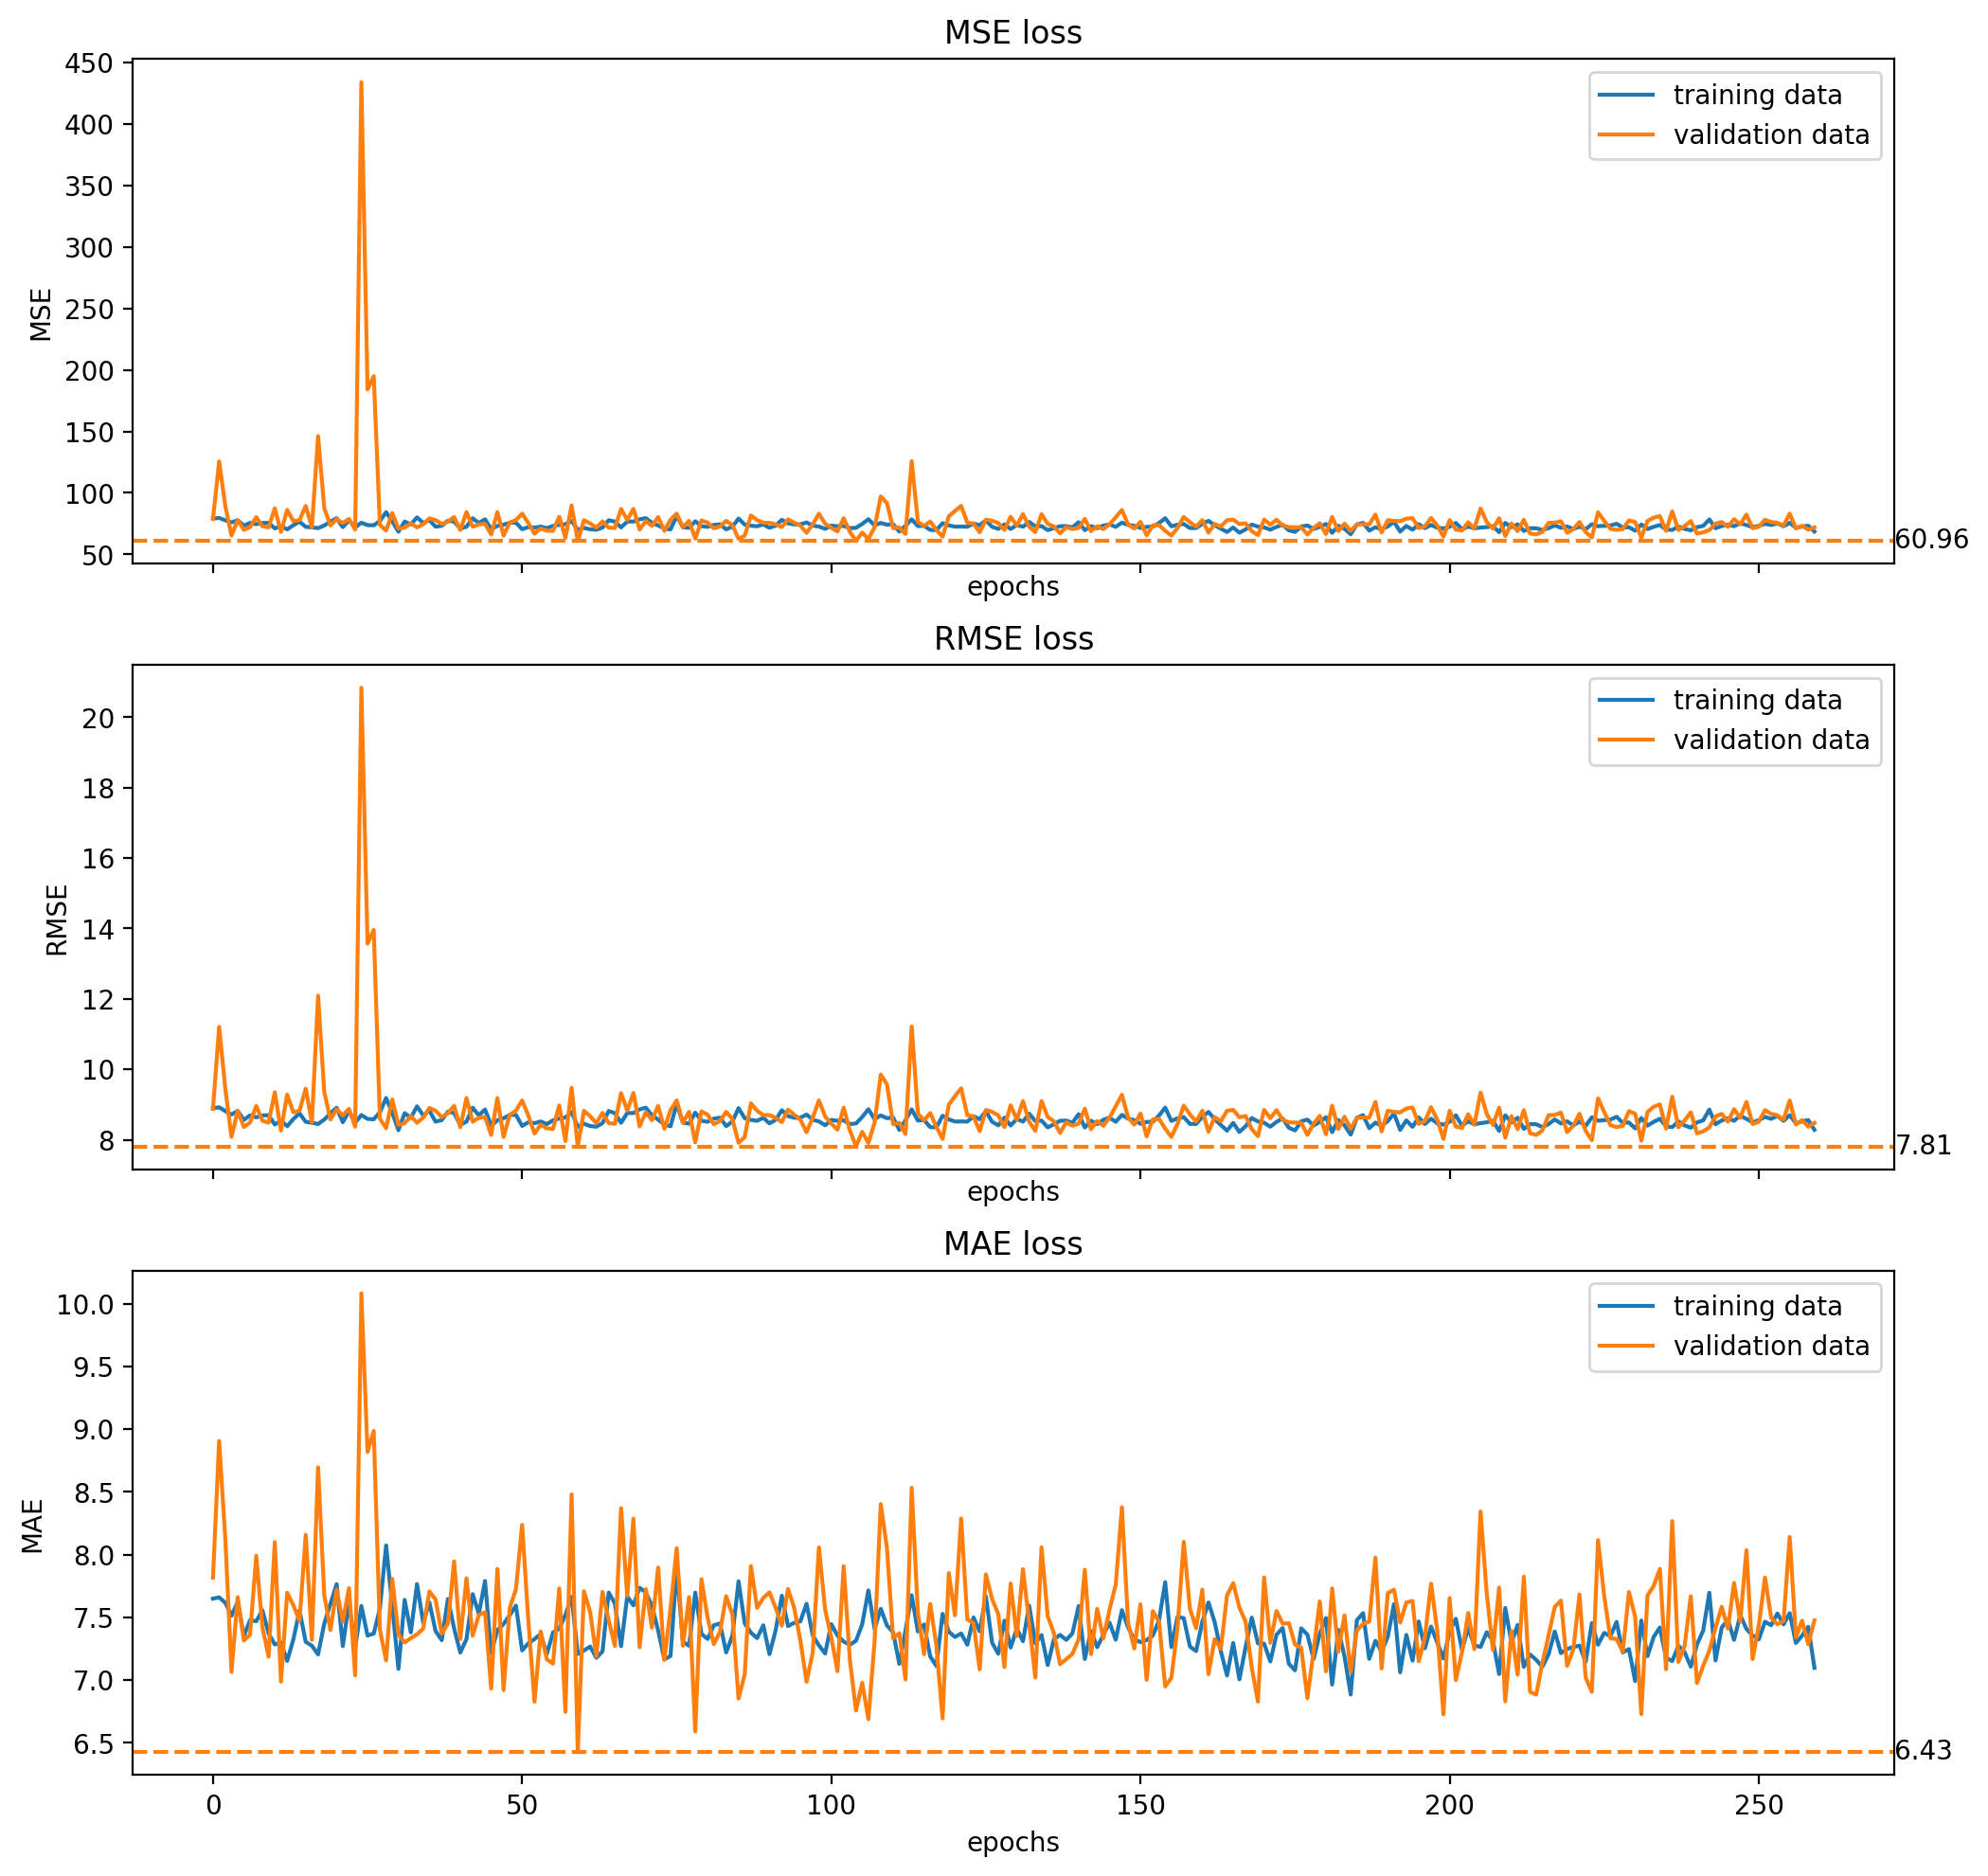

In [31]:
plot_loss(history)

### Model 2 - CNN

In [32]:
def cnn_model():
    model = keras.Sequential()
    model.add(Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(n_outputs))
    
    return model

In [33]:
model = cnn_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build((n_timesteps, n_features))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_4 (Batch (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 241, 48)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_5 (Batch (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 232, 64)          

In [34]:
output_filename = 'CNN_EEG_classifier01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.0001, verbose=1)

In [35]:
epochs = 1500

# fit network
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])


Epoch 1/1500
76/76 [==============================] - 65s 844ms/step - loss: 333.7115 - root_mean_squared_error: 17.8609 - mean_absolute_error: 13.7673 - val_loss: 199.5438 - val_root_mean_squared_error: 14.1260 - val_mean_absolute_error: 10.5217

Epoch 00001: val_loss improved from inf to 199.54378, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier01.hdf5
Epoch 2/1500
76/76 [==============================] - 63s 830ms/step - loss: 133.2197 - root_mean_squared_error: 11.5383 - mean_absolute_error: 9.3915 - val_loss: 171.6031 - val_root_mean_squared_error: 13.0997 - val_mean_absolute_error: 10.5954

Epoch 00002: val_loss improved from 199.54378 to 171.60312, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier01.hdf5
Epoch 3/1500
76/76 [==============================] - 64s 842ms/step - loss: 113.8666 - root_mean_squared_error: 10.6669 - mean_absolute_error: 8.7320 - val_loss: 179.5995 - val_r

76/76 [==============================] - 62s 818ms/step - loss: 60.6823 - root_mean_squared_error: 7.7870 - mean_absolute_error: 6.4217 - val_loss: 127.9690 - val_root_mean_squared_error: 11.3123 - val_mean_absolute_error: 8.9336

Epoch 00027: val_loss did not improve from 76.15847
Epoch 28/1500
76/76 [==============================] - 61s 808ms/step - loss: 64.7613 - root_mean_squared_error: 8.0466 - mean_absolute_error: 6.5291 - val_loss: 144.0091 - val_root_mean_squared_error: 12.0004 - val_mean_absolute_error: 9.7618

Epoch 00028: val_loss did not improve from 76.15847
Epoch 29/1500
76/76 [==============================] - 64s 847ms/step - loss: 72.4101 - root_mean_squared_error: 8.4998 - mean_absolute_error: 7.0503 - val_loss: 160.8501 - val_root_mean_squared_error: 12.6827 - val_mean_absolute_error: 10.4296

Epoch 00029: val_loss did not improve from 76.15847
Epoch 30/1500
76/76 [==============================] - 64s 832ms/step - loss: 73.5714 - root_mean_squared_error: 8.5738 - 


Epoch 00054: val_loss did not improve from 76.15847
Epoch 55/1500
76/76 [==============================] - 62s 820ms/step - loss: 55.2965 - root_mean_squared_error: 7.4333 - mean_absolute_error: 6.1683 - val_loss: 87.7735 - val_root_mean_squared_error: 9.3687 - val_mean_absolute_error: 7.5193

Epoch 00055: val_loss did not improve from 76.15847
Epoch 56/1500
76/76 [==============================] - 64s 844ms/step - loss: 54.2298 - root_mean_squared_error: 7.3596 - mean_absolute_error: 6.0294 - val_loss: 176.3114 - val_root_mean_squared_error: 13.2782 - val_mean_absolute_error: 11.0395

Epoch 00056: val_loss did not improve from 76.15847
Epoch 57/1500
76/76 [==============================] - 62s 808ms/step - loss: 57.7877 - root_mean_squared_error: 7.5988 - mean_absolute_error: 6.2399 - val_loss: 180.8816 - val_root_mean_squared_error: 13.4492 - val_mean_absolute_error: 11.4684

Epoch 00057: val_loss did not improve from 76.15847
Epoch 58/1500
76/76 [==============================] - 6


Epoch 00109: val_loss did not improve from 76.15847
Epoch 110/1500
76/76 [==============================] - 64s 842ms/step - loss: 44.7217 - root_mean_squared_error: 6.6827 - mean_absolute_error: 5.4771 - val_loss: 123.2744 - val_root_mean_squared_error: 11.1029 - val_mean_absolute_error: 8.9823

Epoch 00110: val_loss did not improve from 76.15847
Epoch 111/1500
76/76 [==============================] - 63s 824ms/step - loss: 46.0364 - root_mean_squared_error: 6.7824 - mean_absolute_error: 5.5467 - val_loss: 168.2331 - val_root_mean_squared_error: 12.9705 - val_mean_absolute_error: 10.4609

Epoch 00111: val_loss did not improve from 76.15847
Epoch 112/1500
76/76 [==============================] - 63s 827ms/step - loss: 40.5839 - root_mean_squared_error: 6.3536 - mean_absolute_error: 5.0464 - val_loss: 162.6161 - val_root_mean_squared_error: 12.7521 - val_mean_absolute_error: 10.5664

Epoch 00112: val_loss did not improve from 76.15847
Epoch 113/1500
76/76 [=============================


Epoch 00164: val_loss did not improve from 76.15847
Epoch 165/1500
76/76 [==============================] - 63s 827ms/step - loss: 46.9316 - root_mean_squared_error: 6.8478 - mean_absolute_error: 5.5047 - val_loss: 164.1082 - val_root_mean_squared_error: 12.8105 - val_mean_absolute_error: 10.5258

Epoch 00165: val_loss did not improve from 76.15847
Epoch 166/1500
76/76 [==============================] - 64s 847ms/step - loss: 41.9013 - root_mean_squared_error: 6.4661 - mean_absolute_error: 5.2811 - val_loss: 131.4035 - val_root_mean_squared_error: 11.4631 - val_mean_absolute_error: 9.2689

Epoch 00166: val_loss did not improve from 76.15847
Epoch 167/1500
76/76 [==============================] - 64s 851ms/step - loss: 43.5768 - root_mean_squared_error: 6.5940 - mean_absolute_error: 5.4110 - val_loss: 120.8197 - val_root_mean_squared_error: 10.9918 - val_mean_absolute_error: 8.9899

Epoch 00167: val_loss did not improve from 76.15847
Epoch 168/1500
76/76 [==============================

In [36]:
evaluate_model(model)

6/6 [==============================] - 0s 9ms/step - loss: 139.1031 - root_mean_squared_error: 11.7942 - mean_absolute_error: 9.5767


In [37]:
print_few_predictions(model)

[[22.16428 ]
 [19.6562  ]
 [15.74858 ]
 [14.38707 ]
 [18.121677]
 [19.603182]
 [20.901024]
 [18.367317]
 [15.803496]
 [20.516882]
 [22.238604]]
[[41.]
 [23.]
 [17.]
 [17.]
 [29.]
 [35.]
 [17.]
 [29.]
 [23.]
 [41.]
 [29.]]


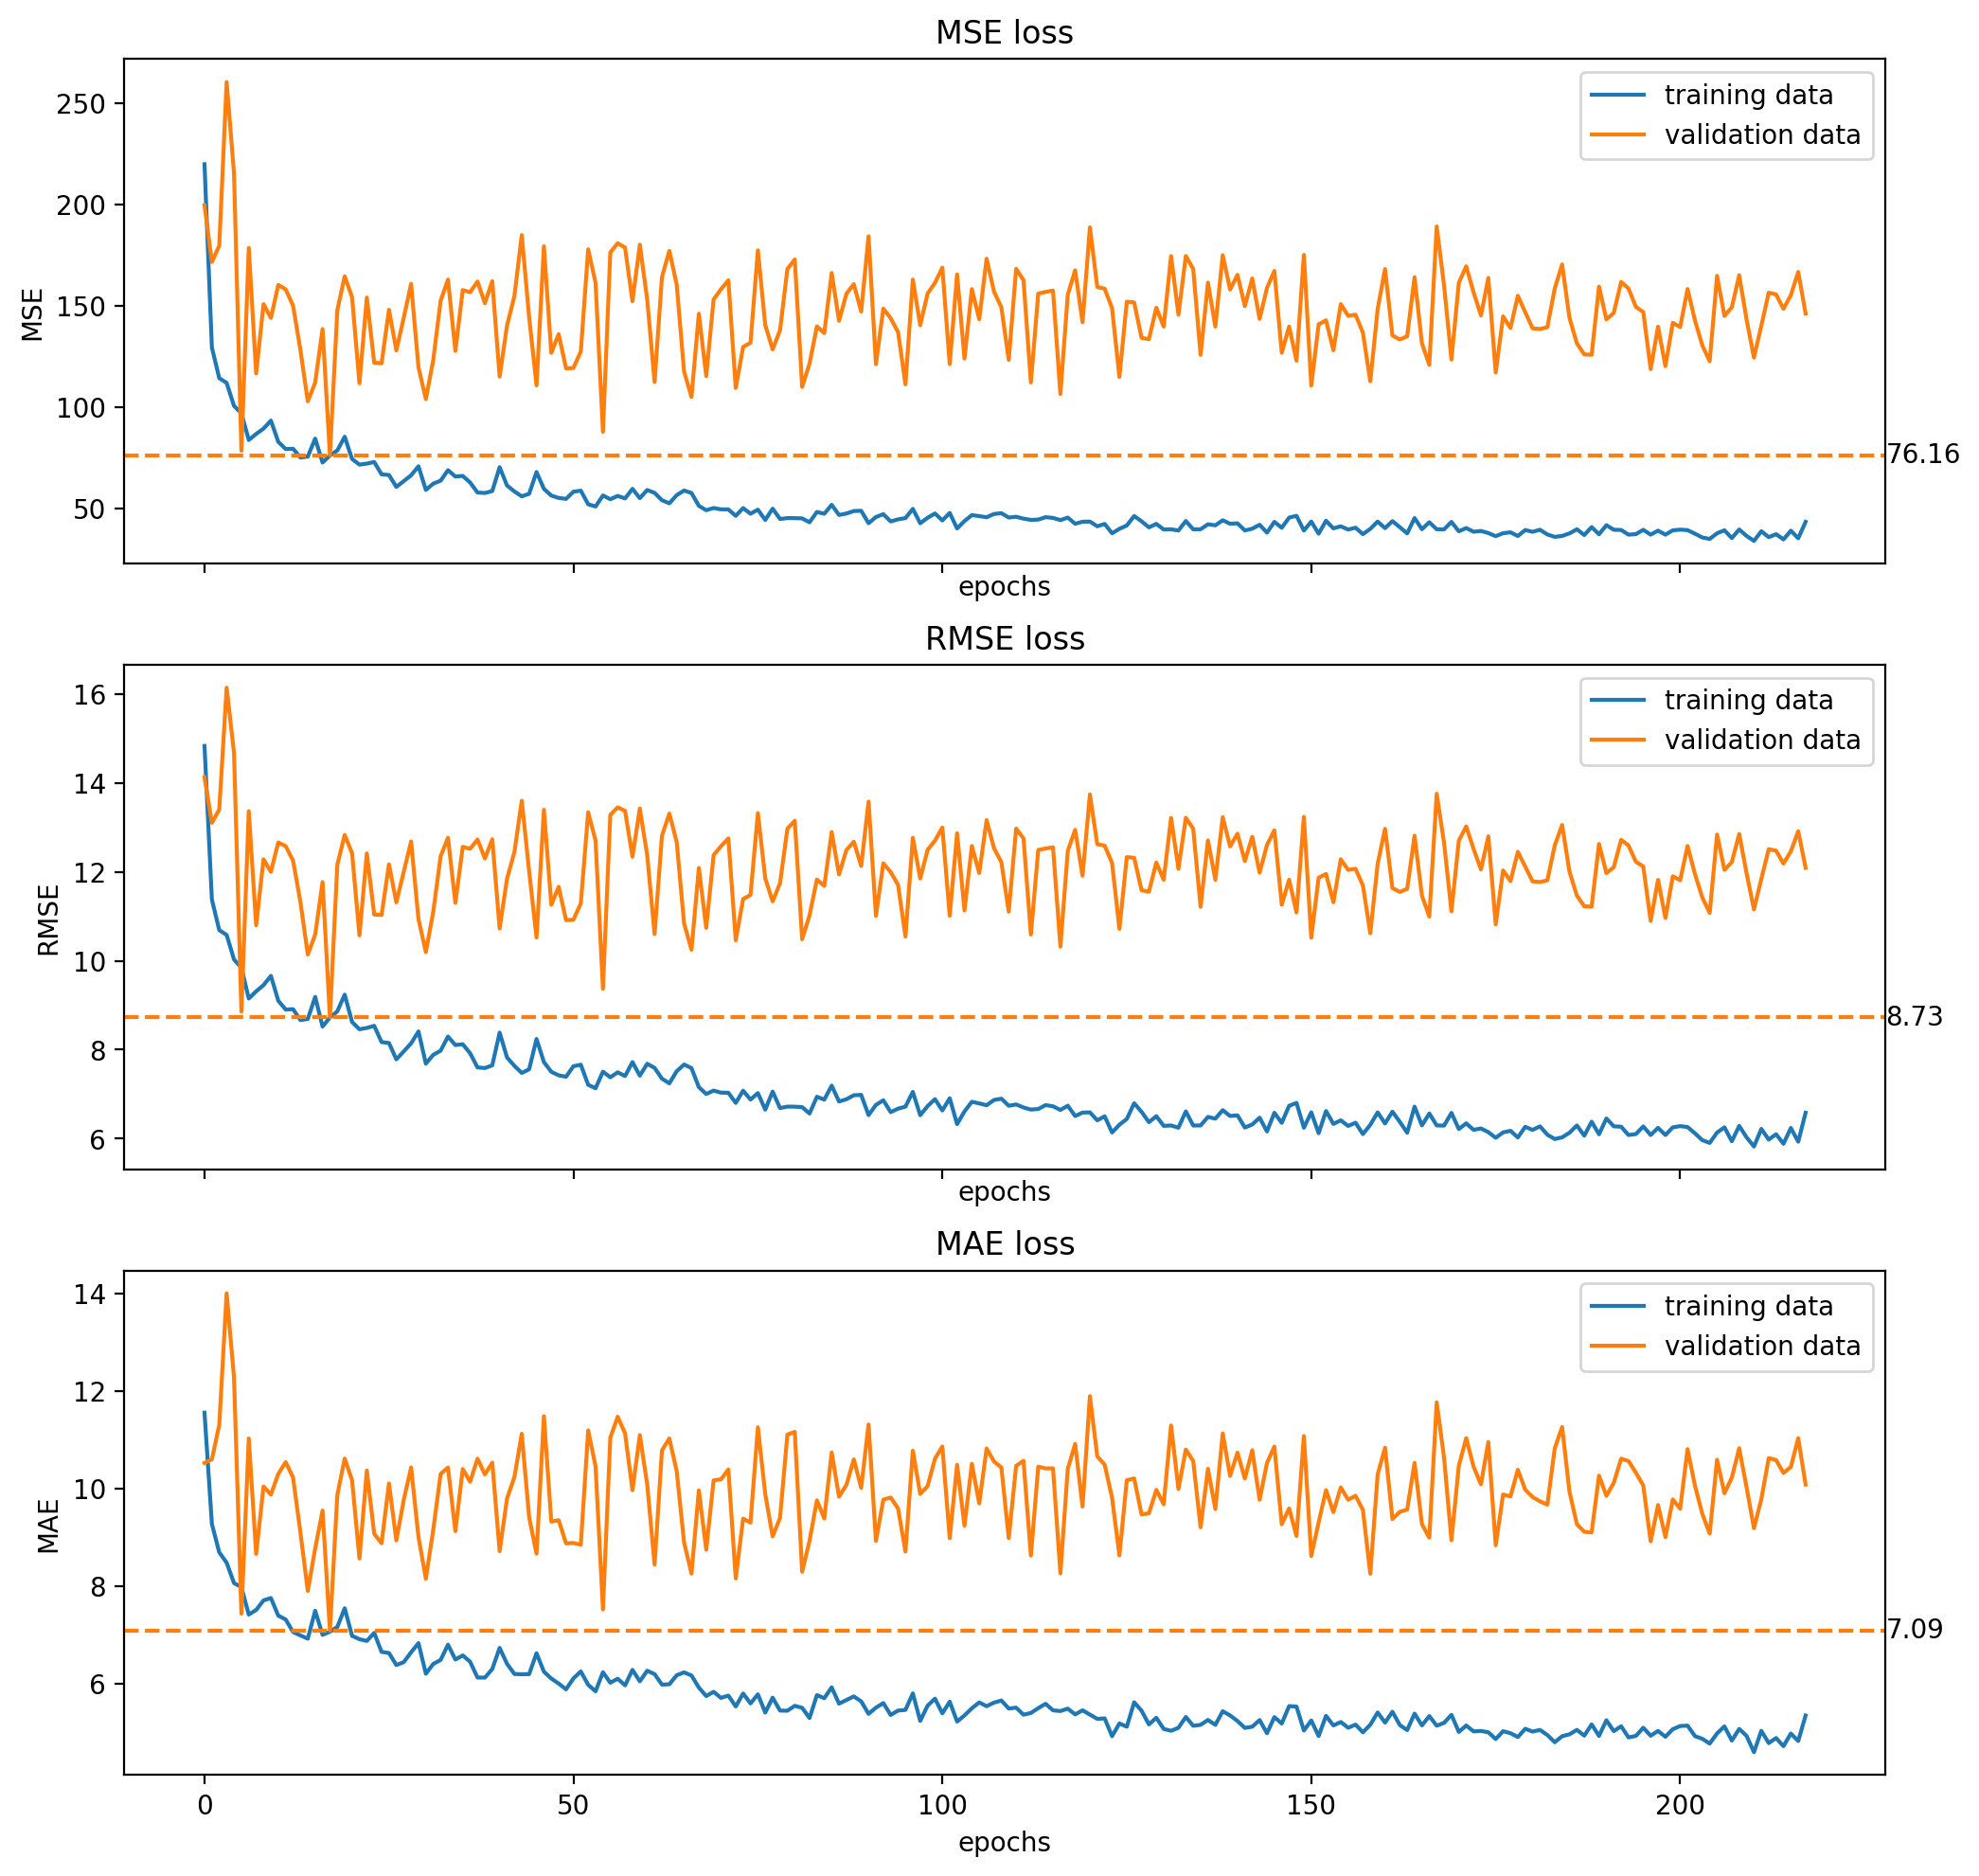

In [38]:
plot_loss(history)

### Model 2a - CNN - Add another dropout, gaussian noise

In [26]:
def cnn_model_2a():
    model = keras.Sequential()
    model.add(Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(60, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_outputs))
    
    return model

In [27]:
model = cnn_model_2a()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build((n_timesteps, n_features))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_3 (Batch (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 241, 48)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_4 (Batch (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 232, 64)          

In [28]:
output_filename = 'CNN_EEG_classifier01a'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)

In [29]:
epochs = 1500

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])


Epoch 1/1500
76/76 [==============================] - 111s 1s/step - loss: 614.9384 - root_mean_squared_error: 24.3759 - mean_absolute_error: 18.6282 - val_loss: 971.6713 - val_root_mean_squared_error: 31.1716 - val_mean_absolute_error: 22.2951

Epoch 00001: val_loss improved from inf to 971.67126, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier01a.hdf5
Epoch 2/1500
76/76 [==============================] - 85s 1s/step - loss: 200.2729 - root_mean_squared_error: 14.1459 - mean_absolute_error: 11.0125 - val_loss: 182.6873 - val_root_mean_squared_error: 13.5162 - val_mean_absolute_error: 11.0195

Epoch 00002: val_loss improved from 971.67126 to 182.68730, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier01a.hdf5
Epoch 3/1500
76/76 [==============================] - 88s 1s/step - loss: 153.3395 - root_mean_squared_error: 12.3775 - mean_absolute_error: 10.0842 - val_loss: 307.0082 - val_root_

76/76 [==============================] - 64s 841ms/step - loss: 63.3402 - root_mean_squared_error: 7.9475 - mean_absolute_error: 6.5623 - val_loss: 95.8406 - val_root_mean_squared_error: 9.7898 - val_mean_absolute_error: 8.1023

Epoch 00053: val_loss did not improve from 64.06893
Epoch 54/1500
76/76 [==============================] - 64s 844ms/step - loss: 63.1078 - root_mean_squared_error: 7.9430 - mean_absolute_error: 6.5920 - val_loss: 82.7636 - val_root_mean_squared_error: 9.0975 - val_mean_absolute_error: 7.4263

Epoch 00054: val_loss did not improve from 64.06893
Epoch 55/1500
76/76 [==============================] - 63s 834ms/step - loss: 56.1414 - root_mean_squared_error: 7.4907 - mean_absolute_error: 6.2194 - val_loss: 81.5044 - val_root_mean_squared_error: 9.0280 - val_mean_absolute_error: 7.2878

Epoch 00055: val_loss did not improve from 64.06893
Epoch 56/1500
76/76 [==============================] - 63s 828ms/step - loss: 60.8343 - root_mean_squared_error: 7.7947 - mean_ab


Epoch 00080: val_loss did not improve from 64.06893
Epoch 81/1500
76/76 [==============================] - 63s 835ms/step - loss: 52.6322 - root_mean_squared_error: 7.2523 - mean_absolute_error: 6.0557 - val_loss: 77.0082 - val_root_mean_squared_error: 8.7754 - val_mean_absolute_error: 7.1452

Epoch 00081: val_loss did not improve from 64.06893
Epoch 82/1500
76/76 [==============================] - 63s 834ms/step - loss: 66.2093 - root_mean_squared_error: 8.1243 - mean_absolute_error: 6.7845 - val_loss: 84.8858 - val_root_mean_squared_error: 9.2134 - val_mean_absolute_error: 7.7946

Epoch 00082: val_loss did not improve from 64.06893
Epoch 83/1500
76/76 [==============================] - 66s 865ms/step - loss: 66.4594 - root_mean_squared_error: 8.1465 - mean_absolute_error: 6.8332 - val_loss: 79.7443 - val_root_mean_squared_error: 8.9300 - val_mean_absolute_error: 7.1332

Epoch 00083: val_loss did not improve from 64.06893
Epoch 84/1500
76/76 [==============================] - 64s 839

In [30]:
evaluate_model(model)

6/6 [==============================] - 0s 10ms/step - loss: 83.7149 - root_mean_squared_error: 9.1496 - mean_absolute_error: 7.3292


In [31]:
print_few_predictions(model)

[[23.449198]
 [21.524052]
 [21.723389]
 [26.814491]
 [23.54386 ]
 [24.628199]
 [24.766472]
 [22.150173]
 [26.620144]
 [22.720104]
 [26.239405]]
[[29.]
 [17.]
 [23.]
 [41.]
 [17.]
 [29.]
 [41.]
 [23.]
 [29.]
 [17.]
 [35.]]


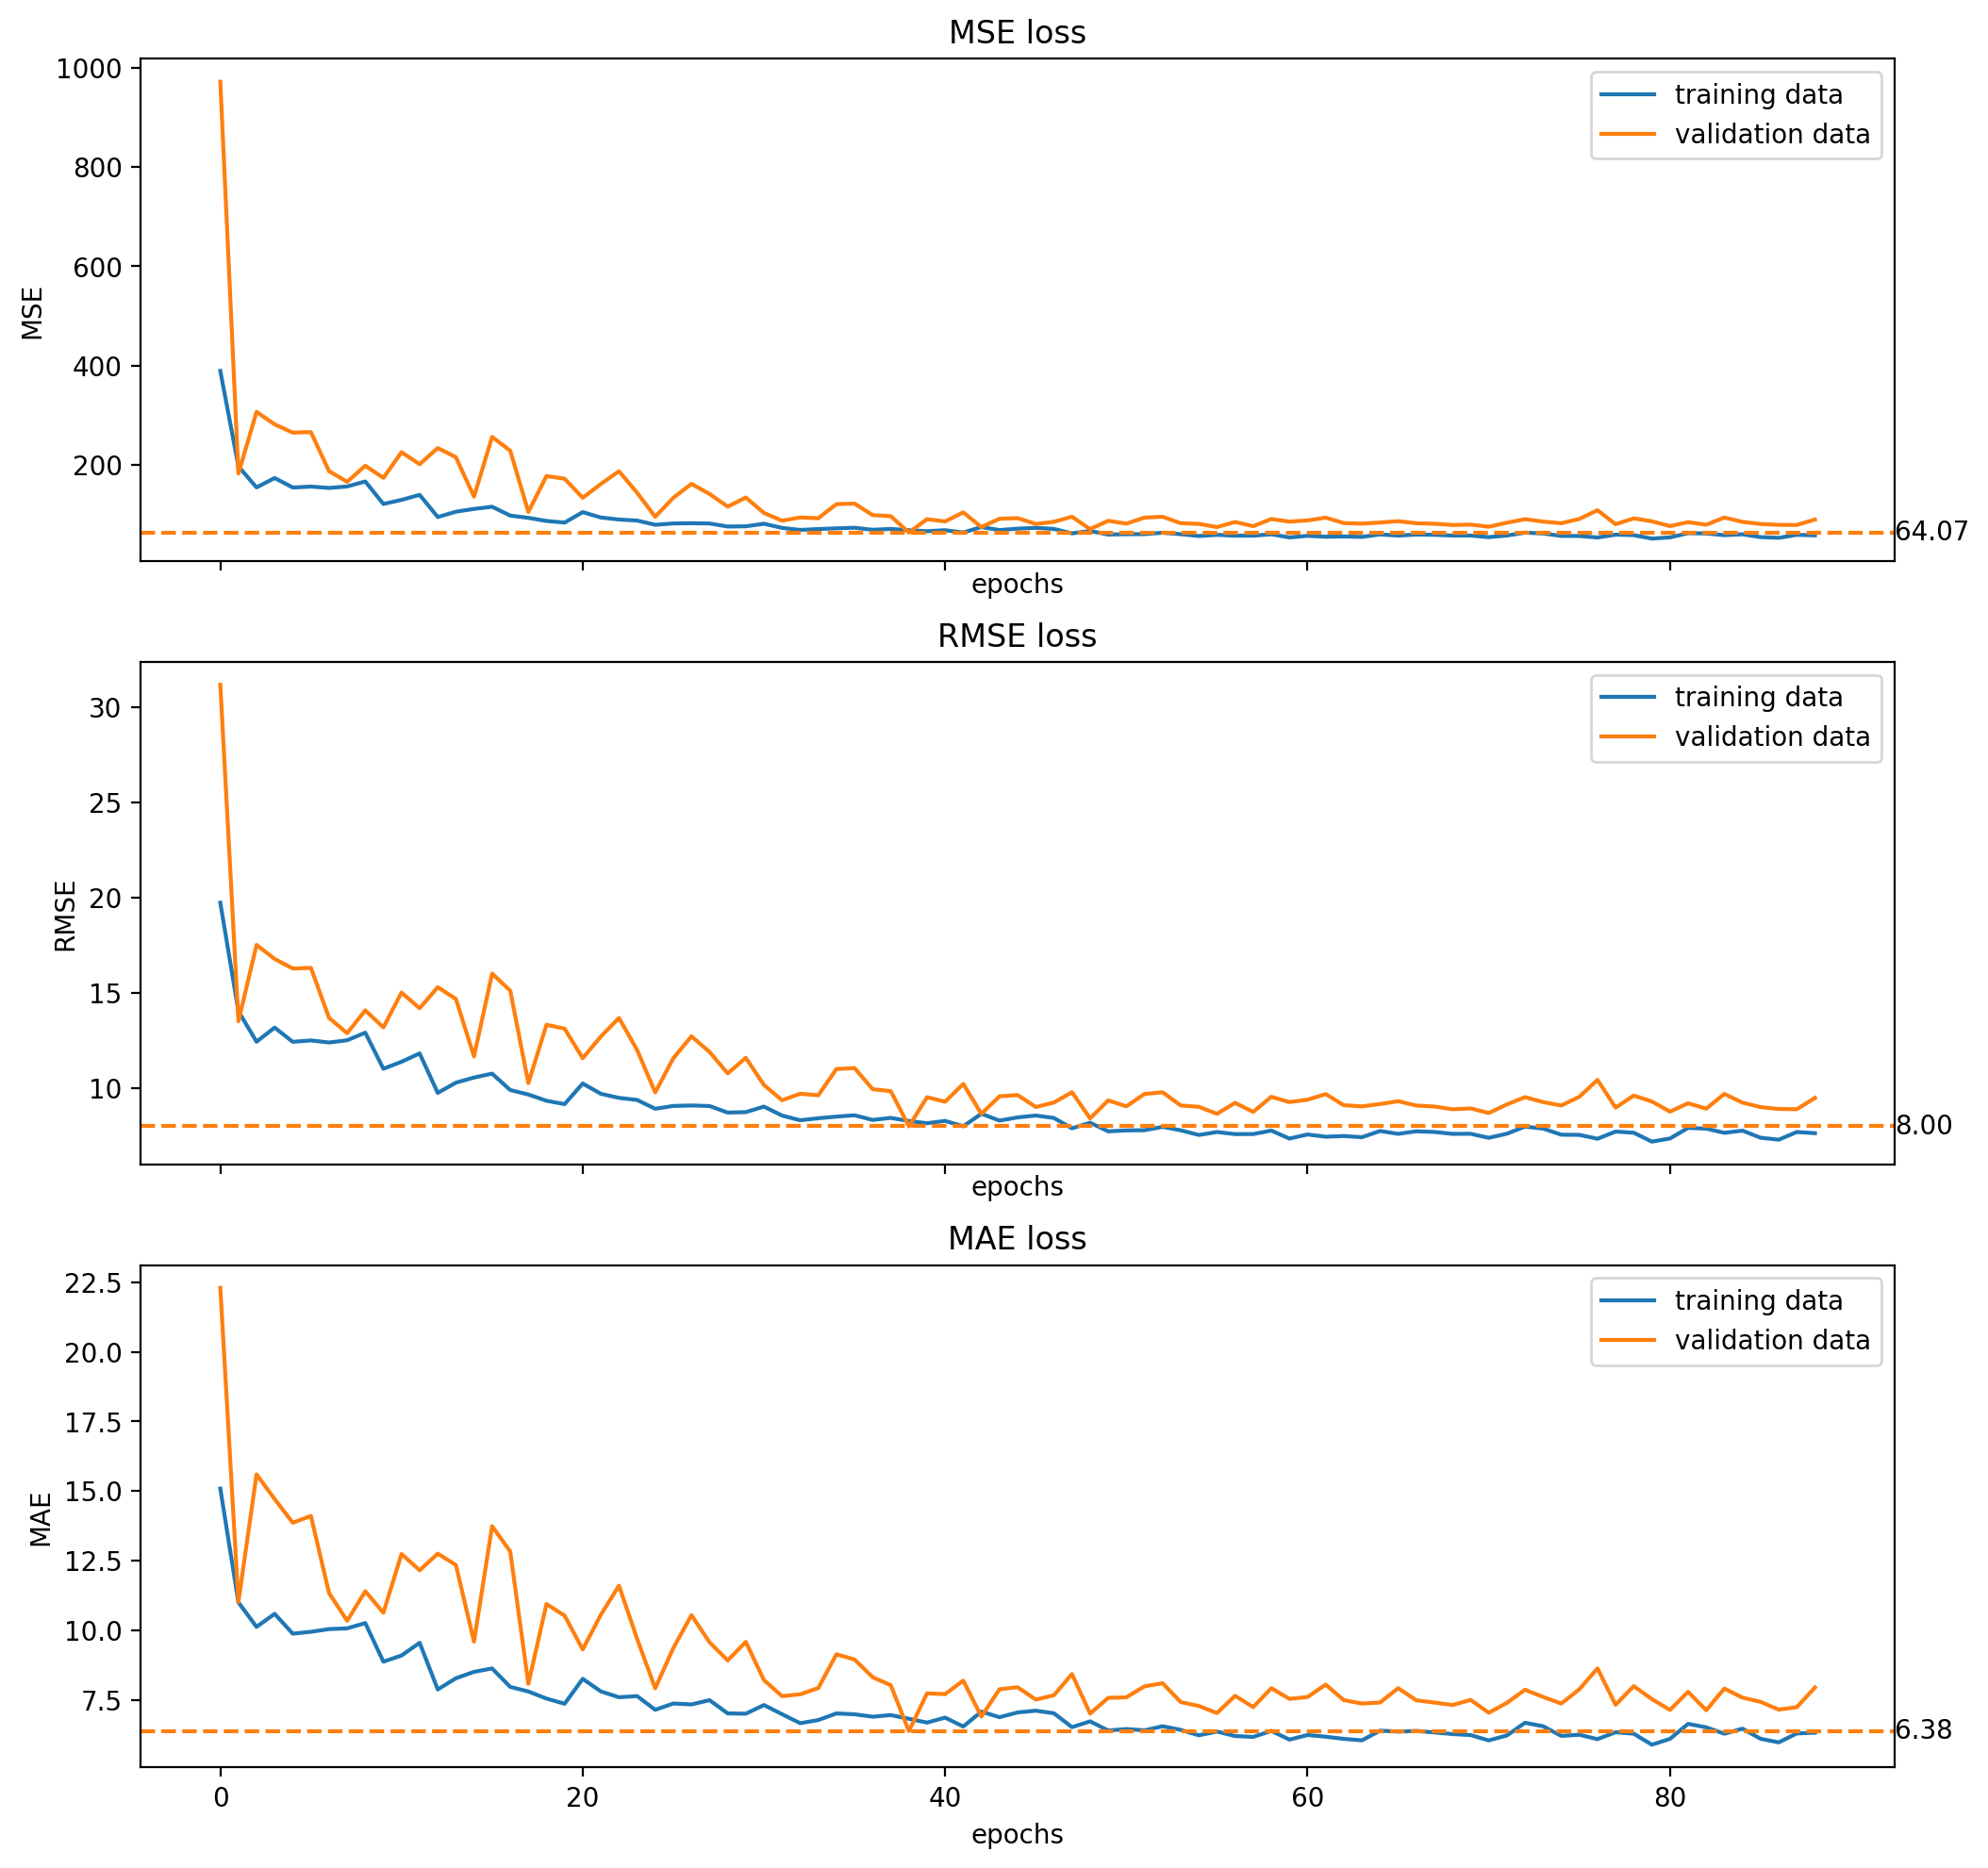

In [32]:
plot_loss(history)

### Model 3 - CNN and RNN (LSTM) combined

In [39]:
def cnn_lstm_model():

    model = keras.Sequential()
    model.add(Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Reshape((-1, 96)))

    model.add(Bidirectional(LSTM(96, return_sequences=True), input_shape=input_shape, merge_mode='ave'))
    model.add(Dropout(.2))
    model.add(BatchNormalization())
    model.add(LSTM(48))
    model.add(BatchNormalization())
    model.add(Dense(32))
    model.add(Dense(n_outputs))

    return model

In [40]:
model = cnn_lstm_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build((n_timesteps, n_features))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_7 (Batch (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 241, 48)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_8 (Batch (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 232, 64)          

In [41]:
output_filename = 'COMBINED_EEG_classifier01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.0001, verbose=1)

In [42]:
epochs = 1500

# fit network
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
76/76 [==============================] - 69s 853ms/step - loss: 547.8691 - root_mean_squared_error: 23.0405 - mean_absolute_error: 20.3027 - val_loss: 81.0092 - val_root_mean_squared_error: 9.0005 - val_mean_absolute_error: 7.4926

Epoch 00001: val_loss improved from inf to 81.00921, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/COMBINED_EEG_classifier01.hdf5
Epoch 2/1500
76/76 [==============================] - 65s 856ms/step - loss: 79.3796 - root_mean_squared_error: 8.8961 - mean_absolute_error: 7.5147 - val_loss: 69.9890 - val_root_mean_squared_error: 8.3659 - val_mean_absolute_error: 7.1115

Epoch 00002: val_loss improved from 81.00921 to 69.98897, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/COMBINED_EEG_classifier01.hdf5
Epoch 3/1500
76/76 [==============================] - 62s 821ms/step - loss: 78.6568 - root_mean_squared_error: 8.8664 - mean_absolute_error: 7.3724 - val_loss: 88.1516 - val_root_


Epoch 00054: val_loss did not improve from 65.12141
Epoch 55/1500
76/76 [==============================] - 65s 857ms/step - loss: 71.4464 - root_mean_squared_error: 8.4517 - mean_absolute_error: 7.3711 - val_loss: 73.9025 - val_root_mean_squared_error: 8.5967 - val_mean_absolute_error: 7.5365

Epoch 00055: val_loss did not improve from 65.12141
Epoch 56/1500
76/76 [==============================] - 65s 851ms/step - loss: 75.3886 - root_mean_squared_error: 8.6778 - mean_absolute_error: 7.5358 - val_loss: 63.6908 - val_root_mean_squared_error: 7.9807 - val_mean_absolute_error: 6.8670

Epoch 00056: val_loss improved from 65.12141 to 63.69081, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/COMBINED_EEG_classifier01.hdf5
Epoch 57/1500
76/76 [==============================] - 64s 842ms/step - loss: 71.8943 - root_mean_squared_error: 8.4760 - mean_absolute_error: 7.3103 - val_loss: 67.0379 - val_root_mean_squared_error: 8.1877 - val_mean_absolute_error: 6.951

76/76 [==============================] - 65s 854ms/step - loss: 70.0786 - root_mean_squared_error: 8.3686 - mean_absolute_error: 7.1275 - val_loss: 68.9804 - val_root_mean_squared_error: 8.3054 - val_mean_absolute_error: 6.8759

Epoch 00081: val_loss did not improve from 59.00363
Epoch 82/1500
76/76 [==============================] - 65s 857ms/step - loss: 66.4979 - root_mean_squared_error: 8.1524 - mean_absolute_error: 6.8644 - val_loss: 66.9562 - val_root_mean_squared_error: 8.1827 - val_mean_absolute_error: 6.8351

Epoch 00082: val_loss did not improve from 59.00363
Epoch 83/1500
76/76 [==============================] - 65s 859ms/step - loss: 70.9347 - root_mean_squared_error: 8.4207 - mean_absolute_error: 7.3705 - val_loss: 73.6769 - val_root_mean_squared_error: 8.5835 - val_mean_absolute_error: 7.2054

Epoch 00083: val_loss did not improve from 59.00363
Epoch 84/1500
76/76 [==============================] - 64s 839ms/step - loss: 65.6278 - root_mean_squared_error: 8.0930 - mean_ab


Epoch 00108: val_loss did not improve from 59.00363
Epoch 109/1500
76/76 [==============================] - 64s 836ms/step - loss: 71.5824 - root_mean_squared_error: 8.4560 - mean_absolute_error: 7.3564 - val_loss: 66.7338 - val_root_mean_squared_error: 8.1691 - val_mean_absolute_error: 6.9691

Epoch 00109: val_loss did not improve from 59.00363
Epoch 110/1500
76/76 [==============================] - 67s 877ms/step - loss: 71.5830 - root_mean_squared_error: 8.4597 - mean_absolute_error: 7.4816 - val_loss: 62.2941 - val_root_mean_squared_error: 7.8927 - val_mean_absolute_error: 6.6735

Epoch 00110: val_loss did not improve from 59.00363
Epoch 111/1500
76/76 [==============================] - 63s 834ms/step - loss: 67.2151 - root_mean_squared_error: 8.1954 - mean_absolute_error: 6.9712 - val_loss: 73.8594 - val_root_mean_squared_error: 8.5941 - val_mean_absolute_error: 7.4262

Epoch 00111: val_loss did not improve from 59.00363
Epoch 112/1500
76/76 [==============================] - 63s

76/76 [==============================] - 63s 830ms/step - loss: 65.8802 - root_mean_squared_error: 8.1150 - mean_absolute_error: 6.8496 - val_loss: 79.0311 - val_root_mean_squared_error: 8.8899 - val_mean_absolute_error: 7.6189

Epoch 00163: val_loss did not improve from 52.89203
Epoch 164/1500
76/76 [==============================] - 66s 867ms/step - loss: 67.4517 - root_mean_squared_error: 8.2110 - mean_absolute_error: 7.0004 - val_loss: 82.0219 - val_root_mean_squared_error: 9.0566 - val_mean_absolute_error: 7.6305

Epoch 00164: val_loss did not improve from 52.89203
Epoch 165/1500
76/76 [==============================] - 64s 847ms/step - loss: 68.6915 - root_mean_squared_error: 8.2829 - mean_absolute_error: 7.1521 - val_loss: 74.5145 - val_root_mean_squared_error: 8.6322 - val_mean_absolute_error: 7.2351

Epoch 00165: val_loss did not improve from 52.89203
Epoch 166/1500
76/76 [==============================] - 64s 842ms/step - loss: 68.7458 - root_mean_squared_error: 8.2886 - mean


Epoch 00190: val_loss did not improve from 52.89203
Epoch 191/1500
76/76 [==============================] - 64s 846ms/step - loss: 69.5091 - root_mean_squared_error: 8.3356 - mean_absolute_error: 7.3004 - val_loss: 69.5849 - val_root_mean_squared_error: 8.3418 - val_mean_absolute_error: 7.2399

Epoch 00191: val_loss did not improve from 52.89203
Epoch 192/1500
76/76 [==============================] - 63s 832ms/step - loss: 61.9157 - root_mean_squared_error: 7.8666 - mean_absolute_error: 6.7441 - val_loss: 87.0631 - val_root_mean_squared_error: 9.3308 - val_mean_absolute_error: 7.8954

Epoch 00192: val_loss did not improve from 52.89203
Epoch 193/1500
76/76 [==============================] - 66s 867ms/step - loss: 70.0075 - root_mean_squared_error: 8.3564 - mean_absolute_error: 7.0367 - val_loss: 65.7821 - val_root_mean_squared_error: 8.1106 - val_mean_absolute_error: 6.8137

Epoch 00193: val_loss did not improve from 52.89203
Epoch 194/1500
76/76 [==============================] - 64s


Epoch 00218: val_loss did not improve from 52.89203
Epoch 219/1500
76/76 [==============================] - 64s 847ms/step - loss: 63.7944 - root_mean_squared_error: 7.9758 - mean_absolute_error: 6.7925 - val_loss: 71.7549 - val_root_mean_squared_error: 8.4708 - val_mean_absolute_error: 7.1768

Epoch 00219: val_loss did not improve from 52.89203
Epoch 220/1500
76/76 [==============================] - 63s 824ms/step - loss: 66.8396 - root_mean_squared_error: 8.1734 - mean_absolute_error: 7.0137 - val_loss: 63.5312 - val_root_mean_squared_error: 7.9706 - val_mean_absolute_error: 6.8396

Epoch 00220: val_loss did not improve from 52.89203
Epoch 221/1500
76/76 [==============================] - 63s 831ms/step - loss: 62.3334 - root_mean_squared_error: 7.8904 - mean_absolute_error: 6.6518 - val_loss: 54.4594 - val_root_mean_squared_error: 7.3797 - val_mean_absolute_error: 6.2075

Epoch 00221: val_loss did not improve from 52.89203
Epoch 222/1500
76/76 [==============================] - 64s


Epoch 00246: val_loss did not improve from 52.89203
Epoch 247/1500
76/76 [==============================] - 63s 830ms/step - loss: 68.8401 - root_mean_squared_error: 8.2954 - mean_absolute_error: 7.1571 - val_loss: 61.2264 - val_root_mean_squared_error: 7.8247 - val_mean_absolute_error: 6.6469

Epoch 00247: val_loss did not improve from 52.89203
Epoch 248/1500
76/76 [==============================] - 63s 825ms/step - loss: 67.7899 - root_mean_squared_error: 8.2300 - mean_absolute_error: 7.1468 - val_loss: 71.3928 - val_root_mean_squared_error: 8.4494 - val_mean_absolute_error: 6.9831

Epoch 00248: val_loss did not improve from 52.89203
Epoch 249/1500
76/76 [==============================] - 65s 856ms/step - loss: 64.5288 - root_mean_squared_error: 8.0267 - mean_absolute_error: 6.7513 - val_loss: 66.3704 - val_root_mean_squared_error: 8.1468 - val_mean_absolute_error: 7.0031

Epoch 00249: val_loss did not improve from 52.89203
Epoch 250/1500
76/76 [==============================] - 65s


Epoch 00274: val_loss did not improve from 52.89203
Epoch 275/1500
76/76 [==============================] - 64s 845ms/step - loss: 64.9657 - root_mean_squared_error: 8.0592 - mean_absolute_error: 6.8661 - val_loss: 62.1292 - val_root_mean_squared_error: 7.8822 - val_mean_absolute_error: 6.5696

Epoch 00275: val_loss did not improve from 52.89203
Epoch 276/1500
76/76 [==============================] - 64s 846ms/step - loss: 59.4892 - root_mean_squared_error: 7.7063 - mean_absolute_error: 6.6263 - val_loss: 57.3541 - val_root_mean_squared_error: 7.5733 - val_mean_absolute_error: 6.3975

Epoch 00276: val_loss did not improve from 52.89203
Epoch 277/1500
76/76 [==============================] - 63s 834ms/step - loss: 67.2579 - root_mean_squared_error: 8.2000 - mean_absolute_error: 7.0859 - val_loss: 56.6461 - val_root_mean_squared_error: 7.5264 - val_mean_absolute_error: 6.3530

Epoch 00277: val_loss did not improve from 52.89203
Epoch 278/1500
76/76 [==============================] - 64s


Epoch 00302: val_loss did not improve from 52.89203
Epoch 303/1500
76/76 [==============================] - 64s 841ms/step - loss: 65.7593 - root_mean_squared_error: 8.1086 - mean_absolute_error: 6.8825 - val_loss: 56.2292 - val_root_mean_squared_error: 7.4986 - val_mean_absolute_error: 6.2736

Epoch 00303: val_loss did not improve from 52.89203
Epoch 304/1500
76/76 [==============================] - 64s 840ms/step - loss: 66.3364 - root_mean_squared_error: 8.1428 - mean_absolute_error: 6.9403 - val_loss: 65.9801 - val_root_mean_squared_error: 8.1228 - val_mean_absolute_error: 6.7632

Epoch 00304: val_loss did not improve from 52.89203
Epoch 305/1500
76/76 [==============================] - 63s 835ms/step - loss: 63.5781 - root_mean_squared_error: 7.9693 - mean_absolute_error: 6.8543 - val_loss: 70.0038 - val_root_mean_squared_error: 8.3668 - val_mean_absolute_error: 7.1615

Epoch 00305: val_loss did not improve from 52.89203
Epoch 306/1500
76/76 [==============================] - 62s


Epoch 00330: val_loss did not improve from 52.89203
Epoch 331/1500
76/76 [==============================] - 65s 855ms/step - loss: 58.4877 - root_mean_squared_error: 7.6461 - mean_absolute_error: 6.5715 - val_loss: 59.3719 - val_root_mean_squared_error: 7.7053 - val_mean_absolute_error: 6.5054

Epoch 00331: val_loss did not improve from 52.89203
Epoch 332/1500
76/76 [==============================] - 67s 888ms/step - loss: 59.6579 - root_mean_squared_error: 7.7197 - mean_absolute_error: 6.5756 - val_loss: 65.6086 - val_root_mean_squared_error: 8.0999 - val_mean_absolute_error: 6.9081

Epoch 00332: val_loss did not improve from 52.89203
Epoch 333/1500
76/76 [==============================] - 67s 884ms/step - loss: 57.7194 - root_mean_squared_error: 7.5934 - mean_absolute_error: 6.4758 - val_loss: 61.3140 - val_root_mean_squared_error: 7.8303 - val_mean_absolute_error: 6.6729

Epoch 00333: val_loss did not improve from 52.89203
Epoch 334/1500
76/76 [==============================] - 72s


Epoch 00385: val_loss did not improve from 52.25776
Epoch 386/1500
76/76 [==============================] - 68s 892ms/step - loss: 65.6592 - root_mean_squared_error: 8.1004 - mean_absolute_error: 7.0028 - val_loss: 53.6130 - val_root_mean_squared_error: 7.3221 - val_mean_absolute_error: 6.1329

Epoch 00386: val_loss did not improve from 52.25776
Epoch 387/1500
76/76 [==============================] - 71s 932ms/step - loss: 57.5479 - root_mean_squared_error: 7.5848 - mean_absolute_error: 6.4214 - val_loss: 59.3167 - val_root_mean_squared_error: 7.7017 - val_mean_absolute_error: 6.3619

Epoch 00387: val_loss did not improve from 52.25776
Epoch 388/1500
76/76 [==============================] - 68s 897ms/step - loss: 58.8539 - root_mean_squared_error: 7.6608 - mean_absolute_error: 6.5595 - val_loss: 68.2220 - val_root_mean_squared_error: 8.2597 - val_mean_absolute_error: 7.1369

Epoch 00388: val_loss did not improve from 52.25776
Epoch 389/1500
76/76 [==============================] - 68s


Epoch 00440: val_loss did not improve from 49.81711
Epoch 441/1500
76/76 [==============================] - 66s 873ms/step - loss: 57.4887 - root_mean_squared_error: 7.5810 - mean_absolute_error: 6.3162 - val_loss: 53.3880 - val_root_mean_squared_error: 7.3067 - val_mean_absolute_error: 6.3362

Epoch 00441: val_loss did not improve from 49.81711
Epoch 442/1500
76/76 [==============================] - 64s 842ms/step - loss: 61.6401 - root_mean_squared_error: 7.8472 - mean_absolute_error: 6.5810 - val_loss: 67.7895 - val_root_mean_squared_error: 8.2334 - val_mean_absolute_error: 7.0040

Epoch 00442: val_loss did not improve from 49.81711
Epoch 443/1500
76/76 [==============================] - 68s 899ms/step - loss: 56.0096 - root_mean_squared_error: 7.4823 - mean_absolute_error: 6.2586 - val_loss: 55.9767 - val_root_mean_squared_error: 7.4818 - val_mean_absolute_error: 6.1562

Epoch 00443: val_loss did not improve from 49.81711
Epoch 444/1500
76/76 [==============================] - 64s


Epoch 00468: val_loss did not improve from 49.81711
Epoch 469/1500
76/76 [==============================] - 64s 843ms/step - loss: 58.3905 - root_mean_squared_error: 7.6367 - mean_absolute_error: 6.4446 - val_loss: 62.7849 - val_root_mean_squared_error: 7.9237 - val_mean_absolute_error: 6.5510

Epoch 00469: val_loss did not improve from 49.81711
Epoch 470/1500
76/76 [==============================] - 63s 830ms/step - loss: 65.7785 - root_mean_squared_error: 8.1081 - mean_absolute_error: 6.9077 - val_loss: 61.9516 - val_root_mean_squared_error: 7.8709 - val_mean_absolute_error: 6.8611

Epoch 00470: val_loss did not improve from 49.81711
Epoch 471/1500
76/76 [==============================] - 64s 837ms/step - loss: 63.5422 - root_mean_squared_error: 7.9701 - mean_absolute_error: 6.7875 - val_loss: 60.8825 - val_root_mean_squared_error: 7.8027 - val_mean_absolute_error: 6.6312

Epoch 00471: val_loss did not improve from 49.81711
Epoch 472/1500
76/76 [==============================] - 64s


Epoch 00523: val_loss did not improve from 46.55013
Epoch 524/1500
76/76 [==============================] - 66s 869ms/step - loss: 67.5126 - root_mean_squared_error: 8.2146 - mean_absolute_error: 7.0506 - val_loss: 56.6187 - val_root_mean_squared_error: 7.5245 - val_mean_absolute_error: 6.2192

Epoch 00524: val_loss did not improve from 46.55013
Epoch 525/1500
76/76 [==============================] - 63s 828ms/step - loss: 55.3330 - root_mean_squared_error: 7.4337 - mean_absolute_error: 6.3268 - val_loss: 62.0552 - val_root_mean_squared_error: 7.8775 - val_mean_absolute_error: 6.7374

Epoch 00525: val_loss did not improve from 46.55013
Epoch 526/1500
76/76 [==============================] - 66s 865ms/step - loss: 61.6436 - root_mean_squared_error: 7.8492 - mean_absolute_error: 6.6259 - val_loss: 62.1552 - val_root_mean_squared_error: 7.8839 - val_mean_absolute_error: 6.5192

Epoch 00526: val_loss did not improve from 46.55013
Epoch 527/1500
76/76 [==============================] - 64s


Epoch 00551: val_loss did not improve from 46.55013
Epoch 552/1500
76/76 [==============================] - 67s 886ms/step - loss: 62.7210 - root_mean_squared_error: 7.9149 - mean_absolute_error: 6.7932 - val_loss: 72.5357 - val_root_mean_squared_error: 8.5168 - val_mean_absolute_error: 7.1231

Epoch 00552: val_loss did not improve from 46.55013
Epoch 553/1500
76/76 [==============================] - 68s 894ms/step - loss: 62.5533 - root_mean_squared_error: 7.9011 - mean_absolute_error: 6.6216 - val_loss: 70.5775 - val_root_mean_squared_error: 8.4010 - val_mean_absolute_error: 7.0559

Epoch 00553: val_loss did not improve from 46.55013
Epoch 554/1500
76/76 [==============================] - 65s 861ms/step - loss: 63.8015 - root_mean_squared_error: 7.9860 - mean_absolute_error: 6.8640 - val_loss: 65.3107 - val_root_mean_squared_error: 8.0815 - val_mean_absolute_error: 6.7118

Epoch 00554: val_loss did not improve from 46.55013
Epoch 555/1500
76/76 [==============================] - 68s


Epoch 00579: val_loss did not improve from 46.55013
Epoch 580/1500
76/76 [==============================] - 69s 906ms/step - loss: 65.3403 - root_mean_squared_error: 8.0788 - mean_absolute_error: 6.9110 - val_loss: 71.0316 - val_root_mean_squared_error: 8.4280 - val_mean_absolute_error: 7.0371

Epoch 00580: val_loss did not improve from 46.55013
Epoch 581/1500
76/76 [==============================] - 65s 848ms/step - loss: 64.4607 - root_mean_squared_error: 8.0270 - mean_absolute_error: 6.9870 - val_loss: 60.6745 - val_root_mean_squared_error: 7.7894 - val_mean_absolute_error: 6.5875

Epoch 00581: val_loss did not improve from 46.55013
Epoch 582/1500
76/76 [==============================] - 70s 929ms/step - loss: 58.4581 - root_mean_squared_error: 7.6389 - mean_absolute_error: 6.3771 - val_loss: 71.0032 - val_root_mean_squared_error: 8.4263 - val_mean_absolute_error: 7.2018

Epoch 00582: val_loss did not improve from 46.55013
Epoch 583/1500
76/76 [==============================] - 78s


Epoch 00607: val_loss did not improve from 46.55013
Epoch 608/1500
76/76 [==============================] - 65s 853ms/step - loss: 64.7229 - root_mean_squared_error: 8.0414 - mean_absolute_error: 6.8465 - val_loss: 67.2369 - val_root_mean_squared_error: 8.1998 - val_mean_absolute_error: 6.9792

Epoch 00608: val_loss did not improve from 46.55013
Epoch 609/1500
76/76 [==============================] - 65s 851ms/step - loss: 61.6398 - root_mean_squared_error: 7.8461 - mean_absolute_error: 6.7670 - val_loss: 59.1509 - val_root_mean_squared_error: 7.6910 - val_mean_absolute_error: 6.4923

Epoch 00609: val_loss did not improve from 46.55013
Epoch 610/1500
76/76 [==============================] - 63s 824ms/step - loss: 61.0751 - root_mean_squared_error: 7.8134 - mean_absolute_error: 6.6120 - val_loss: 70.4247 - val_root_mean_squared_error: 8.3919 - val_mean_absolute_error: 7.1897

Epoch 00610: val_loss did not improve from 46.55013
Epoch 611/1500
76/76 [==============================] - 64s


Epoch 00635: val_loss did not improve from 46.55013
Epoch 636/1500
76/76 [==============================] - 64s 840ms/step - loss: 59.7338 - root_mean_squared_error: 7.7272 - mean_absolute_error: 6.5191 - val_loss: 60.5048 - val_root_mean_squared_error: 7.7785 - val_mean_absolute_error: 6.7027

Epoch 00636: val_loss did not improve from 46.55013
Epoch 637/1500
76/76 [==============================] - 64s 846ms/step - loss: 62.3794 - root_mean_squared_error: 7.8955 - mean_absolute_error: 6.6843 - val_loss: 70.3618 - val_root_mean_squared_error: 8.3882 - val_mean_absolute_error: 7.0527

Epoch 00637: val_loss did not improve from 46.55013
Epoch 638/1500
76/76 [==============================] - 62s 812ms/step - loss: 62.6357 - root_mean_squared_error: 7.9124 - mean_absolute_error: 6.8338 - val_loss: 65.8949 - val_root_mean_squared_error: 8.1176 - val_mean_absolute_error: 7.0338

Epoch 00638: val_loss did not improve from 46.55013
Epoch 639/1500
76/76 [==============================] - 65s


Epoch 00663: val_loss did not improve from 46.55013
Epoch 664/1500
76/76 [==============================] - 66s 865ms/step - loss: 63.0009 - root_mean_squared_error: 7.9352 - mean_absolute_error: 6.7131 - val_loss: 74.1803 - val_root_mean_squared_error: 8.6128 - val_mean_absolute_error: 7.1916

Epoch 00664: val_loss did not improve from 46.55013
Epoch 665/1500
76/76 [==============================] - 63s 827ms/step - loss: 61.2594 - root_mean_squared_error: 7.8220 - mean_absolute_error: 6.6451 - val_loss: 63.3065 - val_root_mean_squared_error: 7.9565 - val_mean_absolute_error: 6.5847

Epoch 00665: val_loss did not improve from 46.55013
Epoch 666/1500
76/76 [==============================] - 66s 875ms/step - loss: 64.8537 - root_mean_squared_error: 8.0486 - mean_absolute_error: 6.8160 - val_loss: 54.5010 - val_root_mean_squared_error: 7.3825 - val_mean_absolute_error: 6.2705

Epoch 00666: val_loss did not improve from 46.55013
Epoch 667/1500
76/76 [==============================] - 65s

In [43]:
evaluate_model(model)

6/6 [==============================] - 1s 23ms/step - loss: 65.7106 - root_mean_squared_error: 8.1062 - mean_absolute_error: 6.9038


In [44]:
print_few_predictions(model)

[[28.172844]
 [30.899948]
 [25.490425]
 [29.064934]
 [29.123402]
 [32.423782]
 [29.75777 ]
 [31.02856 ]
 [29.640354]
 [26.896263]
 [24.195847]]
[[41.]
 [41.]
 [35.]
 [23.]
 [29.]
 [29.]
 [17.]
 [29.]
 [17.]
 [17.]
 [23.]]


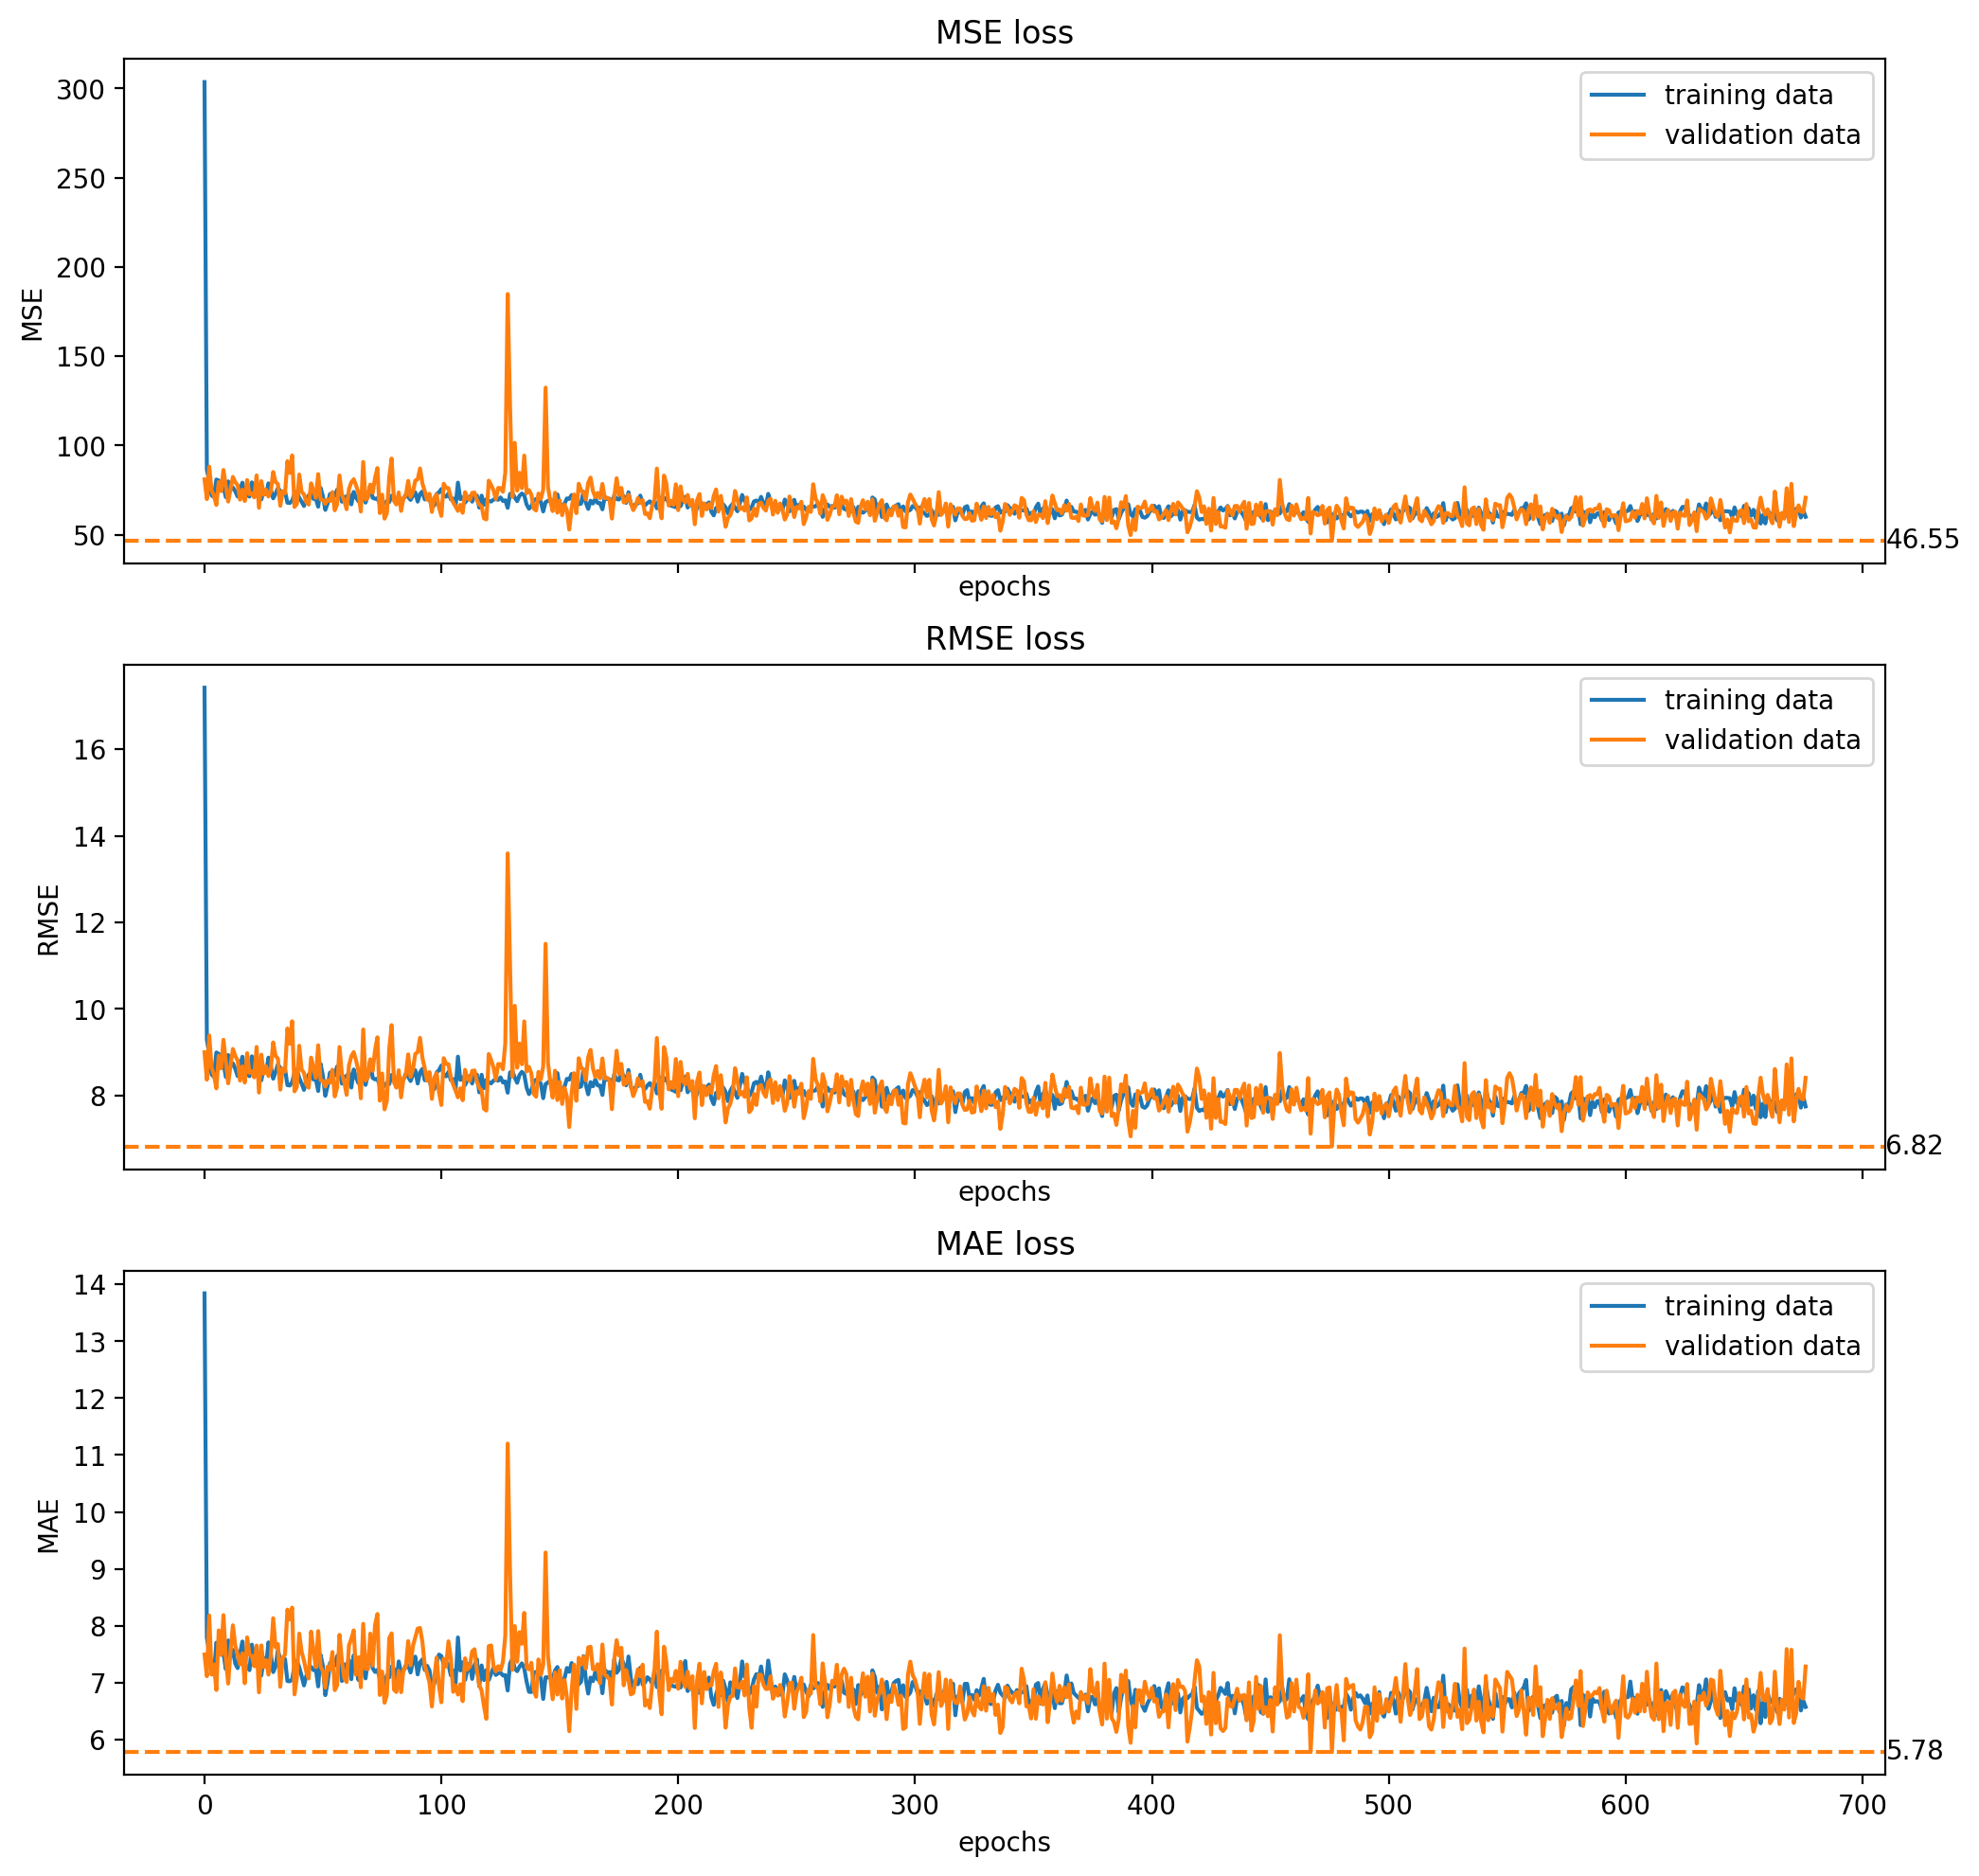

In [45]:
plot_loss(history)

#### Model 4 - Deep CNN

In [46]:
def cnn_model_2():

    model = keras.Sequential()
    model.add(Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Conv1D(filters=164, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(n_outputs))
    
    return model

In [47]:
model = cnn_model_2()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build((n_timesteps, n_features))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_12 (Batc (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d_6 (Average (None, 241, 48)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_13 (Batc (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 232, 64)          

In [48]:
output_filename = 'CNN_EEG_classifier02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.0001, verbose=1)

In [49]:
epochs = 1500

# fit network
history = model.fit(x=train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])


Epoch 1/1500
76/76 [==============================] - 66s 853ms/step - loss: 328.9673 - root_mean_squared_error: 17.5103 - mean_absolute_error: 12.7803 - val_loss: 10582.0791 - val_root_mean_squared_error: 102.8692 - val_mean_absolute_error: 87.9390

Epoch 00001: val_loss improved from inf to 10582.07910, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier02.hdf5
Epoch 2/1500
76/76 [==============================] - 63s 832ms/step - loss: 98.1777 - root_mean_squared_error: 9.8948 - mean_absolute_error: 8.1428 - val_loss: 608.5930 - val_root_mean_squared_error: 24.6697 - val_mean_absolute_error: 21.4767

Epoch 00002: val_loss improved from 10582.07910 to 608.59296, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/CNN_EEG_classifier02.hdf5
Epoch 3/1500
76/76 [==============================] - 64s 844ms/step - loss: 78.6323 - root_mean_squared_error: 8.8564 - mean_absolute_error: 7.2131 - val_loss: 294.3754 - va


Epoch 00024: val_loss did not improve from 53.99087
Epoch 25/1500
76/76 [==============================] - 61s 806ms/step - loss: 47.7021 - root_mean_squared_error: 6.9033 - mean_absolute_error: 5.6469 - val_loss: 62.1467 - val_root_mean_squared_error: 7.8833 - val_mean_absolute_error: 6.6960

Epoch 00025: val_loss did not improve from 53.99087
Epoch 26/1500
76/76 [==============================] - 62s 814ms/step - loss: 56.7079 - root_mean_squared_error: 7.5266 - mean_absolute_error: 6.1768 - val_loss: 65.0288 - val_root_mean_squared_error: 8.0640 - val_mean_absolute_error: 6.4222

Epoch 00026: val_loss did not improve from 53.99087
Epoch 27/1500
76/76 [==============================] - 63s 824ms/step - loss: 59.0358 - root_mean_squared_error: 7.6721 - mean_absolute_error: 6.2392 - val_loss: 53.7922 - val_root_mean_squared_error: 7.3343 - val_mean_absolute_error: 6.1674

Epoch 00027: val_loss improved from 53.99087 to 53.79225, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code

76/76 [==============================] - 62s 817ms/step - loss: 40.3928 - root_mean_squared_error: 6.3487 - mean_absolute_error: 5.1152 - val_loss: 57.9545 - val_root_mean_squared_error: 7.6128 - val_mean_absolute_error: 6.0713

Epoch 00078: val_loss did not improve from 44.92724
Epoch 79/1500
76/76 [==============================] - 61s 803ms/step - loss: 48.8762 - root_mean_squared_error: 6.9690 - mean_absolute_error: 5.7194 - val_loss: 57.3577 - val_root_mean_squared_error: 7.5735 - val_mean_absolute_error: 6.3634

Epoch 00079: val_loss did not improve from 44.92724
Epoch 80/1500
76/76 [==============================] - 61s 806ms/step - loss: 39.9031 - root_mean_squared_error: 6.3052 - mean_absolute_error: 5.1915 - val_loss: 64.0355 - val_root_mean_squared_error: 8.0022 - val_mean_absolute_error: 6.7530

Epoch 00080: val_loss did not improve from 44.92724
Epoch 81/1500
76/76 [==============================] - 61s 803ms/step - loss: 43.5692 - root_mean_squared_error: 6.6000 - mean_ab


Epoch 00104: val_loss did not improve from 38.48236
Epoch 105/1500
76/76 [==============================] - 64s 838ms/step - loss: 41.7777 - root_mean_squared_error: 6.4531 - mean_absolute_error: 5.3696 - val_loss: 46.4297 - val_root_mean_squared_error: 6.8139 - val_mean_absolute_error: 5.8078

Epoch 00105: val_loss did not improve from 38.48236
Epoch 106/1500
76/76 [==============================] - 65s 852ms/step - loss: 37.4844 - root_mean_squared_error: 6.1201 - mean_absolute_error: 5.0131 - val_loss: 52.0161 - val_root_mean_squared_error: 7.2122 - val_mean_absolute_error: 5.8045

Epoch 00106: val_loss did not improve from 38.48236
Epoch 107/1500
76/76 [==============================] - 65s 860ms/step - loss: 40.4364 - root_mean_squared_error: 6.3563 - mean_absolute_error: 5.0801 - val_loss: 67.5052 - val_root_mean_squared_error: 8.2162 - val_mean_absolute_error: 6.9708

Epoch 00107: val_loss did not improve from 38.48236
Epoch 108/1500
76/76 [==============================] - 63s


Epoch 00132: val_loss did not improve from 38.48236
Epoch 133/1500
76/76 [==============================] - 63s 834ms/step - loss: 41.2281 - root_mean_squared_error: 6.4171 - mean_absolute_error: 5.1467 - val_loss: 42.3776 - val_root_mean_squared_error: 6.5098 - val_mean_absolute_error: 5.1283

Epoch 00133: val_loss did not improve from 38.48236
Epoch 134/1500
76/76 [==============================] - 62s 820ms/step - loss: 41.3206 - root_mean_squared_error: 6.4148 - mean_absolute_error: 5.1831 - val_loss: 55.5772 - val_root_mean_squared_error: 7.4550 - val_mean_absolute_error: 6.3281

Epoch 00134: val_loss did not improve from 38.48236
Epoch 135/1500
76/76 [==============================] - 62s 818ms/step - loss: 42.8801 - root_mean_squared_error: 6.5455 - mean_absolute_error: 5.4007 - val_loss: 51.8617 - val_root_mean_squared_error: 7.2015 - val_mean_absolute_error: 5.9604

Epoch 00135: val_loss did not improve from 38.48236
Epoch 136/1500
76/76 [==============================] - 62s


Epoch 00187: val_loss did not improve from 37.89780
Epoch 188/1500
76/76 [==============================] - 63s 827ms/step - loss: 33.6598 - root_mean_squared_error: 5.7957 - mean_absolute_error: 4.6795 - val_loss: 49.1566 - val_root_mean_squared_error: 7.0112 - val_mean_absolute_error: 5.3548

Epoch 00188: val_loss did not improve from 37.89780
Epoch 189/1500
76/76 [==============================] - 63s 836ms/step - loss: 38.2908 - root_mean_squared_error: 6.1812 - mean_absolute_error: 5.0443 - val_loss: 47.2598 - val_root_mean_squared_error: 6.8746 - val_mean_absolute_error: 5.6371

Epoch 00189: val_loss did not improve from 37.89780
Epoch 190/1500
76/76 [==============================] - 63s 836ms/step - loss: 37.5177 - root_mean_squared_error: 6.1227 - mean_absolute_error: 5.0281 - val_loss: 49.6094 - val_root_mean_squared_error: 7.0434 - val_mean_absolute_error: 5.9656

Epoch 00190: val_loss did not improve from 37.89780
Epoch 191/1500
76/76 [==============================] - 63s


Epoch 00242: val_loss did not improve from 36.02018
Epoch 243/1500
76/76 [==============================] - 61s 799ms/step - loss: 38.8085 - root_mean_squared_error: 6.2263 - mean_absolute_error: 5.0720 - val_loss: 54.3966 - val_root_mean_squared_error: 7.3754 - val_mean_absolute_error: 5.8265

Epoch 00243: val_loss did not improve from 36.02018
Epoch 244/1500
76/76 [==============================] - 60s 789ms/step - loss: 33.3308 - root_mean_squared_error: 5.7691 - mean_absolute_error: 4.6472 - val_loss: 49.8077 - val_root_mean_squared_error: 7.0575 - val_mean_absolute_error: 5.5651

Epoch 00244: val_loss did not improve from 36.02018
Epoch 245/1500
76/76 [==============================] - 63s 824ms/step - loss: 36.1833 - root_mean_squared_error: 6.0110 - mean_absolute_error: 4.8512 - val_loss: 46.4299 - val_root_mean_squared_error: 6.8139 - val_mean_absolute_error: 5.6543

Epoch 00245: val_loss did not improve from 36.02018
Epoch 246/1500
76/76 [==============================] - 61s


Epoch 00270: val_loss did not improve from 36.02018
Epoch 271/1500
76/76 [==============================] - 61s 807ms/step - loss: 38.3083 - root_mean_squared_error: 6.1766 - mean_absolute_error: 5.0494 - val_loss: 51.4700 - val_root_mean_squared_error: 7.1743 - val_mean_absolute_error: 5.8560

Epoch 00271: val_loss did not improve from 36.02018
Epoch 272/1500
76/76 [==============================] - 62s 823ms/step - loss: 33.5910 - root_mean_squared_error: 5.7939 - mean_absolute_error: 4.6574 - val_loss: 57.4827 - val_root_mean_squared_error: 7.5817 - val_mean_absolute_error: 6.1451

Epoch 00272: val_loss did not improve from 36.02018
Epoch 273/1500
76/76 [==============================] - 62s 821ms/step - loss: 33.1578 - root_mean_squared_error: 5.7492 - mean_absolute_error: 4.5651 - val_loss: 39.7865 - val_root_mean_squared_error: 6.3077 - val_mean_absolute_error: 5.1570

Epoch 00273: val_loss did not improve from 36.02018
Epoch 274/1500
76/76 [==============================] - 62s


Epoch 00298: val_loss did not improve from 36.02018
Epoch 299/1500
76/76 [==============================] - 62s 821ms/step - loss: 30.3465 - root_mean_squared_error: 5.5009 - mean_absolute_error: 4.4370 - val_loss: 55.1810 - val_root_mean_squared_error: 7.4284 - val_mean_absolute_error: 5.8607

Epoch 00299: val_loss did not improve from 36.02018
Epoch 300/1500
76/76 [==============================] - 61s 806ms/step - loss: 35.7663 - root_mean_squared_error: 5.9788 - mean_absolute_error: 4.9346 - val_loss: 53.9952 - val_root_mean_squared_error: 7.3481 - val_mean_absolute_error: 6.1349

Epoch 00300: val_loss did not improve from 36.02018
Epoch 301/1500
76/76 [==============================] - 64s 850ms/step - loss: 32.7185 - root_mean_squared_error: 5.7175 - mean_absolute_error: 4.6010 - val_loss: 44.0054 - val_root_mean_squared_error: 6.6337 - val_mean_absolute_error: 5.4217

Epoch 00301: val_loss did not improve from 36.02018
Epoch 302/1500
76/76 [==============================] - 66s


Epoch 00326: val_loss did not improve from 36.02018
Epoch 327/1500
76/76 [==============================] - 62s 815ms/step - loss: 30.2551 - root_mean_squared_error: 5.4912 - mean_absolute_error: 4.3718 - val_loss: 50.9377 - val_root_mean_squared_error: 7.1371 - val_mean_absolute_error: 5.8478

Epoch 00327: val_loss did not improve from 36.02018
Epoch 328/1500
76/76 [==============================] - 62s 821ms/step - loss: 34.1904 - root_mean_squared_error: 5.8461 - mean_absolute_error: 4.7056 - val_loss: 52.7508 - val_root_mean_squared_error: 7.2630 - val_mean_absolute_error: 5.7679

Epoch 00328: val_loss did not improve from 36.02018
Epoch 329/1500
76/76 [==============================] - 63s 830ms/step - loss: 35.4751 - root_mean_squared_error: 5.9497 - mean_absolute_error: 4.7710 - val_loss: 47.8195 - val_root_mean_squared_error: 6.9152 - val_mean_absolute_error: 5.4270

Epoch 00329: val_loss did not improve from 36.02018
Epoch 330/1500
76/76 [==============================] - 62s

76/76 [==============================] - 63s 830ms/step - loss: 32.6222 - root_mean_squared_error: 5.7069 - mean_absolute_error: 4.5961 - val_loss: 45.3668 - val_root_mean_squared_error: 6.7355 - val_mean_absolute_error: 5.5870

Epoch 00381: val_loss did not improve from 34.08227
Epoch 382/1500
76/76 [==============================] - 63s 833ms/step - loss: 28.3626 - root_mean_squared_error: 5.3211 - mean_absolute_error: 4.2386 - val_loss: 55.3388 - val_root_mean_squared_error: 7.4390 - val_mean_absolute_error: 5.9921

Epoch 00382: val_loss did not improve from 34.08227
Epoch 383/1500
76/76 [==============================] - 65s 852ms/step - loss: 32.6545 - root_mean_squared_error: 5.7018 - mean_absolute_error: 4.4978 - val_loss: 52.3899 - val_root_mean_squared_error: 7.2381 - val_mean_absolute_error: 6.0118

Epoch 00383: val_loss did not improve from 34.08227
Epoch 384/1500
76/76 [==============================] - 66s 874ms/step - loss: 32.7881 - root_mean_squared_error: 5.7236 - mean


Epoch 00408: val_loss did not improve from 34.08227
Epoch 409/1500
76/76 [==============================] - 62s 820ms/step - loss: 30.5788 - root_mean_squared_error: 5.5280 - mean_absolute_error: 4.4336 - val_loss: 41.7094 - val_root_mean_squared_error: 6.4583 - val_mean_absolute_error: 5.2648

Epoch 00409: val_loss did not improve from 34.08227
Epoch 410/1500
76/76 [==============================] - 62s 817ms/step - loss: 36.1541 - root_mean_squared_error: 6.0069 - mean_absolute_error: 4.7901 - val_loss: 40.8074 - val_root_mean_squared_error: 6.3881 - val_mean_absolute_error: 5.1690

Epoch 00410: val_loss did not improve from 34.08227
Epoch 411/1500
76/76 [==============================] - 63s 832ms/step - loss: 31.9781 - root_mean_squared_error: 5.6519 - mean_absolute_error: 4.5275 - val_loss: 46.6218 - val_root_mean_squared_error: 6.8280 - val_mean_absolute_error: 5.4281

Epoch 00411: val_loss did not improve from 34.08227
Epoch 412/1500
76/76 [==============================] - 62s


Epoch 00436: val_loss did not improve from 34.08227
Epoch 437/1500
76/76 [==============================] - 63s 830ms/step - loss: 27.5608 - root_mean_squared_error: 5.2387 - mean_absolute_error: 4.2051 - val_loss: 39.7931 - val_root_mean_squared_error: 6.3082 - val_mean_absolute_error: 5.1735

Epoch 00437: val_loss did not improve from 34.08227
Epoch 438/1500
76/76 [==============================] - 62s 814ms/step - loss: 32.4154 - root_mean_squared_error: 5.6916 - mean_absolute_error: 4.5567 - val_loss: 51.3712 - val_root_mean_squared_error: 7.1674 - val_mean_absolute_error: 5.7645

Epoch 00438: val_loss did not improve from 34.08227
Epoch 439/1500
76/76 [==============================] - 63s 825ms/step - loss: 29.4417 - root_mean_squared_error: 5.4166 - mean_absolute_error: 4.3283 - val_loss: 45.7376 - val_root_mean_squared_error: 6.7630 - val_mean_absolute_error: 5.2714

Epoch 00439: val_loss did not improve from 34.08227
Epoch 440/1500
76/76 [==============================] - 62s


Epoch 00491: val_loss did not improve from 32.89822
Epoch 492/1500
76/76 [==============================] - 63s 829ms/step - loss: 33.6505 - root_mean_squared_error: 5.7937 - mean_absolute_error: 4.5216 - val_loss: 45.1016 - val_root_mean_squared_error: 6.7158 - val_mean_absolute_error: 5.3744

Epoch 00492: val_loss did not improve from 32.89822
Epoch 493/1500
76/76 [==============================] - 62s 815ms/step - loss: 29.4099 - root_mean_squared_error: 5.4146 - mean_absolute_error: 4.3678 - val_loss: 47.5738 - val_root_mean_squared_error: 6.8974 - val_mean_absolute_error: 5.4855

Epoch 00493: val_loss did not improve from 32.89822
Epoch 494/1500
76/76 [==============================] - 62s 816ms/step - loss: 30.7429 - root_mean_squared_error: 5.5408 - mean_absolute_error: 4.3716 - val_loss: 44.9032 - val_root_mean_squared_error: 6.7010 - val_mean_absolute_error: 5.4228

Epoch 00494: val_loss did not improve from 32.89822
Epoch 495/1500
76/76 [==============================] - 61s


Epoch 00519: val_loss did not improve from 32.89822
Epoch 520/1500
76/76 [==============================] - 61s 799ms/step - loss: 26.6212 - root_mean_squared_error: 5.1487 - mean_absolute_error: 4.1527 - val_loss: 45.4050 - val_root_mean_squared_error: 6.7383 - val_mean_absolute_error: 5.4410

Epoch 00520: val_loss did not improve from 32.89822
Epoch 521/1500
76/76 [==============================] - 62s 822ms/step - loss: 32.8951 - root_mean_squared_error: 5.7285 - mean_absolute_error: 4.5796 - val_loss: 49.8649 - val_root_mean_squared_error: 7.0615 - val_mean_absolute_error: 5.7409

Epoch 00521: val_loss did not improve from 32.89822
Epoch 522/1500
76/76 [==============================] - 62s 819ms/step - loss: 33.6529 - root_mean_squared_error: 5.7948 - mean_absolute_error: 4.6823 - val_loss: 48.1602 - val_root_mean_squared_error: 6.9398 - val_mean_absolute_error: 5.4930

Epoch 00522: val_loss did not improve from 32.89822
Epoch 523/1500
76/76 [==============================] - 65s


Epoch 00547: val_loss did not improve from 32.89822
Epoch 548/1500
76/76 [==============================] - 62s 820ms/step - loss: 28.4127 - root_mean_squared_error: 5.3297 - mean_absolute_error: 4.2660 - val_loss: 43.1929 - val_root_mean_squared_error: 6.5721 - val_mean_absolute_error: 5.2935

Epoch 00548: val_loss did not improve from 32.89822
Epoch 549/1500
76/76 [==============================] - 63s 826ms/step - loss: 32.9494 - root_mean_squared_error: 5.7369 - mean_absolute_error: 4.5398 - val_loss: 41.2558 - val_root_mean_squared_error: 6.4231 - val_mean_absolute_error: 5.0668

Epoch 00549: val_loss did not improve from 32.89822
Epoch 550/1500
76/76 [==============================] - 63s 826ms/step - loss: 32.8811 - root_mean_squared_error: 5.7264 - mean_absolute_error: 4.5486 - val_loss: 46.7306 - val_root_mean_squared_error: 6.8360 - val_mean_absolute_error: 5.5750

Epoch 00550: val_loss did not improve from 32.89822
Epoch 551/1500
76/76 [==============================] - 61s


Epoch 00575: val_loss did not improve from 32.89822
Epoch 576/1500
76/76 [==============================] - 64s 837ms/step - loss: 33.9974 - root_mean_squared_error: 5.8200 - mean_absolute_error: 4.5857 - val_loss: 41.3381 - val_root_mean_squared_error: 6.4295 - val_mean_absolute_error: 5.0287

Epoch 00576: val_loss did not improve from 32.89822
Epoch 577/1500
76/76 [==============================] - 61s 804ms/step - loss: 28.3954 - root_mean_squared_error: 5.3271 - mean_absolute_error: 4.2194 - val_loss: 44.1111 - val_root_mean_squared_error: 6.6416 - val_mean_absolute_error: 5.3332

Epoch 00577: val_loss did not improve from 32.89822
Epoch 578/1500
76/76 [==============================] - 62s 810ms/step - loss: 32.2330 - root_mean_squared_error: 5.6653 - mean_absolute_error: 4.5128 - val_loss: 43.5511 - val_root_mean_squared_error: 6.5993 - val_mean_absolute_error: 5.0582

Epoch 00578: val_loss did not improve from 32.89822
Epoch 579/1500
76/76 [==============================] - 63s


Epoch 00603: val_loss did not improve from 32.89822
Epoch 604/1500
76/76 [==============================] - 62s 810ms/step - loss: 30.2579 - root_mean_squared_error: 5.4952 - mean_absolute_error: 4.3394 - val_loss: 45.9749 - val_root_mean_squared_error: 6.7805 - val_mean_absolute_error: 5.3625

Epoch 00604: val_loss did not improve from 32.89822
Epoch 605/1500
76/76 [==============================] - 62s 820ms/step - loss: 31.0523 - root_mean_squared_error: 5.5698 - mean_absolute_error: 4.4398 - val_loss: 48.9845 - val_root_mean_squared_error: 6.9989 - val_mean_absolute_error: 5.6553

Epoch 00605: val_loss did not improve from 32.89822
Epoch 606/1500
76/76 [==============================] - 64s 836ms/step - loss: 29.9215 - root_mean_squared_error: 5.4655 - mean_absolute_error: 4.4313 - val_loss: 51.6730 - val_root_mean_squared_error: 7.1884 - val_mean_absolute_error: 5.7938

Epoch 00606: val_loss did not improve from 32.89822
Epoch 607/1500
76/76 [==============================] - 63s


Epoch 00631: val_loss did not improve from 32.89822
Epoch 632/1500
76/76 [==============================] - 63s 833ms/step - loss: 30.5710 - root_mean_squared_error: 5.5274 - mean_absolute_error: 4.2950 - val_loss: 41.6088 - val_root_mean_squared_error: 6.4505 - val_mean_absolute_error: 5.0632

Epoch 00632: val_loss did not improve from 32.89822
Epoch 633/1500
76/76 [==============================] - 64s 845ms/step - loss: 36.4811 - root_mean_squared_error: 6.0191 - mean_absolute_error: 4.8357 - val_loss: 45.1517 - val_root_mean_squared_error: 6.7195 - val_mean_absolute_error: 5.4005

Epoch 00633: val_loss did not improve from 32.89822
Epoch 634/1500
76/76 [==============================] - 62s 812ms/step - loss: 31.5157 - root_mean_squared_error: 5.6108 - mean_absolute_error: 4.4657 - val_loss: 40.6648 - val_root_mean_squared_error: 6.3769 - val_mean_absolute_error: 5.1948

Epoch 00634: val_loss did not improve from 32.89822
Epoch 635/1500
76/76 [==============================] - 64s

In [50]:
evaluate_model(model)

6/6 [==============================] - 1s 11ms/step - loss: 46.1133 - root_mean_squared_error: 6.7907 - mean_absolute_error: 5.4534


In [51]:
print_few_predictions(model)

[[24.797596]
 [23.277636]
 [23.664816]
 [32.25779 ]
 [19.945307]
 [36.801537]
 [33.146534]
 [20.73585 ]
 [26.263355]
 [31.7097  ]
 [25.292593]]
[[29.]
 [23.]
 [23.]
 [35.]
 [17.]
 [41.]
 [29.]
 [17.]
 [17.]
 [41.]
 [29.]]


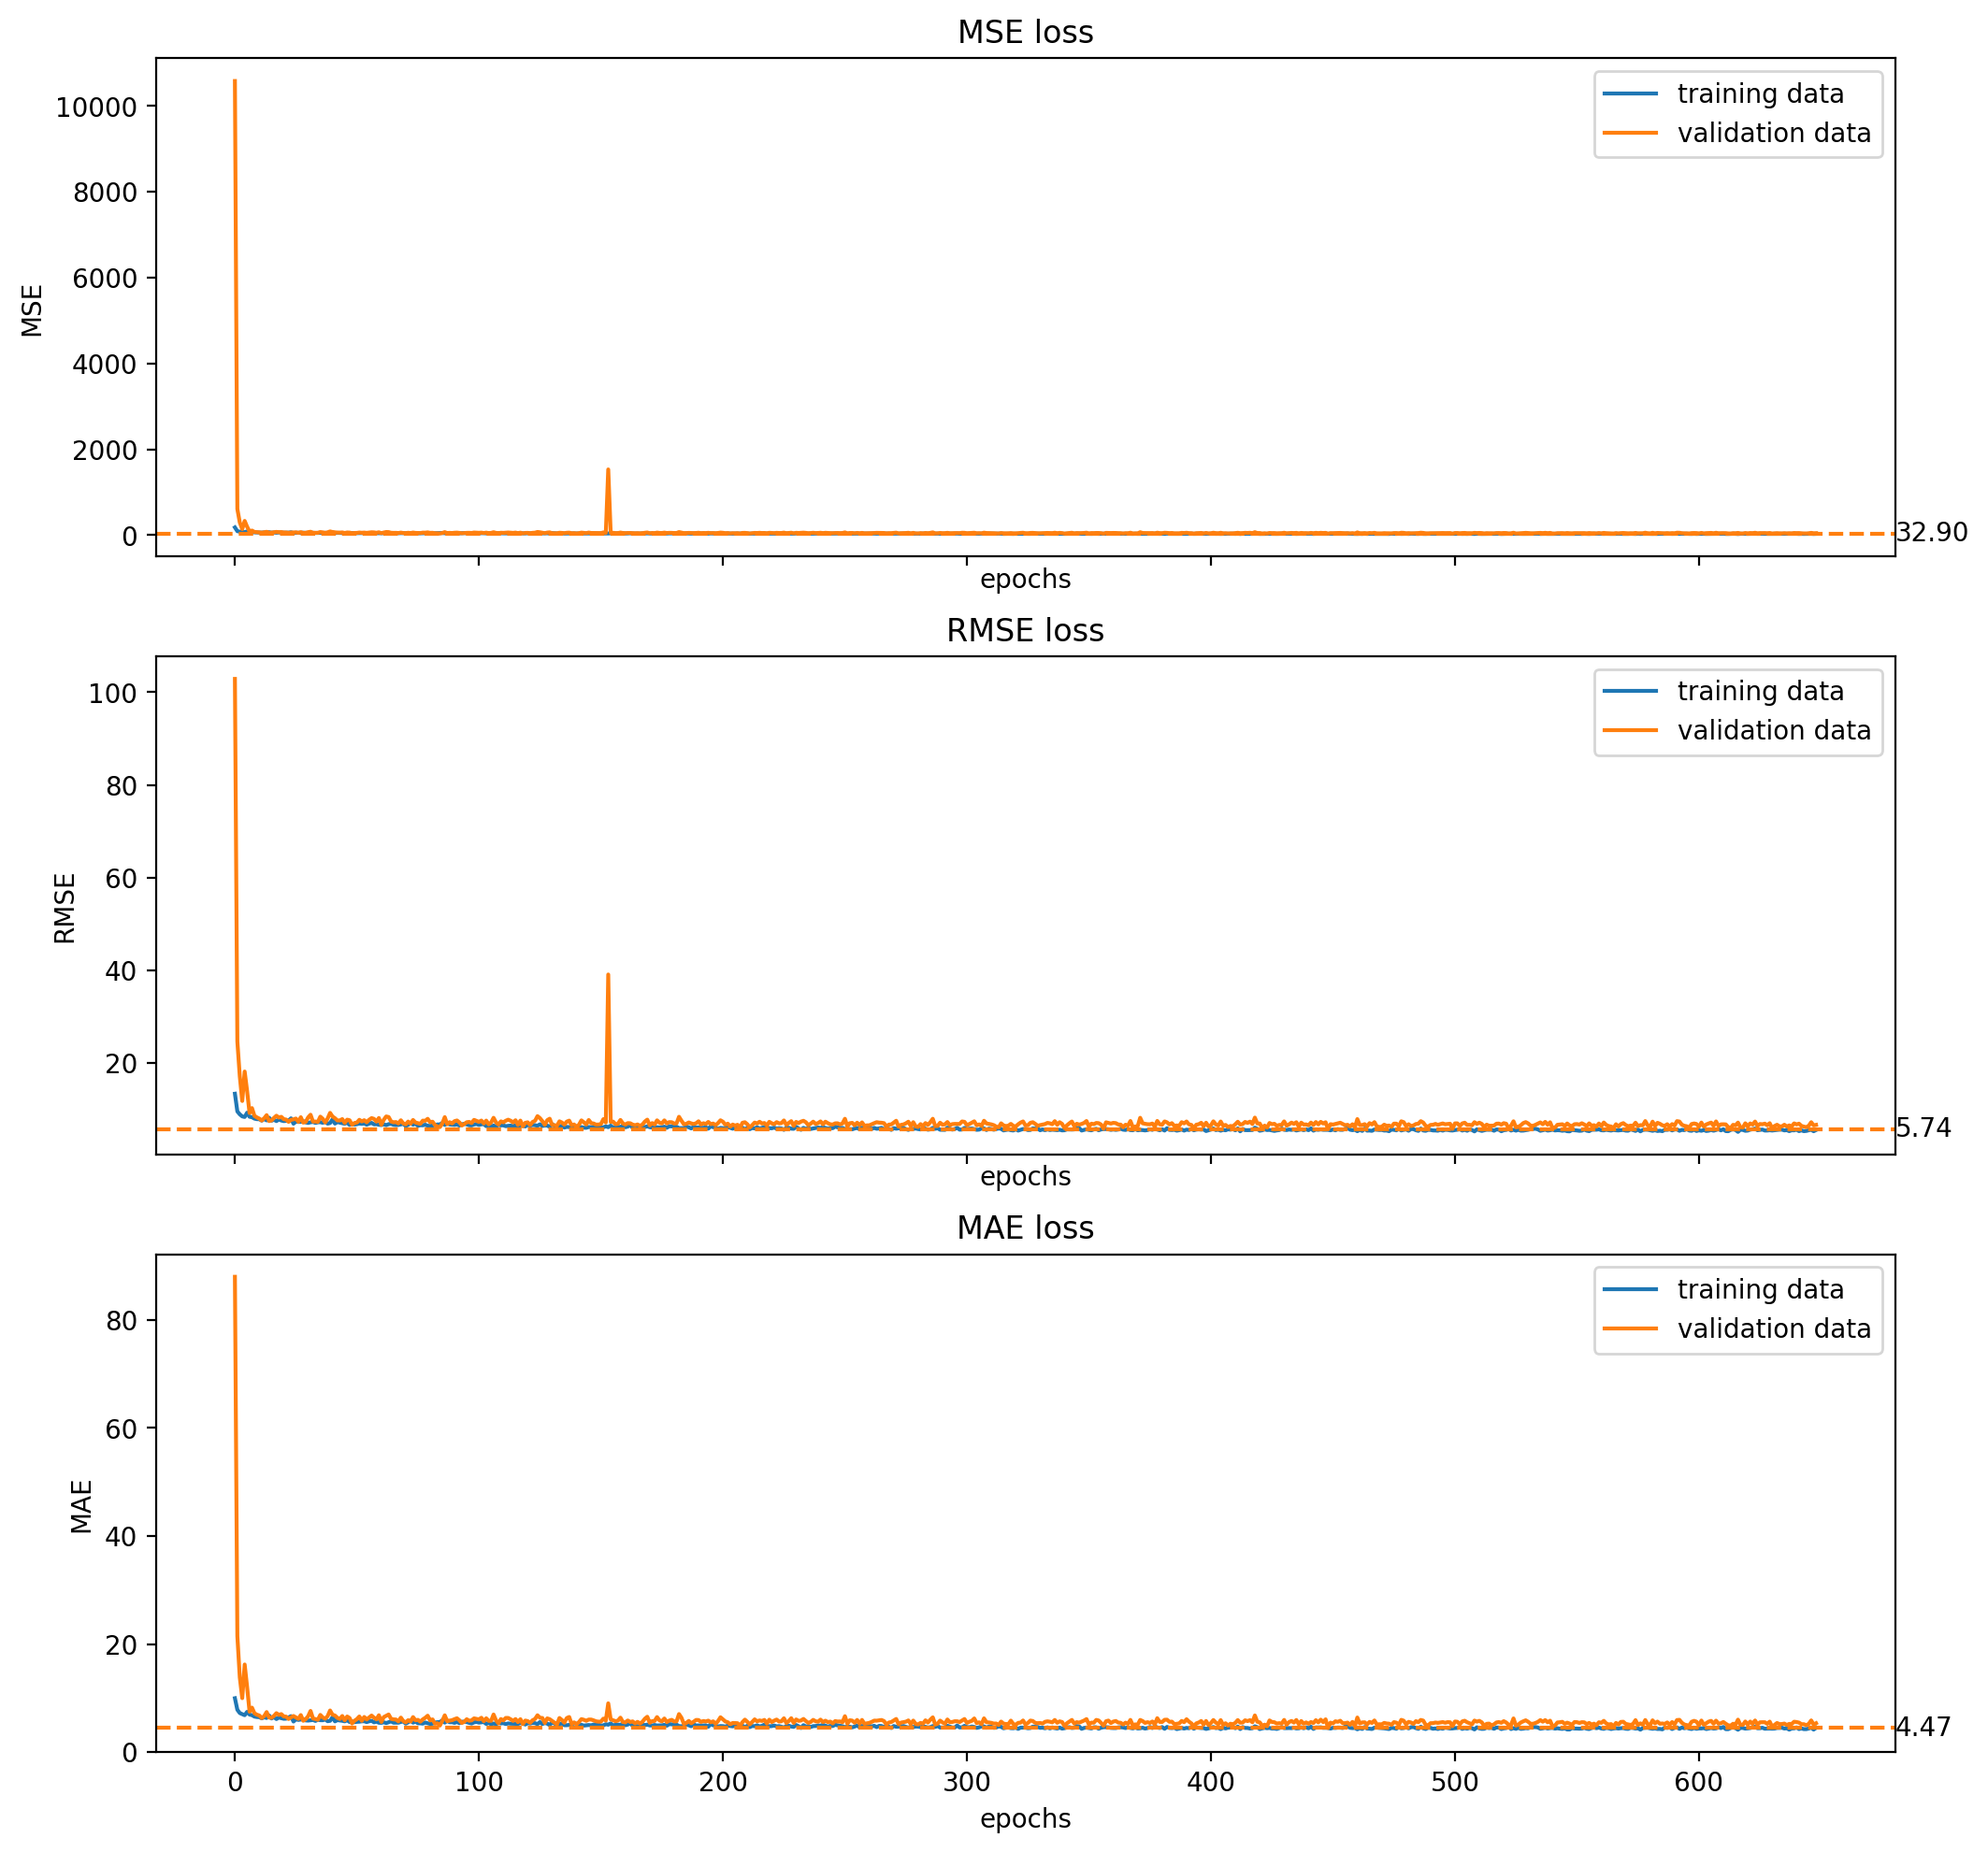

In [52]:
plot_loss(history)

### Model 5 - InceptionTime model

In [9]:
from inception_time import Regressor_INCEPTION

In [25]:
output_filename = 'Inception_classifier01'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [31]:
model = Regressor_INCEPTION(PATH_MODELS, global_avg_pooling=True, input_shape, 1, verbose=True).model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 501, 30)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 501, 32)      960         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 501, 30)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 501, 32)      40960       conv1d_32[0][0]                  
____________________________________________________________________________________________

In [32]:
epochs = 1500

# fit network
history = model.model.fit(x=train_generator,
                          validation_data=val_generator,
                          epochs=epochs,
                          callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
76/76 [==============================] - 78s 987ms/step - loss: 613.2415 - root_mean_squared_error: 24.7008 - mean_absolute_error: 23.1802 - val_loss: 330.5311 - val_root_mean_squared_error: 18.1805 - val_mean_absolute_error: 16.0031

Epoch 00001: val_loss improved from inf to 330.53107, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier01.hdf5
Epoch 2/1500
76/76 [==============================] - 74s 975ms/step - loss: 221.9152 - root_mean_squared_error: 14.8532 - mean_absolute_error: 12.4117 - val_loss: 200.3933 - val_root_mean_squared_error: 14.1560 - val_mean_absolute_error: 11.9203

Epoch 00002: val_loss improved from 330.53107 to 200.39333, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier01.hdf5
Epoch 3/1500
76/76 [==============================] - 74s 972ms/step - loss: 86.6123 - root_mean_squared_error: 9.3037 - mean_absolute_error: 7.7790 - val_loss: 80.3492 - val

76/76 [==============================] - 74s 968ms/step - loss: 46.8308 - root_mean_squared_error: 6.8421 - mean_absolute_error: 5.6090 - val_loss: 53.4691 - val_root_mean_squared_error: 7.3123 - val_mean_absolute_error: 6.0100

Epoch 00053: val_loss did not improve from 46.79149
Epoch 54/1500
76/76 [==============================] - 75s 989ms/step - loss: 44.7226 - root_mean_squared_error: 6.6691 - mean_absolute_error: 5.4251 - val_loss: 59.8905 - val_root_mean_squared_error: 7.7389 - val_mean_absolute_error: 6.4643

Epoch 00054: val_loss did not improve from 46.79149
Epoch 55/1500
76/76 [==============================] - 74s 965ms/step - loss: 55.8125 - root_mean_squared_error: 7.4645 - mean_absolute_error: 6.2935 - val_loss: 64.4702 - val_root_mean_squared_error: 8.0293 - val_mean_absolute_error: 6.4796

Epoch 00055: val_loss did not improve from 46.79149
Epoch 56/1500
76/76 [==============================] - 73s 964ms/step - loss: 53.5213 - root_mean_squared_error: 7.3146 - mean_ab


Epoch 00080: val_loss did not improve from 46.79149
Epoch 81/1500
76/76 [==============================] - 76s 996ms/step - loss: 44.0960 - root_mean_squared_error: 6.6351 - mean_absolute_error: 5.4718 - val_loss: 62.7469 - val_root_mean_squared_error: 7.9213 - val_mean_absolute_error: 6.2741

Epoch 00081: val_loss did not improve from 46.79149
Epoch 82/1500
76/76 [==============================] - 75s 987ms/step - loss: 45.2734 - root_mean_squared_error: 6.7268 - mean_absolute_error: 5.6107 - val_loss: 49.7544 - val_root_mean_squared_error: 7.0537 - val_mean_absolute_error: 5.7535

Epoch 00082: val_loss did not improve from 46.79149
Epoch 83/1500
76/76 [==============================] - 76s 989ms/step - loss: 47.5200 - root_mean_squared_error: 6.8912 - mean_absolute_error: 5.7232 - val_loss: 56.8134 - val_root_mean_squared_error: 7.5375 - val_mean_absolute_error: 6.0459

Epoch 00083: val_loss did not improve from 46.79149
Epoch 84/1500
76/76 [==============================] - 74s 971


Epoch 00134: val_loss did not improve from 40.84338
Epoch 135/1500
76/76 [==============================] - 75s 981ms/step - loss: 41.1324 - root_mean_squared_error: 6.4104 - mean_absolute_error: 5.3276 - val_loss: 47.3178 - val_root_mean_squared_error: 6.8788 - val_mean_absolute_error: 5.5540

Epoch 00135: val_loss did not improve from 40.84338
Epoch 136/1500
76/76 [==============================] - 75s 985ms/step - loss: 38.8815 - root_mean_squared_error: 6.2299 - mean_absolute_error: 5.1090 - val_loss: 47.9592 - val_root_mean_squared_error: 6.9253 - val_mean_absolute_error: 5.5140

Epoch 00136: val_loss did not improve from 40.84338
Epoch 137/1500
76/76 [==============================] - 74s 977ms/step - loss: 38.3852 - root_mean_squared_error: 6.1924 - mean_absolute_error: 4.9994 - val_loss: 70.8448 - val_root_mean_squared_error: 8.4169 - val_mean_absolute_error: 6.6184

Epoch 00137: val_loss did not improve from 40.84338
Epoch 138/1500
76/76 [==============================] - 74s


Epoch 00189: val_loss did not improve from 40.36867
Epoch 190/1500
76/76 [==============================] - 74s 973ms/step - loss: 39.8478 - root_mean_squared_error: 6.3081 - mean_absolute_error: 5.1138 - val_loss: 55.9541 - val_root_mean_squared_error: 7.4802 - val_mean_absolute_error: 6.0123

Epoch 00190: val_loss did not improve from 40.36867
Epoch 191/1500
76/76 [==============================] - 75s 982ms/step - loss: 40.1172 - root_mean_squared_error: 6.3297 - mean_absolute_error: 5.2682 - val_loss: 51.8707 - val_root_mean_squared_error: 7.2021 - val_mean_absolute_error: 5.3874

Epoch 00191: val_loss did not improve from 40.36867
Epoch 192/1500
76/76 [==============================] - 76s 993ms/step - loss: 37.4045 - root_mean_squared_error: 6.1141 - mean_absolute_error: 5.0154 - val_loss: 55.5504 - val_root_mean_squared_error: 7.4532 - val_mean_absolute_error: 5.8672

Epoch 00192: val_loss did not improve from 40.36867
Epoch 193/1500
76/76 [==============================] - 75s


Epoch 00217: val_loss did not improve from 40.36867
Epoch 218/1500
76/76 [==============================] - 74s 975ms/step - loss: 36.7587 - root_mean_squared_error: 6.0583 - mean_absolute_error: 4.9927 - val_loss: 47.4035 - val_root_mean_squared_error: 6.8850 - val_mean_absolute_error: 5.2557

Epoch 00218: val_loss did not improve from 40.36867
Epoch 219/1500
76/76 [==============================] - 74s 974ms/step - loss: 39.7408 - root_mean_squared_error: 6.3026 - mean_absolute_error: 5.0943 - val_loss: 53.3656 - val_root_mean_squared_error: 7.3052 - val_mean_absolute_error: 6.0143

Epoch 00219: val_loss did not improve from 40.36867
Epoch 220/1500
76/76 [==============================] - 74s 979ms/step - loss: 32.6854 - root_mean_squared_error: 5.6962 - mean_absolute_error: 4.5678 - val_loss: 55.2200 - val_root_mean_squared_error: 7.4310 - val_mean_absolute_error: 5.9949

Epoch 00220: val_loss did not improve from 40.36867
Epoch 221/1500
76/76 [==============================] - 75s


Epoch 00272: val_loss did not improve from 35.51273
Epoch 273/1500
76/76 [==============================] - 75s 982ms/step - loss: 38.0110 - root_mean_squared_error: 6.1634 - mean_absolute_error: 5.0264 - val_loss: 45.0551 - val_root_mean_squared_error: 6.7123 - val_mean_absolute_error: 5.5138

Epoch 00273: val_loss did not improve from 35.51273
Epoch 274/1500
76/76 [==============================] - 74s 972ms/step - loss: 36.6130 - root_mean_squared_error: 6.0490 - mean_absolute_error: 4.9693 - val_loss: 53.0143 - val_root_mean_squared_error: 7.2811 - val_mean_absolute_error: 5.7431

Epoch 00274: val_loss did not improve from 35.51273
Epoch 275/1500
76/76 [==============================] - 75s 979ms/step - loss: 36.1024 - root_mean_squared_error: 6.0056 - mean_absolute_error: 4.9159 - val_loss: 48.7492 - val_root_mean_squared_error: 6.9821 - val_mean_absolute_error: 5.6725

Epoch 00275: val_loss did not improve from 35.51273
Epoch 276/1500
76/76 [==============================] - 73s


Epoch 00300: val_loss did not improve from 35.51273
Epoch 301/1500
76/76 [==============================] - 76s 991ms/step - loss: 35.0092 - root_mean_squared_error: 5.9130 - mean_absolute_error: 4.7957 - val_loss: 40.3187 - val_root_mean_squared_error: 6.3497 - val_mean_absolute_error: 5.0081

Epoch 00301: val_loss did not improve from 35.51273
Epoch 302/1500
76/76 [==============================] - 76s 1s/step - loss: 33.8298 - root_mean_squared_error: 5.8133 - mean_absolute_error: 4.7063 - val_loss: 47.4990 - val_root_mean_squared_error: 6.8920 - val_mean_absolute_error: 5.6196

Epoch 00302: val_loss did not improve from 35.51273
Epoch 303/1500
76/76 [==============================] - 75s 983ms/step - loss: 36.4802 - root_mean_squared_error: 6.0325 - mean_absolute_error: 4.7889 - val_loss: 54.3849 - val_root_mean_squared_error: 7.3746 - val_mean_absolute_error: 5.7717

Epoch 00303: val_loss did not improve from 35.51273
Epoch 304/1500
76/76 [==============================] - 76s 99


Epoch 00328: val_loss did not improve from 35.51273
Epoch 329/1500
76/76 [==============================] - 77s 1s/step - loss: 33.6787 - root_mean_squared_error: 5.8007 - mean_absolute_error: 4.8021 - val_loss: 55.7405 - val_root_mean_squared_error: 7.4660 - val_mean_absolute_error: 5.8337

Epoch 00329: val_loss did not improve from 35.51273
Epoch 330/1500
76/76 [==============================] - 77s 1s/step - loss: 36.8469 - root_mean_squared_error: 6.0652 - mean_absolute_error: 4.9122 - val_loss: 53.1375 - val_root_mean_squared_error: 7.2895 - val_mean_absolute_error: 5.9378

Epoch 00330: val_loss did not improve from 35.51273
Epoch 331/1500
76/76 [==============================] - 74s 977ms/step - loss: 34.6141 - root_mean_squared_error: 5.8781 - mean_absolute_error: 4.7726 - val_loss: 50.9419 - val_root_mean_squared_error: 7.1374 - val_mean_absolute_error: 5.7918

Epoch 00331: val_loss did not improve from 35.51273
Epoch 332/1500
76/76 [==============================] - 77s 1s/st


Epoch 00356: val_loss did not improve from 35.51273
Epoch 357/1500
76/76 [==============================] - 76s 999ms/step - loss: 38.7200 - root_mean_squared_error: 6.2177 - mean_absolute_error: 5.0521 - val_loss: 48.7508 - val_root_mean_squared_error: 6.9822 - val_mean_absolute_error: 5.6708

Epoch 00357: val_loss did not improve from 35.51273
Epoch 358/1500
76/76 [==============================] - 76s 995ms/step - loss: 37.6218 - root_mean_squared_error: 6.1281 - mean_absolute_error: 5.0000 - val_loss: 36.6644 - val_root_mean_squared_error: 6.0551 - val_mean_absolute_error: 4.6717

Epoch 00358: val_loss did not improve from 35.51273
Epoch 359/1500
76/76 [==============================] - 76s 996ms/step - loss: 31.9137 - root_mean_squared_error: 5.6435 - mean_absolute_error: 4.6150 - val_loss: 39.9387 - val_root_mean_squared_error: 6.3197 - val_mean_absolute_error: 5.0673

Epoch 00359: val_loss did not improve from 35.51273
Epoch 360/1500
76/76 [==============================] - 73s


Epoch 00384: val_loss did not improve from 35.51273
Epoch 385/1500
76/76 [==============================] - 76s 991ms/step - loss: 36.2393 - root_mean_squared_error: 6.0167 - mean_absolute_error: 4.8862 - val_loss: 49.6015 - val_root_mean_squared_error: 7.0428 - val_mean_absolute_error: 5.7009

Epoch 00385: val_loss did not improve from 35.51273
Epoch 386/1500
76/76 [==============================] - 76s 996ms/step - loss: 34.1459 - root_mean_squared_error: 5.8364 - mean_absolute_error: 4.8415 - val_loss: 52.6645 - val_root_mean_squared_error: 7.2570 - val_mean_absolute_error: 5.8622

Epoch 00386: val_loss did not improve from 35.51273
Epoch 387/1500
76/76 [==============================] - 76s 995ms/step - loss: 37.0036 - root_mean_squared_error: 6.0818 - mean_absolute_error: 4.9566 - val_loss: 49.1435 - val_root_mean_squared_error: 7.0102 - val_mean_absolute_error: 5.4798

Epoch 00387: val_loss did not improve from 35.51273
Epoch 388/1500
76/76 [==============================] - 76s


Epoch 00412: val_loss did not improve from 35.51273
Epoch 413/1500
76/76 [==============================] - 76s 999ms/step - loss: 36.9808 - root_mean_squared_error: 6.0758 - mean_absolute_error: 4.8946 - val_loss: 53.1729 - val_root_mean_squared_error: 7.2920 - val_mean_absolute_error: 5.9470

Epoch 00413: val_loss did not improve from 35.51273
Epoch 414/1500
76/76 [==============================] - 76s 999ms/step - loss: 35.0964 - root_mean_squared_error: 5.9160 - mean_absolute_error: 4.6959 - val_loss: 44.0396 - val_root_mean_squared_error: 6.6362 - val_mean_absolute_error: 5.4812

Epoch 00414: val_loss did not improve from 35.51273
Epoch 415/1500
76/76 [==============================] - 75s 980ms/step - loss: 34.4791 - root_mean_squared_error: 5.8688 - mean_absolute_error: 4.8086 - val_loss: 41.6161 - val_root_mean_squared_error: 6.4511 - val_mean_absolute_error: 5.2384

Epoch 00415: val_loss did not improve from 35.51273
Epoch 416/1500
76/76 [==============================] - 75s

In [34]:
evaluate_model(model)

16/16 [==============================] - 10s 642ms/step - loss: 47.9596 - root_mean_squared_error: 6.9253 - mean_absolute_error: 5.6090


[47.95956802368164, 6.9252848625183105, 5.609043598175049]

In [35]:
print_few_predictions(model)

[[37.93996 ]
 [33.793102]
 [23.763   ]
 [38.90028 ]
 [30.212704]
 [25.34288 ]
 [17.816767]
 [37.729877]
 [17.709986]
 [40.9809  ]
 [31.693163]]
[[35.]
 [35.]
 [29.]
 [41.]
 [17.]
 [17.]
 [23.]
 [41.]
 [17.]
 [41.]
 [41.]]


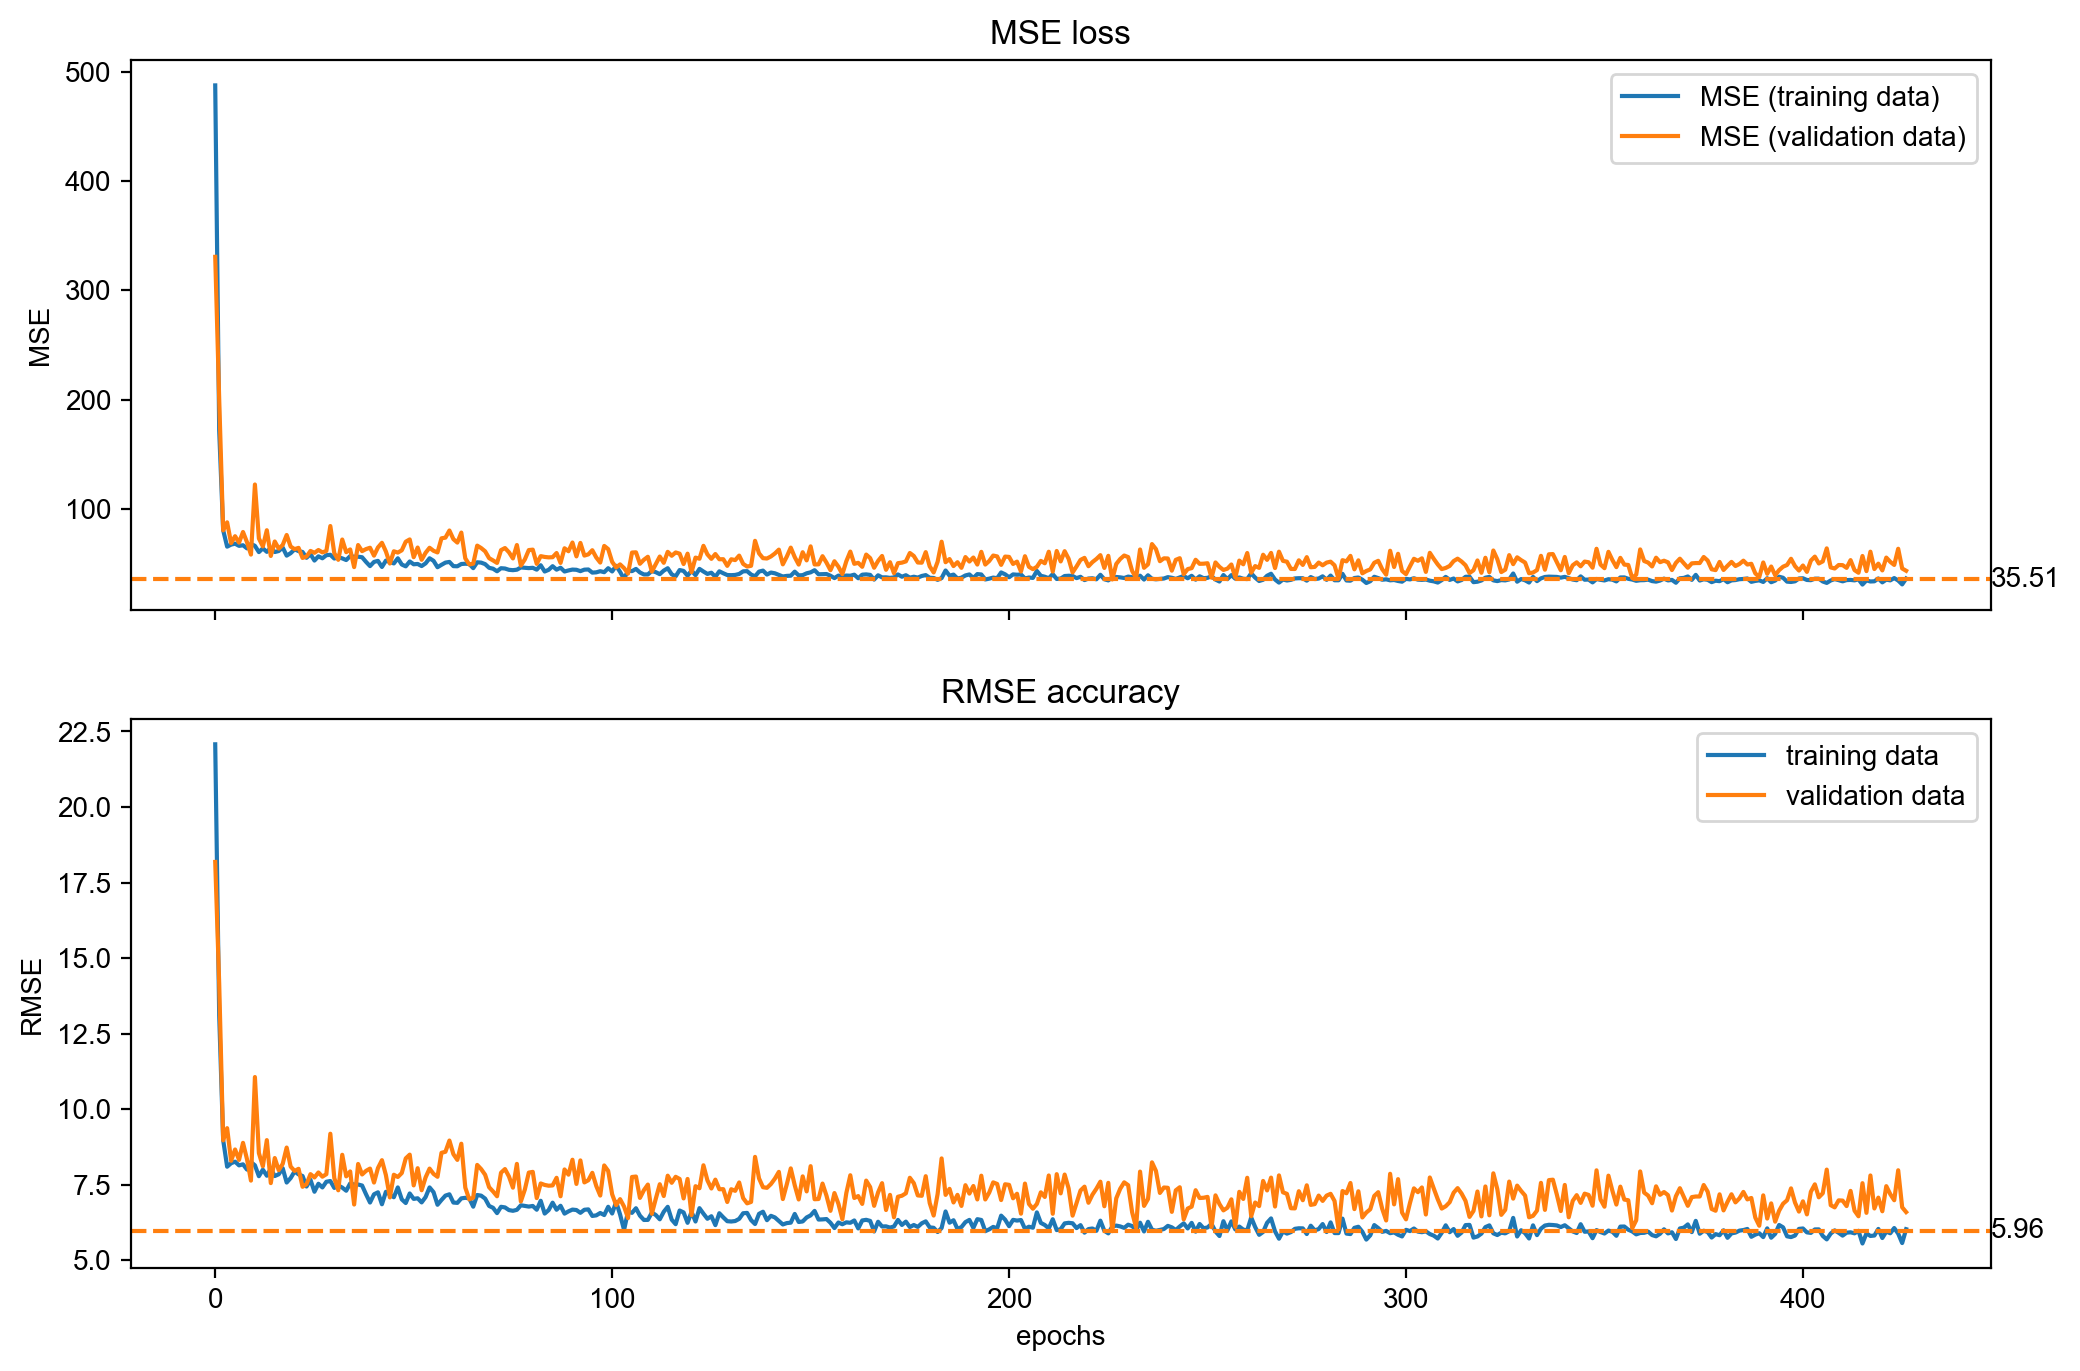

In [78]:
plot_loss(history)

### Model 6 - InceptionTime model, no global pooling

In [61]:
from inception_time import Regressor_INCEPTION

In [24]:
output_filename = 'Inception_classifier02'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [25]:
model = Regressor_INCEPTION(PATH_MODELS, input_shape, 1, verbose=True).model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 501, 30)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 501, 32)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 501, 30)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 501, 32)      40960       conv1d[0][0]                     
______________________________________________________________________________________________

In [26]:
epochs = 1500

# fit network
history = model.model.fit(x=train_generator,
              validation_data=val_generator,
              epochs=epochs,
              callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
76/76 [==============================] - 103s 1s/step - loss: 161.3301 - root_mean_squared_error: 12.2371 - mean_absolute_error: 9.8552 - val_loss: 284.4185 - val_root_mean_squared_error: 16.8647 - val_mean_absolute_error: 15.0258

Epoch 00001: val_loss improved from inf to 284.41846, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier02.hdf5
Epoch 2/1500
76/76 [==============================] - 90s 1s/step - loss: 75.2325 - root_mean_squared_error: 8.6645 - mean_absolute_error: 7.2825 - val_loss: 133.2656 - val_root_mean_squared_error: 11.5441 - val_mean_absolute_error: 9.4109

Epoch 00002: val_loss improved from 284.41846 to 133.26561, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier02.hdf5
Epoch 3/1500
76/76 [==============================] - 90s 1s/step - loss: 69.6444 - root_mean_squared_error: 8.3431 - mean_absolute_error: 7.0531 - val_loss: 81.8585 - val_root_mean_sq


Epoch 00052: val_loss did not improve from 40.88636
Epoch 53/1500
76/76 [==============================] - 83s 1s/step - loss: 41.3699 - root_mean_squared_error: 6.4294 - mean_absolute_error: 5.2747 - val_loss: 51.2328 - val_root_mean_squared_error: 7.1577 - val_mean_absolute_error: 5.8886

Epoch 00053: val_loss did not improve from 40.88636
Epoch 54/1500
76/76 [==============================] - 82s 1s/step - loss: 43.7813 - root_mean_squared_error: 6.6127 - mean_absolute_error: 5.4460 - val_loss: 61.3560 - val_root_mean_squared_error: 7.8330 - val_mean_absolute_error: 6.3690

Epoch 00054: val_loss did not improve from 40.88636
Epoch 55/1500
76/76 [==============================] - 83s 1s/step - loss: 34.3851 - root_mean_squared_error: 5.8578 - mean_absolute_error: 4.6708 - val_loss: 44.8926 - val_root_mean_squared_error: 6.7002 - val_mean_absolute_error: 5.4559

Epoch 00055: val_loss did not improve from 40.88636
Epoch 56/1500
76/76 [==============================] - 83s 1s/step - lo

76/76 [==============================] - 86s 1s/step - loss: 34.4256 - root_mean_squared_error: 5.8595 - mean_absolute_error: 4.6566 - val_loss: 42.8362 - val_root_mean_squared_error: 6.5449 - val_mean_absolute_error: 5.5926

Epoch 00107: val_loss did not improve from 35.37915
Epoch 108/1500
76/76 [==============================] - 87s 1s/step - loss: 37.3083 - root_mean_squared_error: 6.1041 - mean_absolute_error: 4.9760 - val_loss: 47.3587 - val_root_mean_squared_error: 6.8818 - val_mean_absolute_error: 5.6572

Epoch 00108: val_loss did not improve from 35.37915
Epoch 109/1500
76/76 [==============================] - 95s 1s/step - loss: 32.4449 - root_mean_squared_error: 5.6936 - mean_absolute_error: 4.4906 - val_loss: 42.5866 - val_root_mean_squared_error: 6.5258 - val_mean_absolute_error: 5.3221

Epoch 00109: val_loss did not improve from 35.37915
Epoch 110/1500
76/76 [==============================] - 94s 1s/step - loss: 36.0411 - root_mean_squared_error: 6.0003 - mean_absolute_er

76/76 [==============================] - 80s 1s/step - loss: 34.3451 - root_mean_squared_error: 5.8593 - mean_absolute_error: 4.6807 - val_loss: 49.1691 - val_root_mean_squared_error: 7.0121 - val_mean_absolute_error: 5.6306

Epoch 00135: val_loss did not improve from 35.37915
Epoch 136/1500
76/76 [==============================] - 84s 1s/step - loss: 30.8836 - root_mean_squared_error: 5.5517 - mean_absolute_error: 4.4766 - val_loss: 50.3578 - val_root_mean_squared_error: 7.0963 - val_mean_absolute_error: 5.5796

Epoch 00136: val_loss did not improve from 35.37915
Epoch 137/1500
76/76 [==============================] - 81s 1s/step - loss: 31.7557 - root_mean_squared_error: 5.6310 - mean_absolute_error: 4.5066 - val_loss: 43.3773 - val_root_mean_squared_error: 6.5861 - val_mean_absolute_error: 5.4036

Epoch 00137: val_loss did not improve from 35.37915
Epoch 138/1500
76/76 [==============================] - 81s 1s/step - loss: 35.2371 - root_mean_squared_error: 5.9329 - mean_absolute_er

76/76 [==============================] - 81s 1s/step - loss: 28.5204 - root_mean_squared_error: 5.3388 - mean_absolute_error: 4.3477 - val_loss: 44.8401 - val_root_mean_squared_error: 6.6963 - val_mean_absolute_error: 5.4607

Epoch 00163: val_loss did not improve from 35.37915
Epoch 164/1500
76/76 [==============================] - 81s 1s/step - loss: 35.6042 - root_mean_squared_error: 5.9645 - mean_absolute_error: 4.7256 - val_loss: 48.3332 - val_root_mean_squared_error: 6.9522 - val_mean_absolute_error: 5.7188

Epoch 00164: val_loss did not improve from 35.37915
Epoch 165/1500
76/76 [==============================] - 80s 1s/step - loss: 28.3071 - root_mean_squared_error: 5.3173 - mean_absolute_error: 4.3123 - val_loss: 57.1683 - val_root_mean_squared_error: 7.5610 - val_mean_absolute_error: 6.0918

Epoch 00165: val_loss did not improve from 35.37915
Epoch 166/1500
76/76 [==============================] - 85s 1s/step - loss: 33.9865 - root_mean_squared_error: 5.8240 - mean_absolute_er

76/76 [==============================] - 81s 1s/step - loss: 34.2731 - root_mean_squared_error: 5.8351 - mean_absolute_error: 4.6724 - val_loss: 38.7069 - val_root_mean_squared_error: 6.2215 - val_mean_absolute_error: 5.0997

Epoch 00191: val_loss did not improve from 35.37915
Epoch 192/1500
76/76 [==============================] - 80s 1s/step - loss: 28.9855 - root_mean_squared_error: 5.3812 - mean_absolute_error: 4.3410 - val_loss: 41.4331 - val_root_mean_squared_error: 6.4369 - val_mean_absolute_error: 5.1583

Epoch 00192: val_loss did not improve from 35.37915
Epoch 193/1500
76/76 [==============================] - 80s 1s/step - loss: 29.0092 - root_mean_squared_error: 5.3836 - mean_absolute_error: 4.2950 - val_loss: 47.0153 - val_root_mean_squared_error: 6.8568 - val_mean_absolute_error: 5.5696

Epoch 00193: val_loss did not improve from 35.37915
Epoch 194/1500
76/76 [==============================] - 81s 1s/step - loss: 29.6600 - root_mean_squared_error: 5.4414 - mean_absolute_er

76/76 [==============================] - 80s 1s/step - loss: 29.8320 - root_mean_squared_error: 5.4586 - mean_absolute_error: 4.3812 - val_loss: 40.8931 - val_root_mean_squared_error: 6.3948 - val_mean_absolute_error: 5.3047

Epoch 00219: val_loss did not improve from 35.37915
Epoch 220/1500
76/76 [==============================] - 80s 1s/step - loss: 27.3695 - root_mean_squared_error: 5.2297 - mean_absolute_error: 4.2416 - val_loss: 43.8166 - val_root_mean_squared_error: 6.6194 - val_mean_absolute_error: 5.5530

Epoch 00220: val_loss did not improve from 35.37915
Epoch 221/1500
76/76 [==============================] - 80s 1s/step - loss: 30.8730 - root_mean_squared_error: 5.5521 - mean_absolute_error: 4.3882 - val_loss: 47.7293 - val_root_mean_squared_error: 6.9086 - val_mean_absolute_error: 5.6302

Epoch 00221: val_loss did not improve from 35.37915
Epoch 222/1500
76/76 [==============================] - 80s 1s/step - loss: 28.7697 - root_mean_squared_error: 5.3586 - mean_absolute_er


Epoch 00246: val_loss did not improve from 35.13448
Epoch 247/1500
76/76 [==============================] - 80s 1s/step - loss: 28.4684 - root_mean_squared_error: 5.3349 - mean_absolute_error: 4.2713 - val_loss: 46.1421 - val_root_mean_squared_error: 6.7928 - val_mean_absolute_error: 5.4833

Epoch 00247: val_loss did not improve from 35.13448
Epoch 248/1500
76/76 [==============================] - 79s 1s/step - loss: 26.4379 - root_mean_squared_error: 5.1385 - mean_absolute_error: 4.0859 - val_loss: 40.6242 - val_root_mean_squared_error: 6.3737 - val_mean_absolute_error: 5.2228

Epoch 00248: val_loss did not improve from 35.13448
Epoch 249/1500
76/76 [==============================] - 80s 1s/step - loss: 25.5022 - root_mean_squared_error: 5.0470 - mean_absolute_error: 4.0437 - val_loss: 44.0031 - val_root_mean_squared_error: 6.6335 - val_mean_absolute_error: 5.2856

Epoch 00249: val_loss did not improve from 35.13448
Epoch 250/1500
76/76 [==============================] - 79s 1s/step 


Epoch 00274: val_loss did not improve from 35.13448
Epoch 275/1500
76/76 [==============================] - 80s 1s/step - loss: 25.2749 - root_mean_squared_error: 5.0268 - mean_absolute_error: 4.0303 - val_loss: 52.8182 - val_root_mean_squared_error: 7.2676 - val_mean_absolute_error: 5.5558

Epoch 00275: val_loss did not improve from 35.13448
Epoch 276/1500
76/76 [==============================] - 80s 1s/step - loss: 28.7474 - root_mean_squared_error: 5.3554 - mean_absolute_error: 4.2152 - val_loss: 45.5257 - val_root_mean_squared_error: 6.7473 - val_mean_absolute_error: 5.5685

Epoch 00276: val_loss did not improve from 35.13448
Epoch 277/1500
76/76 [==============================] - 81s 1s/step - loss: 25.5497 - root_mean_squared_error: 5.0503 - mean_absolute_error: 4.0572 - val_loss: 50.2792 - val_root_mean_squared_error: 7.0908 - val_mean_absolute_error: 5.7518

Epoch 00277: val_loss did not improve from 35.13448
Epoch 278/1500
76/76 [==============================] - 78s 1s/step 


Epoch 00302: val_loss did not improve from 35.13448
Epoch 303/1500
76/76 [==============================] - 81s 1s/step - loss: 26.0653 - root_mean_squared_error: 5.1028 - mean_absolute_error: 4.0967 - val_loss: 43.1423 - val_root_mean_squared_error: 6.5683 - val_mean_absolute_error: 5.1521

Epoch 00303: val_loss did not improve from 35.13448
Epoch 304/1500
76/76 [==============================] - 79s 1s/step - loss: 27.8326 - root_mean_squared_error: 5.2700 - mean_absolute_error: 4.2013 - val_loss: 53.6184 - val_root_mean_squared_error: 7.3225 - val_mean_absolute_error: 5.9598

Epoch 00304: val_loss did not improve from 35.13448
Epoch 305/1500
76/76 [==============================] - 79s 1s/step - loss: 25.0710 - root_mean_squared_error: 5.0062 - mean_absolute_error: 4.0480 - val_loss: 54.3285 - val_root_mean_squared_error: 7.3708 - val_mean_absolute_error: 6.0654

Epoch 00305: val_loss did not improve from 35.13448
Epoch 306/1500
76/76 [==============================] - 82s 1s/step 


Epoch 00330: val_loss did not improve from 35.13448
Epoch 331/1500
76/76 [==============================] - 82s 1s/step - loss: 23.5993 - root_mean_squared_error: 4.8529 - mean_absolute_error: 3.8569 - val_loss: 47.5144 - val_root_mean_squared_error: 6.8931 - val_mean_absolute_error: 5.6104

Epoch 00331: val_loss did not improve from 35.13448
Epoch 332/1500
76/76 [==============================] - 81s 1s/step - loss: 23.9250 - root_mean_squared_error: 4.8892 - mean_absolute_error: 3.8085 - val_loss: 44.8639 - val_root_mean_squared_error: 6.6981 - val_mean_absolute_error: 5.5633

Epoch 00332: val_loss did not improve from 35.13448
Epoch 333/1500
76/76 [==============================] - 79s 1s/step - loss: 26.4633 - root_mean_squared_error: 5.1415 - mean_absolute_error: 4.0976 - val_loss: 47.8821 - val_root_mean_squared_error: 6.9197 - val_mean_absolute_error: 5.5583

Epoch 00333: val_loss did not improve from 35.13448
Epoch 334/1500
76/76 [==============================] - 80s 1s/step 


Epoch 00358: val_loss did not improve from 35.13448
Epoch 359/1500
76/76 [==============================] - 81s 1s/step - loss: 23.3416 - root_mean_squared_error: 4.8288 - mean_absolute_error: 3.8163 - val_loss: 35.8318 - val_root_mean_squared_error: 5.9860 - val_mean_absolute_error: 4.8036

Epoch 00359: val_loss did not improve from 35.13448
Epoch 360/1500
76/76 [==============================] - 81s 1s/step - loss: 27.5454 - root_mean_squared_error: 5.2396 - mean_absolute_error: 4.0596 - val_loss: 38.7026 - val_root_mean_squared_error: 6.2211 - val_mean_absolute_error: 4.9745

Epoch 00360: val_loss did not improve from 35.13448
Epoch 361/1500
76/76 [==============================] - 81s 1s/step - loss: 24.1017 - root_mean_squared_error: 4.8925 - mean_absolute_error: 3.8867 - val_loss: 51.0532 - val_root_mean_squared_error: 7.1452 - val_mean_absolute_error: 5.9076

Epoch 00361: val_loss did not improve from 35.13448
Epoch 362/1500
76/76 [==============================] - 81s 1s/step 


Epoch 00386: val_loss did not improve from 35.13448
Epoch 387/1500
76/76 [==============================] - 82s 1s/step - loss: 26.1548 - root_mean_squared_error: 5.0999 - mean_absolute_error: 4.0387 - val_loss: 46.0188 - val_root_mean_squared_error: 6.7837 - val_mean_absolute_error: 5.4312

Epoch 00387: val_loss did not improve from 35.13448
Epoch 388/1500
76/76 [==============================] - 80s 1s/step - loss: 25.5969 - root_mean_squared_error: 5.0578 - mean_absolute_error: 4.0108 - val_loss: 47.6047 - val_root_mean_squared_error: 6.8996 - val_mean_absolute_error: 5.6009

Epoch 00388: val_loss did not improve from 35.13448
Epoch 389/1500
76/76 [==============================] - 80s 1s/step - loss: 26.2402 - root_mean_squared_error: 5.1198 - mean_absolute_error: 4.1248 - val_loss: 54.6816 - val_root_mean_squared_error: 7.3947 - val_mean_absolute_error: 5.9300

Epoch 00389: val_loss did not improve from 35.13448
Epoch 390/1500
76/76 [==============================] - 82s 1s/step 


Epoch 00414: val_loss did not improve from 35.13448
Epoch 415/1500
76/76 [==============================] - 80s 1s/step - loss: 26.9964 - root_mean_squared_error: 5.1894 - mean_absolute_error: 4.1043 - val_loss: 41.3160 - val_root_mean_squared_error: 6.4278 - val_mean_absolute_error: 5.1566

Epoch 00415: val_loss did not improve from 35.13448
Epoch 416/1500
76/76 [==============================] - 81s 1s/step - loss: 26.6544 - root_mean_squared_error: 5.1582 - mean_absolute_error: 4.1031 - val_loss: 46.1805 - val_root_mean_squared_error: 6.7956 - val_mean_absolute_error: 5.3915

Epoch 00416: val_loss did not improve from 35.13448
Epoch 417/1500
76/76 [==============================] - 82s 1s/step - loss: 25.1120 - root_mean_squared_error: 5.0075 - mean_absolute_error: 4.0018 - val_loss: 45.6618 - val_root_mean_squared_error: 6.7574 - val_mean_absolute_error: 5.4573

Epoch 00417: val_loss did not improve from 35.13448
Epoch 418/1500
76/76 [==============================] - 80s 1s/step 

In [27]:
evaluate_model(model)

16/16 [==============================] - 11s 691ms/step - loss: 39.6206 - root_mean_squared_error: 6.2945 - mean_absolute_error: 4.9952


[39.62059783935547, 6.29448938369751, 4.995177268981934]

In [28]:
print_few_predictions(model)

[[21.200651]
 [34.45015 ]
 [38.090397]
 [23.119928]
 [28.156874]
 [32.97323 ]
 [39.12761 ]
 [32.863625]
 [31.695362]
 [38.83041 ]
 [37.060955]]
[[29.]
 [35.]
 [35.]
 [29.]
 [29.]
 [35.]
 [41.]
 [41.]
 [29.]
 [41.]
 [35.]]


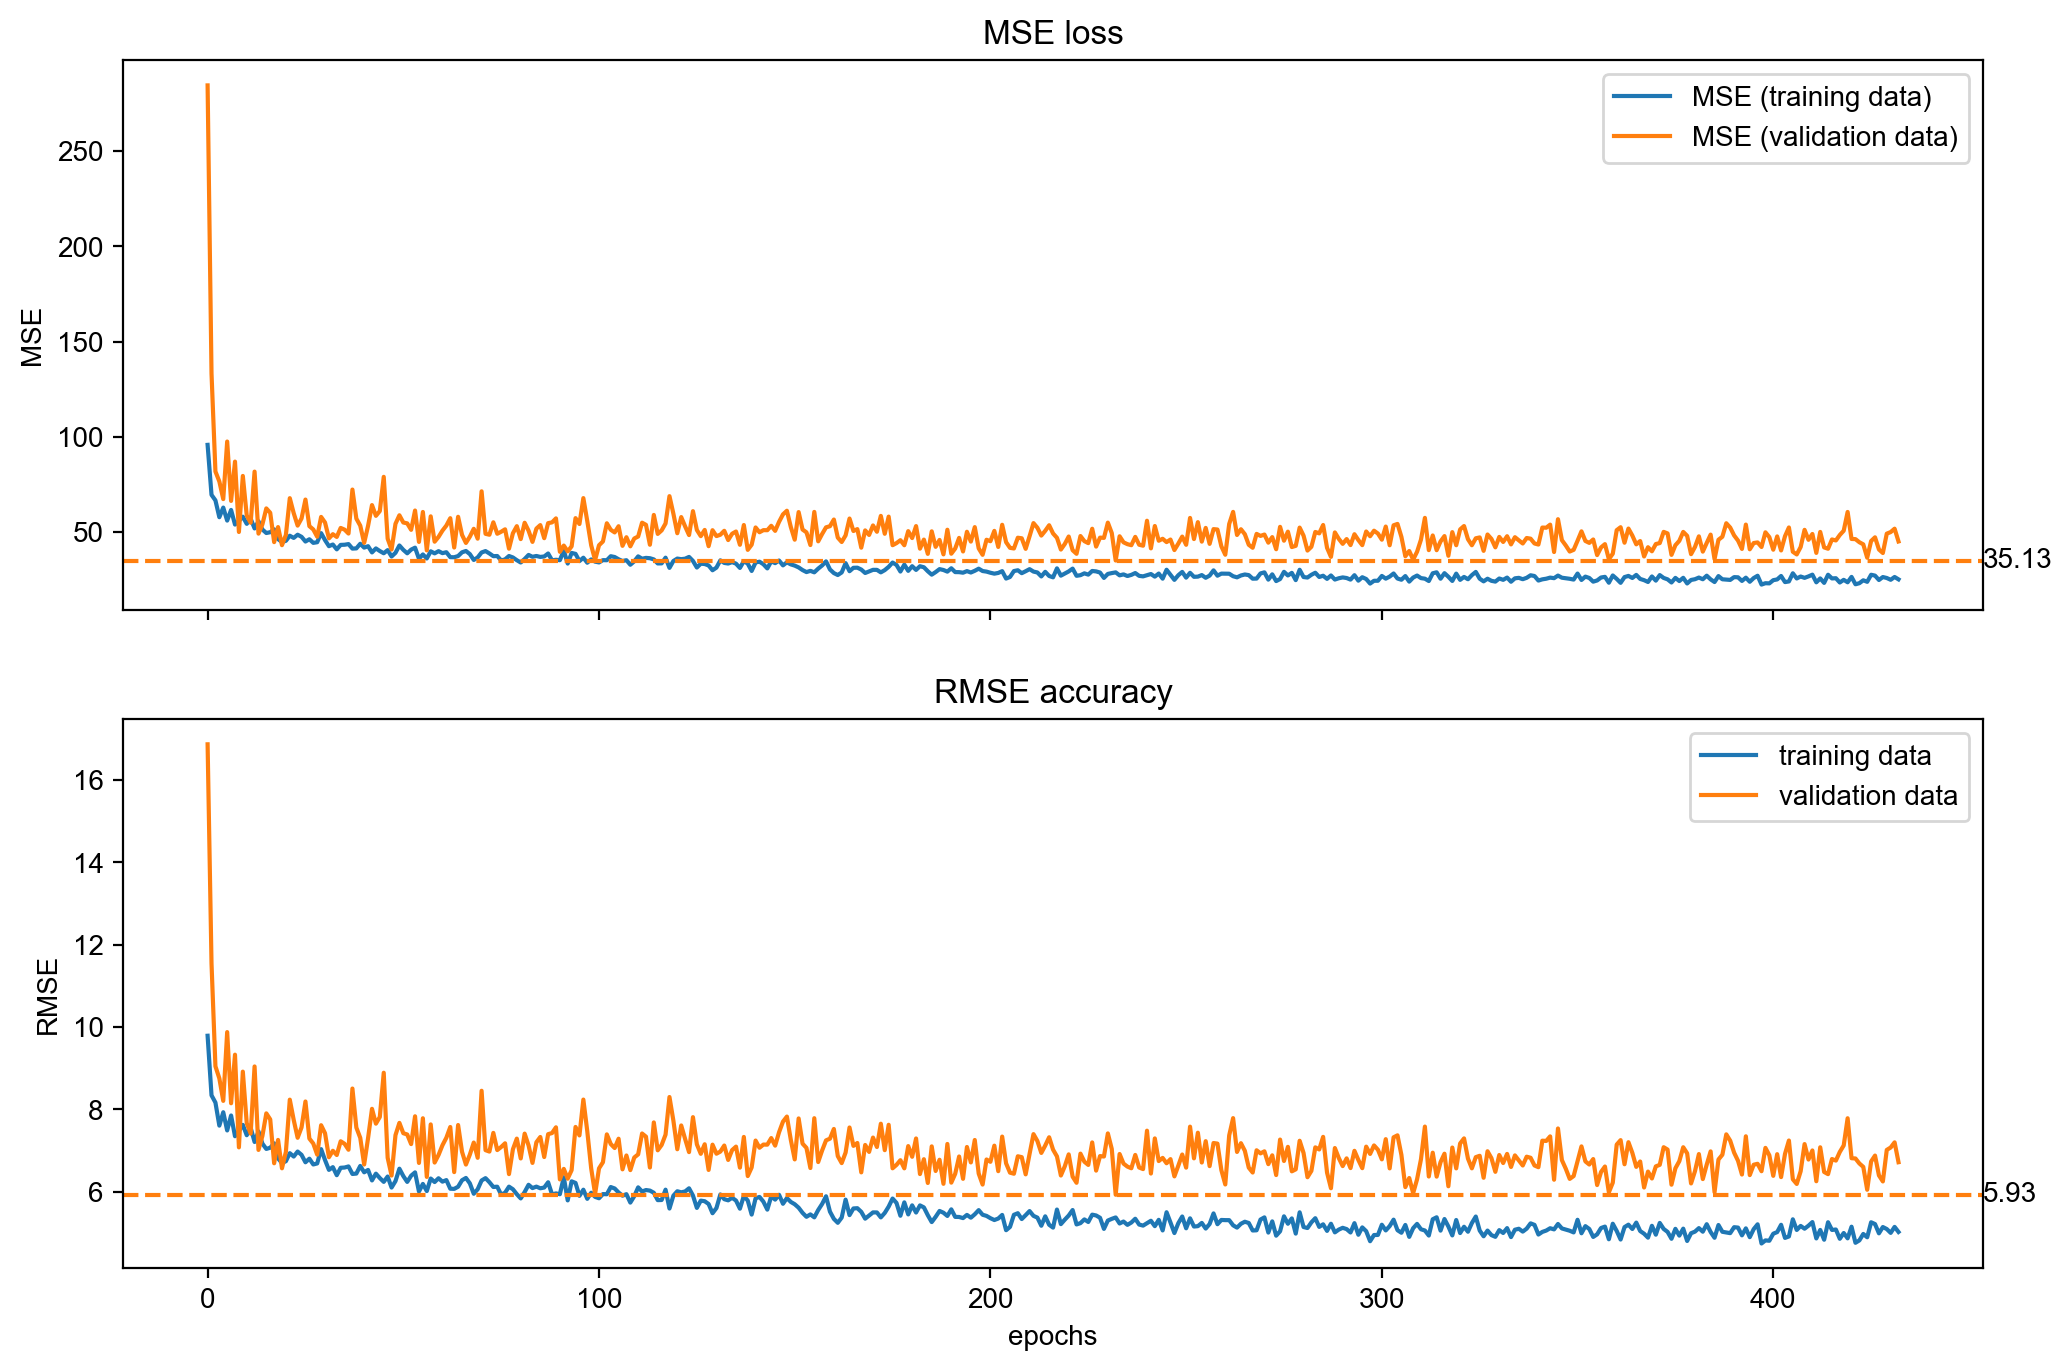

In [29]:
plot_loss(history)

### Model 7 - InceptionTime model, no global pooling, gaussian noise

In [29]:
from inception_time import Regressor_INCEPTION

In [28]:
output_filename = 'Inception_classifier03'
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001, verbose=1)

In [29]:
model = Regressor_INCEPTION(PATH_MODELS, input_shape, 1, verbose=True).model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 501, 30)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 501, 32)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 501, 30)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 501, 32)      40960       conv1d[0][0]                     
______________________________________________________________________________________________

In [31]:
epochs = 1500

# fit network
history = model.model.fit(x=train_generator_noise, # Use generator with noise
              validation_data=val_generator,
              epochs=epochs,
              callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
76/76 [==============================] - 94s 1s/step - loss: 174.9512 - root_mean_squared_error: 12.5932 - mean_absolute_error: 9.9551 - val_loss: 252.3429 - val_root_mean_squared_error: 15.8853 - val_mean_absolute_error: 13.9289

Epoch 00001: val_loss improved from inf to 252.34286, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier03.hdf5
Epoch 2/1500
76/76 [==============================] - 90s 1s/step - loss: 72.7916 - root_mean_squared_error: 8.5283 - mean_absolute_error: 7.2148 - val_loss: 137.6458 - val_root_mean_squared_error: 11.7323 - val_mean_absolute_error: 9.2772

Epoch 00002: val_loss improved from 252.34286 to 137.64577, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier03.hdf5
Epoch 3/1500
76/76 [==============================] - 102s 1s/step - loss: 68.7017 - root_mean_squared_error: 8.2830 - mean_absolute_error: 6.8418 - val_loss: 111.5382 - val_root_mean_s

76/76 [==============================] - 86s 1s/step - loss: 44.7356 - root_mean_squared_error: 6.6835 - mean_absolute_error: 5.4343 - val_loss: 52.7051 - val_root_mean_squared_error: 7.2598 - val_mean_absolute_error: 5.8225

Epoch 00026: val_loss did not improve from 50.04919
Epoch 27/1500
76/76 [==============================] - 85s 1s/step - loss: 46.0297 - root_mean_squared_error: 6.7810 - mean_absolute_error: 5.5484 - val_loss: 55.5979 - val_root_mean_squared_error: 7.4564 - val_mean_absolute_error: 5.9416

Epoch 00027: val_loss did not improve from 50.04919
Epoch 28/1500
76/76 [==============================] - 96s 1s/step - loss: 43.8952 - root_mean_squared_error: 6.6225 - mean_absolute_error: 5.3681 - val_loss: 60.8449 - val_root_mean_squared_error: 7.8003 - val_mean_absolute_error: 6.3471

Epoch 00028: val_loss did not improve from 50.04919
Epoch 29/1500
76/76 [==============================] - 94s 1s/step - loss: 41.0858 - root_mean_squared_error: 6.4005 - mean_absolute_error

76/76 [==============================] - 94s 1s/step - loss: 35.1956 - root_mean_squared_error: 5.9294 - mean_absolute_error: 4.8646 - val_loss: 69.3740 - val_root_mean_squared_error: 8.3291 - val_mean_absolute_error: 6.9126

Epoch 00080: val_loss did not improve from 38.17437
Epoch 81/1500
76/76 [==============================] - 95s 1s/step - loss: 39.4289 - root_mean_squared_error: 6.2753 - mean_absolute_error: 5.1018 - val_loss: 43.3227 - val_root_mean_squared_error: 6.5820 - val_mean_absolute_error: 5.3560

Epoch 00081: val_loss did not improve from 38.17437
Epoch 82/1500
76/76 [==============================] - 96s 1s/step - loss: 38.1360 - root_mean_squared_error: 6.1663 - mean_absolute_error: 4.9446 - val_loss: 43.9709 - val_root_mean_squared_error: 6.6311 - val_mean_absolute_error: 5.3613

Epoch 00082: val_loss did not improve from 38.17437
Epoch 83/1500
76/76 [==============================] - 94s 1s/step - loss: 34.4514 - root_mean_squared_error: 5.8674 - mean_absolute_error


Epoch 00107: val_loss did not improve from 37.81284
Epoch 108/1500
76/76 [==============================] - 88s 1s/step - loss: 40.5889 - root_mean_squared_error: 6.3681 - mean_absolute_error: 5.1113 - val_loss: 55.1082 - val_root_mean_squared_error: 7.4235 - val_mean_absolute_error: 6.2492

Epoch 00108: val_loss did not improve from 37.81284
Epoch 109/1500
76/76 [==============================] - 84s 1s/step - loss: 37.7764 - root_mean_squared_error: 6.1435 - mean_absolute_error: 4.9553 - val_loss: 42.2361 - val_root_mean_squared_error: 6.4989 - val_mean_absolute_error: 5.0865

Epoch 00109: val_loss did not improve from 37.81284
Epoch 110/1500
76/76 [==============================] - 86s 1s/step - loss: 36.6227 - root_mean_squared_error: 6.0435 - mean_absolute_error: 4.7568 - val_loss: 47.8772 - val_root_mean_squared_error: 6.9193 - val_mean_absolute_error: 5.3224

Epoch 00110: val_loss did not improve from 37.81284
Epoch 111/1500
76/76 [==============================] - 89s 1s/step 

76/76 [==============================] - 85s 1s/step - loss: 30.3689 - root_mean_squared_error: 5.5096 - mean_absolute_error: 4.5431 - val_loss: 41.9604 - val_root_mean_squared_error: 6.4777 - val_mean_absolute_error: 5.2487

Epoch 00163: val_loss did not improve from 35.98572
Epoch 164/1500
76/76 [==============================] - 82s 1s/step - loss: 30.3054 - root_mean_squared_error: 5.5035 - mean_absolute_error: 4.4240 - val_loss: 45.4869 - val_root_mean_squared_error: 6.7444 - val_mean_absolute_error: 5.6031

Epoch 00164: val_loss did not improve from 35.98572
Epoch 165/1500
76/76 [==============================] - 82s 1s/step - loss: 29.1120 - root_mean_squared_error: 5.3904 - mean_absolute_error: 4.2879 - val_loss: 60.9720 - val_root_mean_squared_error: 7.8085 - val_mean_absolute_error: 6.3454

Epoch 00165: val_loss did not improve from 35.98572
Epoch 166/1500
76/76 [==============================] - 84s 1s/step - loss: 34.3618 - root_mean_squared_error: 5.8572 - mean_absolute_er

76/76 [==============================] - 83s 1s/step - loss: 25.5559 - root_mean_squared_error: 5.0518 - mean_absolute_error: 4.0418 - val_loss: 42.1333 - val_root_mean_squared_error: 6.4910 - val_mean_absolute_error: 5.1670

Epoch 00191: val_loss did not improve from 35.98572
Epoch 192/1500
76/76 [==============================] - 83s 1s/step - loss: 27.5368 - root_mean_squared_error: 5.2449 - mean_absolute_error: 4.1834 - val_loss: 43.0015 - val_root_mean_squared_error: 6.5575 - val_mean_absolute_error: 5.3524

Epoch 00192: val_loss did not improve from 35.98572
Epoch 193/1500
76/76 [==============================] - 81s 1s/step - loss: 30.6721 - root_mean_squared_error: 5.5346 - mean_absolute_error: 4.4266 - val_loss: 48.7563 - val_root_mean_squared_error: 6.9826 - val_mean_absolute_error: 5.5830

Epoch 00193: val_loss did not improve from 35.98572
Epoch 194/1500
76/76 [==============================] - 81s 1s/step - loss: 26.5128 - root_mean_squared_error: 5.1458 - mean_absolute_er


Epoch 00218: val_loss did not improve from 35.37242
Epoch 219/1500
76/76 [==============================] - 83s 1s/step - loss: 26.9951 - root_mean_squared_error: 5.1840 - mean_absolute_error: 4.1423 - val_loss: 49.2189 - val_root_mean_squared_error: 7.0156 - val_mean_absolute_error: 5.5279

Epoch 00219: val_loss did not improve from 35.37242
Epoch 220/1500
76/76 [==============================] - 81s 1s/step - loss: 27.7573 - root_mean_squared_error: 5.2668 - mean_absolute_error: 4.1111 - val_loss: 41.0917 - val_root_mean_squared_error: 6.4103 - val_mean_absolute_error: 5.2241

Epoch 00220: val_loss did not improve from 35.37242
Epoch 221/1500
76/76 [==============================] - 82s 1s/step - loss: 30.0506 - root_mean_squared_error: 5.4781 - mean_absolute_error: 4.4176 - val_loss: 41.1981 - val_root_mean_squared_error: 6.4186 - val_mean_absolute_error: 5.3790

Epoch 00221: val_loss did not improve from 35.37242
Epoch 222/1500
76/76 [==============================] - 83s 1s/step 

76/76 [==============================] - 83s 1s/step - loss: 26.5565 - root_mean_squared_error: 5.1320 - mean_absolute_error: 4.0052 - val_loss: 41.8674 - val_root_mean_squared_error: 6.4705 - val_mean_absolute_error: 5.3036

Epoch 00274: val_loss did not improve from 35.19219
Epoch 275/1500
76/76 [==============================] - 80s 1s/step - loss: 27.7432 - root_mean_squared_error: 5.2649 - mean_absolute_error: 4.1757 - val_loss: 52.5344 - val_root_mean_squared_error: 7.2481 - val_mean_absolute_error: 5.7744

Epoch 00275: val_loss did not improve from 35.19219
Epoch 276/1500
76/76 [==============================] - 80s 1s/step - loss: 26.6655 - root_mean_squared_error: 5.1617 - mean_absolute_error: 4.0314 - val_loss: 46.7551 - val_root_mean_squared_error: 6.8378 - val_mean_absolute_error: 5.4232

Epoch 00276: val_loss did not improve from 35.19219
Epoch 277/1500
76/76 [==============================] - 84s 1s/step - loss: 26.6276 - root_mean_squared_error: 5.1555 - mean_absolute_er

76/76 [==============================] - 80s 1s/step - loss: 20.8553 - root_mean_squared_error: 4.5472 - mean_absolute_error: 3.6064 - val_loss: 46.6777 - val_root_mean_squared_error: 6.8321 - val_mean_absolute_error: 5.1826

Epoch 00302: val_loss did not improve from 35.19219
Epoch 303/1500
76/76 [==============================] - 82s 1s/step - loss: 24.8198 - root_mean_squared_error: 4.9780 - mean_absolute_error: 3.9970 - val_loss: 45.7671 - val_root_mean_squared_error: 6.7651 - val_mean_absolute_error: 5.4781

Epoch 00303: val_loss did not improve from 35.19219
Epoch 304/1500
76/76 [==============================] - 83s 1s/step - loss: 25.8309 - root_mean_squared_error: 5.0800 - mean_absolute_error: 3.9914 - val_loss: 38.8014 - val_root_mean_squared_error: 6.2291 - val_mean_absolute_error: 4.9284

Epoch 00304: val_loss did not improve from 35.19219
Epoch 305/1500
76/76 [==============================] - 83s 1s/step - loss: 26.2959 - root_mean_squared_error: 5.1265 - mean_absolute_er

76/76 [==============================] - 82s 1s/step - loss: 23.1922 - root_mean_squared_error: 4.8134 - mean_absolute_error: 3.8916 - val_loss: 45.7864 - val_root_mean_squared_error: 6.7666 - val_mean_absolute_error: 5.7335

Epoch 00330: val_loss did not improve from 35.19219
Epoch 331/1500
76/76 [==============================] - 83s 1s/step - loss: 26.2393 - root_mean_squared_error: 5.1164 - mean_absolute_error: 4.0108 - val_loss: 57.6729 - val_root_mean_squared_error: 7.5943 - val_mean_absolute_error: 5.8914

Epoch 00331: val_loss did not improve from 35.19219
Epoch 332/1500
76/76 [==============================] - 82s 1s/step - loss: 24.7032 - root_mean_squared_error: 4.9631 - mean_absolute_error: 3.9288 - val_loss: 42.3147 - val_root_mean_squared_error: 6.5050 - val_mean_absolute_error: 5.1610

Epoch 00332: val_loss did not improve from 35.19219
Epoch 333/1500
76/76 [==============================] - 80s 1s/step - loss: 23.5745 - root_mean_squared_error: 4.8530 - mean_absolute_er


Epoch 00357: val_loss did not improve from 32.99824
Epoch 358/1500
76/76 [==============================] - 83s 1s/step - loss: 25.5766 - root_mean_squared_error: 5.0482 - mean_absolute_error: 3.9730 - val_loss: 44.7137 - val_root_mean_squared_error: 6.6868 - val_mean_absolute_error: 5.4978

Epoch 00358: val_loss did not improve from 32.99824
Epoch 359/1500
76/76 [==============================] - 82s 1s/step - loss: 23.3888 - root_mean_squared_error: 4.8312 - mean_absolute_error: 3.8482 - val_loss: 37.5349 - val_root_mean_squared_error: 6.1266 - val_mean_absolute_error: 4.9109

Epoch 00359: val_loss did not improve from 32.99824
Epoch 360/1500
76/76 [==============================] - 81s 1s/step - loss: 20.7721 - root_mean_squared_error: 4.5556 - mean_absolute_error: 3.6007 - val_loss: 50.6045 - val_root_mean_squared_error: 7.1137 - val_mean_absolute_error: 5.7360

Epoch 00360: val_loss did not improve from 32.99824
Epoch 361/1500
76/76 [==============================] - 81s 1s/step 


Epoch 00385: val_loss did not improve from 32.99824
Epoch 386/1500
76/76 [==============================] - 82s 1s/step - loss: 23.3259 - root_mean_squared_error: 4.8213 - mean_absolute_error: 3.8626 - val_loss: 39.7991 - val_root_mean_squared_error: 6.3087 - val_mean_absolute_error: 4.9864

Epoch 00386: val_loss did not improve from 32.99824
Epoch 387/1500
76/76 [==============================] - 84s 1s/step - loss: 23.9331 - root_mean_squared_error: 4.8903 - mean_absolute_error: 3.8205 - val_loss: 41.0456 - val_root_mean_squared_error: 6.4067 - val_mean_absolute_error: 5.1406

Epoch 00387: val_loss did not improve from 32.99824
Epoch 388/1500
76/76 [==============================] - 80s 1s/step - loss: 23.8533 - root_mean_squared_error: 4.8780 - mean_absolute_error: 3.9178 - val_loss: 41.1512 - val_root_mean_squared_error: 6.4149 - val_mean_absolute_error: 5.3012

Epoch 00388: val_loss did not improve from 32.99824
Epoch 389/1500
76/76 [==============================] - 83s 1s/step 


Epoch 00413: val_loss did not improve from 32.99824
Epoch 414/1500
76/76 [==============================] - 83s 1s/step - loss: 22.2863 - root_mean_squared_error: 4.7184 - mean_absolute_error: 3.7635 - val_loss: 39.9658 - val_root_mean_squared_error: 6.3218 - val_mean_absolute_error: 5.0720

Epoch 00414: val_loss did not improve from 32.99824
Epoch 415/1500
76/76 [==============================] - 84s 1s/step - loss: 24.2920 - root_mean_squared_error: 4.9229 - mean_absolute_error: 3.8893 - val_loss: 47.9293 - val_root_mean_squared_error: 6.9231 - val_mean_absolute_error: 5.6340

Epoch 00415: val_loss did not improve from 32.99824
Epoch 416/1500
76/76 [==============================] - 80s 1s/step - loss: 21.9494 - root_mean_squared_error: 4.6833 - mean_absolute_error: 3.7075 - val_loss: 52.6679 - val_root_mean_squared_error: 7.2573 - val_mean_absolute_error: 5.8420

Epoch 00416: val_loss did not improve from 32.99824
Epoch 417/1500
76/76 [==============================] - 82s 1s/step 

76/76 [==============================] - 82s 1s/step - loss: 25.6449 - root_mean_squared_error: 5.0610 - mean_absolute_error: 4.0038 - val_loss: 43.6388 - val_root_mean_squared_error: 6.6060 - val_mean_absolute_error: 5.4767

Epoch 00469: val_loss did not improve from 32.51322
Epoch 470/1500
76/76 [==============================] - 82s 1s/step - loss: 21.9540 - root_mean_squared_error: 4.6831 - mean_absolute_error: 3.7100 - val_loss: 48.9588 - val_root_mean_squared_error: 6.9971 - val_mean_absolute_error: 5.6094

Epoch 00470: val_loss did not improve from 32.51322
Epoch 471/1500
76/76 [==============================] - 83s 1s/step - loss: 23.3299 - root_mean_squared_error: 4.8292 - mean_absolute_error: 3.8932 - val_loss: 37.8729 - val_root_mean_squared_error: 6.1541 - val_mean_absolute_error: 4.7618

Epoch 00471: val_loss did not improve from 32.51322
Epoch 472/1500
76/76 [==============================] - 82s 1s/step - loss: 22.9002 - root_mean_squared_error: 4.7830 - mean_absolute_er

76/76 [==============================] - 84s 1s/step - loss: 25.3655 - root_mean_squared_error: 5.0335 - mean_absolute_error: 3.9694 - val_loss: 52.5355 - val_root_mean_squared_error: 7.2481 - val_mean_absolute_error: 5.8745

Epoch 00497: val_loss did not improve from 32.51322
Epoch 498/1500
76/76 [==============================] - 81s 1s/step - loss: 23.7261 - root_mean_squared_error: 4.8700 - mean_absolute_error: 3.8563 - val_loss: 29.0774 - val_root_mean_squared_error: 5.3924 - val_mean_absolute_error: 4.3913

Epoch 00498: val_loss improved from 32.51322 to 29.07745, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/Project/trained_models/Inception_classifier03.hdf5
Epoch 499/1500
76/76 [==============================] - 82s 1s/step - loss: 22.9232 - root_mean_squared_error: 4.7848 - mean_absolute_error: 3.7508 - val_loss: 39.6759 - val_root_mean_squared_error: 6.2989 - val_mean_absolute_error: 5.0886

Epoch 00499: val_loss did not improve from 29.07745
Epoch 500/1500
76/76 [


Epoch 00524: val_loss did not improve from 29.07745
Epoch 525/1500
76/76 [==============================] - 81s 1s/step - loss: 21.1549 - root_mean_squared_error: 4.5937 - mean_absolute_error: 3.7135 - val_loss: 40.1167 - val_root_mean_squared_error: 6.3338 - val_mean_absolute_error: 5.0934

Epoch 00525: val_loss did not improve from 29.07745
Epoch 526/1500
76/76 [==============================] - 81s 1s/step - loss: 21.1443 - root_mean_squared_error: 4.5956 - mean_absolute_error: 3.6629 - val_loss: 45.2611 - val_root_mean_squared_error: 6.7276 - val_mean_absolute_error: 5.2681

Epoch 00526: val_loss did not improve from 29.07745
Epoch 527/1500
76/76 [==============================] - 83s 1s/step - loss: 20.2314 - root_mean_squared_error: 4.4887 - mean_absolute_error: 3.5686 - val_loss: 45.5139 - val_root_mean_squared_error: 6.7464 - val_mean_absolute_error: 5.4282

Epoch 00527: val_loss did not improve from 29.07745
Epoch 528/1500
76/76 [==============================] - 82s 1s/step 


Epoch 00552: val_loss did not improve from 29.07745
Epoch 553/1500
76/76 [==============================] - 83s 1s/step - loss: 23.9012 - root_mean_squared_error: 4.8834 - mean_absolute_error: 3.8553 - val_loss: 44.7194 - val_root_mean_squared_error: 6.6873 - val_mean_absolute_error: 5.4104

Epoch 00553: val_loss did not improve from 29.07745
Epoch 554/1500
76/76 [==============================] - 82s 1s/step - loss: 22.2191 - root_mean_squared_error: 4.7084 - mean_absolute_error: 3.7298 - val_loss: 50.1056 - val_root_mean_squared_error: 7.0785 - val_mean_absolute_error: 5.7146

Epoch 00554: val_loss did not improve from 29.07745
Epoch 555/1500
76/76 [==============================] - 82s 1s/step - loss: 25.9872 - root_mean_squared_error: 5.0918 - mean_absolute_error: 4.0850 - val_loss: 40.9714 - val_root_mean_squared_error: 6.4009 - val_mean_absolute_error: 5.1893

Epoch 00555: val_loss did not improve from 29.07745
Epoch 556/1500
76/76 [==============================] - 80s 1s/step 


Epoch 00580: val_loss did not improve from 29.07745
Epoch 581/1500
76/76 [==============================] - 79s 1s/step - loss: 25.4325 - root_mean_squared_error: 5.0326 - mean_absolute_error: 3.9648 - val_loss: 51.1067 - val_root_mean_squared_error: 7.1489 - val_mean_absolute_error: 5.7420

Epoch 00581: val_loss did not improve from 29.07745
Epoch 582/1500
76/76 [==============================] - 80s 1s/step - loss: 24.3758 - root_mean_squared_error: 4.9322 - mean_absolute_error: 3.9664 - val_loss: 44.8277 - val_root_mean_squared_error: 6.6954 - val_mean_absolute_error: 5.2329

Epoch 00582: val_loss did not improve from 29.07745
Epoch 583/1500
76/76 [==============================] - 82s 1s/step - loss: 25.0926 - root_mean_squared_error: 5.0064 - mean_absolute_error: 4.0431 - val_loss: 43.0932 - val_root_mean_squared_error: 6.5645 - val_mean_absolute_error: 5.2504

Epoch 00583: val_loss did not improve from 29.07745
Epoch 584/1500
76/76 [==============================] - 82s 1s/step 


Epoch 00608: val_loss did not improve from 29.07745
Epoch 609/1500
76/76 [==============================] - 81s 1s/step - loss: 22.3877 - root_mean_squared_error: 4.7302 - mean_absolute_error: 3.7599 - val_loss: 41.6459 - val_root_mean_squared_error: 6.4534 - val_mean_absolute_error: 5.0759

Epoch 00609: val_loss did not improve from 29.07745
Epoch 610/1500
76/76 [==============================] - 82s 1s/step - loss: 25.5293 - root_mean_squared_error: 5.0496 - mean_absolute_error: 4.0136 - val_loss: 50.6609 - val_root_mean_squared_error: 7.1176 - val_mean_absolute_error: 5.6660

Epoch 00610: val_loss did not improve from 29.07745
Epoch 611/1500
76/76 [==============================] - 82s 1s/step - loss: 20.6861 - root_mean_squared_error: 4.5394 - mean_absolute_error: 3.6436 - val_loss: 41.1501 - val_root_mean_squared_error: 6.4148 - val_mean_absolute_error: 5.1948

Epoch 00611: val_loss did not improve from 29.07745
Epoch 612/1500
76/76 [==============================] - 80s 1s/step 


Epoch 00636: val_loss did not improve from 29.07745
Epoch 637/1500
76/76 [==============================] - 82s 1s/step - loss: 19.4333 - root_mean_squared_error: 4.3998 - mean_absolute_error: 3.4642 - val_loss: 50.5262 - val_root_mean_squared_error: 7.1082 - val_mean_absolute_error: 5.9162

Epoch 00637: val_loss did not improve from 29.07745
Epoch 638/1500
76/76 [==============================] - 81s 1s/step - loss: 23.9436 - root_mean_squared_error: 4.8913 - mean_absolute_error: 3.8482 - val_loss: 47.9475 - val_root_mean_squared_error: 6.9244 - val_mean_absolute_error: 5.5896

Epoch 00638: val_loss did not improve from 29.07745
Epoch 639/1500
76/76 [==============================] - 82s 1s/step - loss: 22.1180 - root_mean_squared_error: 4.6999 - mean_absolute_error: 3.7866 - val_loss: 49.0983 - val_root_mean_squared_error: 7.0070 - val_mean_absolute_error: 5.4720

Epoch 00639: val_loss did not improve from 29.07745
Epoch 640/1500
76/76 [==============================] - 82s 1s/step 


Epoch 00664: val_loss did not improve from 29.07745
Epoch 665/1500
76/76 [==============================] - 87s 1s/step - loss: 24.9383 - root_mean_squared_error: 4.9924 - mean_absolute_error: 4.0716 - val_loss: 41.3707 - val_root_mean_squared_error: 6.4320 - val_mean_absolute_error: 5.1222

Epoch 00665: val_loss did not improve from 29.07745
Epoch 666/1500
76/76 [==============================] - 86s 1s/step - loss: 22.2663 - root_mean_squared_error: 4.7126 - mean_absolute_error: 3.7344 - val_loss: 43.9092 - val_root_mean_squared_error: 6.6264 - val_mean_absolute_error: 5.4802

Epoch 00666: val_loss did not improve from 29.07745
Epoch 667/1500
76/76 [==============================] - 82s 1s/step - loss: 21.1264 - root_mean_squared_error: 4.5833 - mean_absolute_error: 3.5320 - val_loss: 40.8153 - val_root_mean_squared_error: 6.3887 - val_mean_absolute_error: 5.1531

Epoch 00667: val_loss did not improve from 29.07745
Epoch 668/1500
76/76 [==============================] - 80s 1s/step 


Epoch 00692: val_loss did not improve from 29.07745
Epoch 693/1500
76/76 [==============================] - 80s 1s/step - loss: 24.7303 - root_mean_squared_error: 4.9494 - mean_absolute_error: 3.8969 - val_loss: 48.9547 - val_root_mean_squared_error: 6.9968 - val_mean_absolute_error: 5.6047

Epoch 00693: val_loss did not improve from 29.07745
Epoch 694/1500
76/76 [==============================] - 81s 1s/step - loss: 27.6414 - root_mean_squared_error: 5.2522 - mean_absolute_error: 4.2302 - val_loss: 40.2630 - val_root_mean_squared_error: 6.3453 - val_mean_absolute_error: 5.1080

Epoch 00694: val_loss did not improve from 29.07745
Epoch 695/1500
76/76 [==============================] - 82s 1s/step - loss: 21.1021 - root_mean_squared_error: 4.5922 - mean_absolute_error: 3.6097 - val_loss: 46.1650 - val_root_mean_squared_error: 6.7945 - val_mean_absolute_error: 5.5186

Epoch 00695: val_loss did not improve from 29.07745
Epoch 696/1500
76/76 [==============================] - 81s 1s/step 

In [32]:
evaluate_model(model)

16/16 [==============================] - 11s 688ms/step - loss: 35.4110 - root_mean_squared_error: 5.9507 - mean_absolute_error: 4.8769


[35.41096496582031, 5.950711250305176, 4.87692928314209]

In [33]:
print_few_predictions(model)

[[38.558468]
 [33.412548]
 [33.923233]
 [29.197884]
 [23.646744]
 [34.441628]
 [34.63243 ]
 [26.12944 ]
 [20.6787  ]
 [31.094337]
 [21.436779]]
[[41.]
 [35.]
 [35.]
 [23.]
 [23.]
 [29.]
 [35.]
 [23.]
 [29.]
 [23.]
 [23.]]


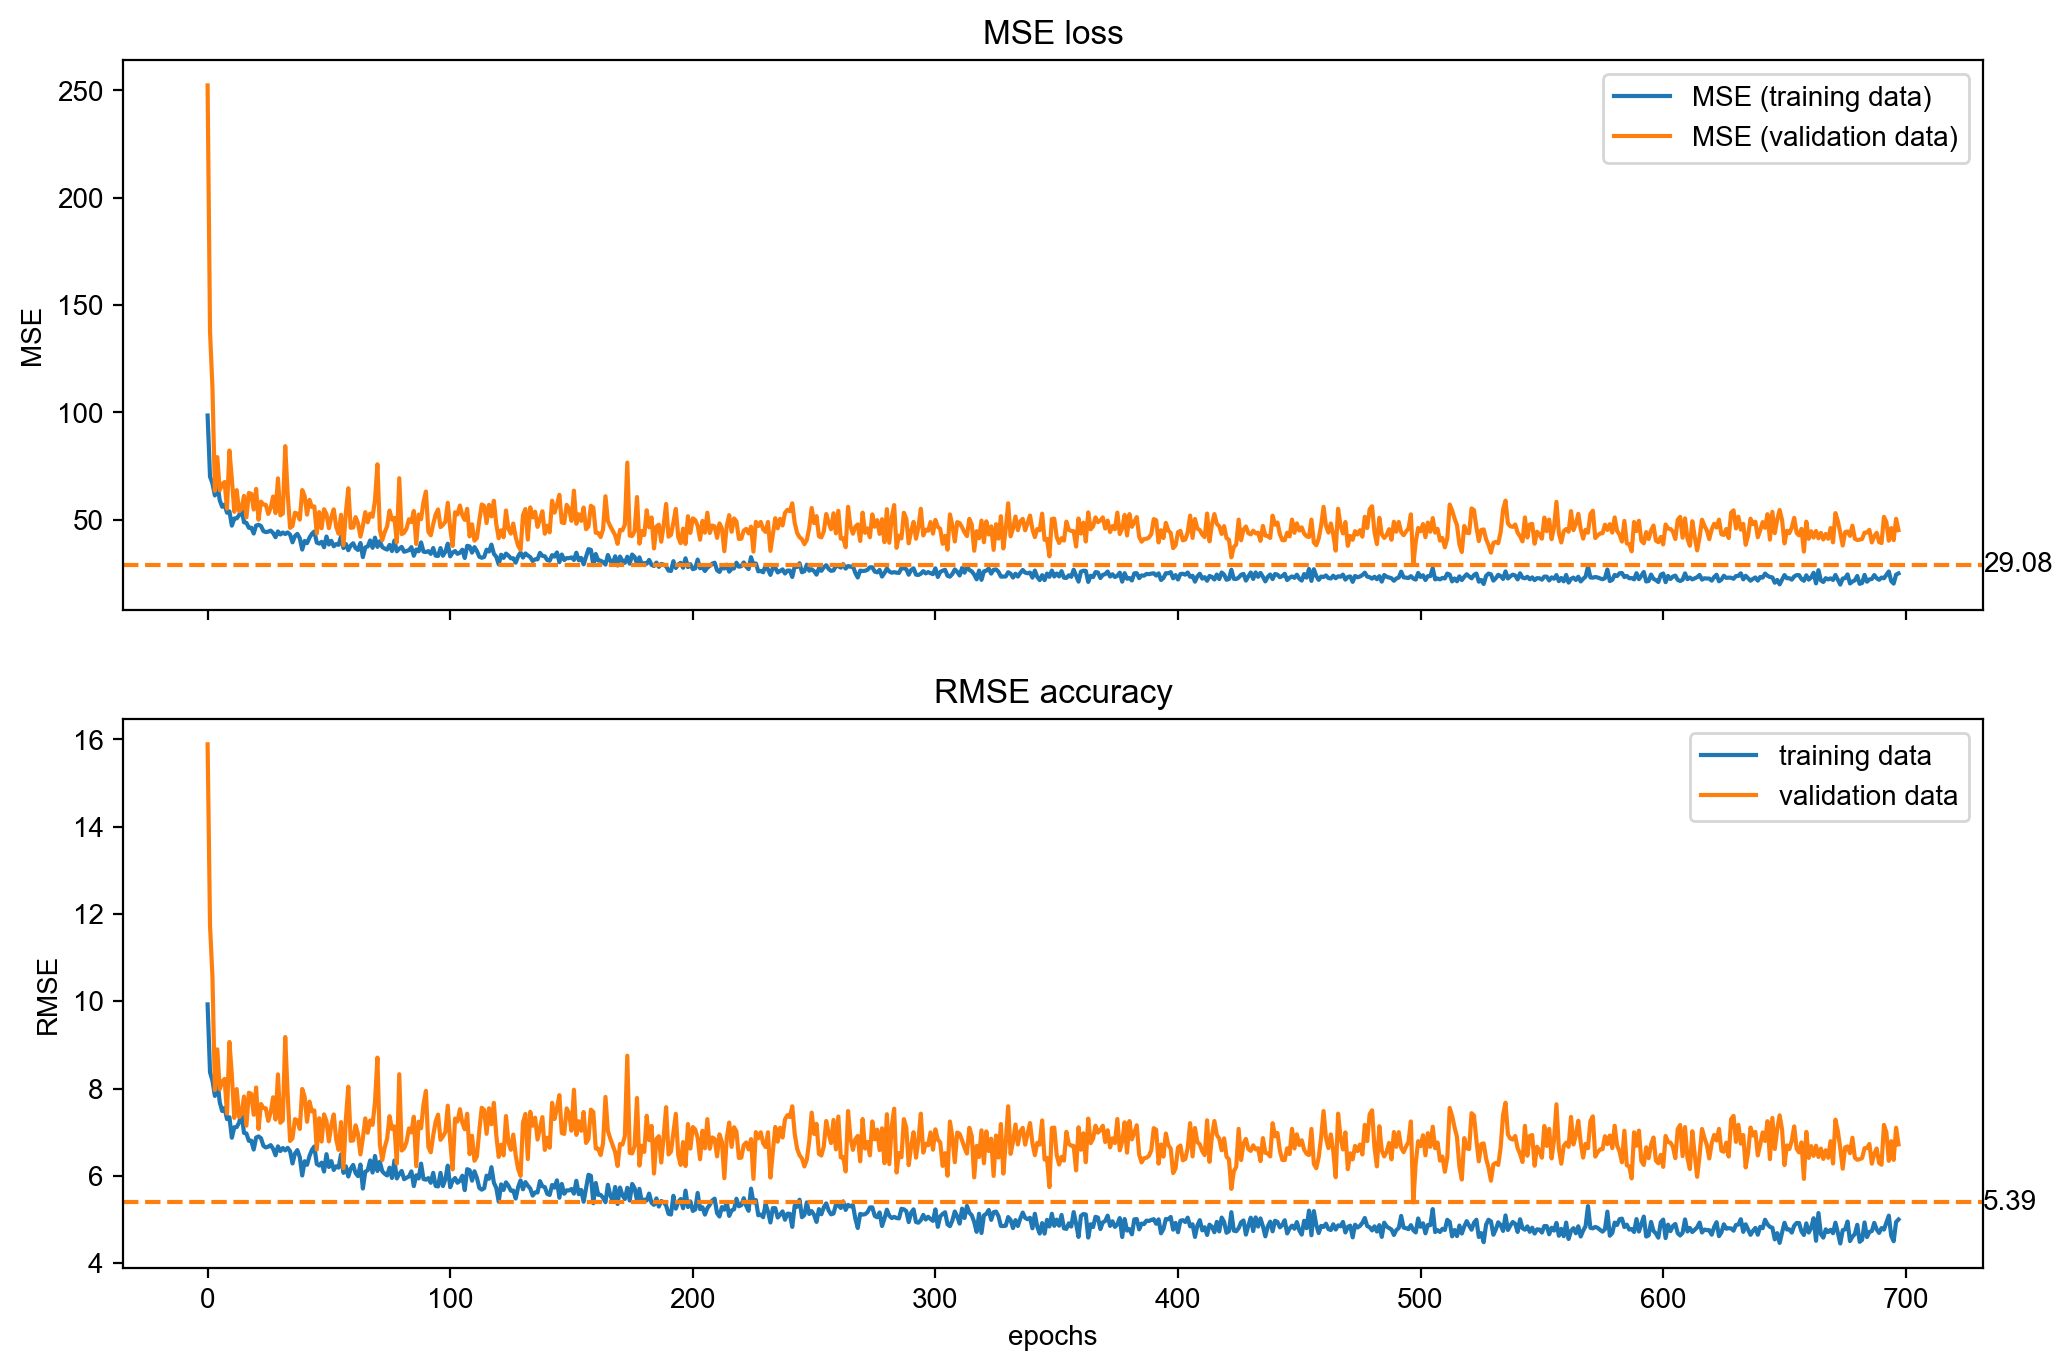

In [34]:
plot_loss(history)

### Load best model and explore best model (InceptionTime 3)

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [24]:
best_filename = 'Inception_classifier03'
best_file = os.path.join(PATH_MODELS, best_filename)

best_model_path = best_file + '.hdf5'

In [25]:
model = tf.keras.models.load_model(best_model_path)

In [26]:
def get_targets_and_predictions(model, X_test):
    predicted_values = model.predict(X_test)
        
    return np.array(predicted_values).flatten()

In [37]:
X_test, true_values = test_generator.get_all_data()

predicted_values = get_targets_and_predictions(model, X_test)
df = pd.DataFrame(list(zip(true_values, predicted_values)), columns =['true_values', 'predicted_values']) 

In [38]:
evaluate_model(model)

6/6 [==============================] - 1s 101ms/step - loss: 38.6733 - root_mean_squared_error: 6.2188 - mean_absolute_error: 5.1010


In [85]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(true_values, predicted_values)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.702


In [67]:
from scipy.stats import gaussian_kde

def age_pred_age_scatterplot(df):
    %matplotlib inline
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df['true_values'], df['predicted_values'])

    ax.set_xlim(4, 48)
    ax.set_ylim(4, 48)

    ax.set_xticks(np.arange(5, 48, 2.0))
    ax.set_yticks(np.arange(5, 48, 2.0))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=(1,0.2,0,0.3))
    ax.grid()
    ax.set_axisbelow(True)

    ax.set_xlabel('Chronological age (months)')
    ax.set_ylabel('EEG-based age (months)')
    ax.set_title('Chronological age vs. predicted EEG-based age')

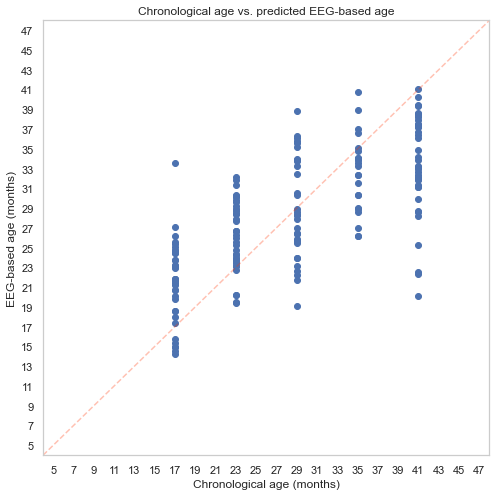

In [68]:
age_pred_age_scatterplot(df)

In [69]:
from scipy import stats

def describe_data(df):
    print("==== True values, descriptive statistics")
    print(stats.describe(df['true_values']))
    print()
    print("==== Predicted values, descriptive statistics")
    print(stats.describe(df['predicted_values']))

In [70]:
describe_data(df)

==== True values, descriptive statistics
DescribeResult(nobs=169, minmax=(17.0, 41.0), mean=28.609467455621303, variance=78.0608622147084, skewness=0.13495654068977028, kurtosis=-1.361576631829297)

==== Predicted values, descriptive statistics
DescribeResult(nobs=169, minmax=(14.209391593933105, 41.09086227416992), mean=28.303052823219073, variance=39.07649296879119, skewness=-0.028604310256869023, kurtosis=-0.6957020664585256)


In [71]:
from scipy import stats

def plot_distribution_all(df):
    %matplotlib inline
    
    fig, ax = plt.subplots(3, 2, figsize=(15,17))
    ax=ax.flatten()

    ax[0].hist(df.loc[df['true_values'] == 17]['predicted_values'], density=True, bins=20, label="Predictions")
    min_y, max_y = ax[0].get_ylim()
    ax[0].vlines(17, min_y, max_y, colors=(0,0,0,0.5), linestyles='dashed', label="True age")
    min_x, max_x = ax[0].get_xlim()
    ax[0].set_xlim(min_x, max_x)
    kde_xs = np.linspace(min_x, max_x, 300)
    kde = stats.gaussian_kde(df.loc[df['true_values'] == 17]['predicted_values'])
    ax[0].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax[0].legend(loc="upper left")
    ax[0].set_xlabel('EEG-based age prediction (months)')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title(f'Frequency histogram, chronological age = 17 months')
    
    ax[1].hist(df.loc[df['true_values'] == 23]['predicted_values'], density=True, bins=20, label="Predictions")
    min_y, max_y = ax[1].get_ylim()
    ax[1].vlines(23, min_y, max_y, colors=(0,0,0,0.5), linestyles='dashed', label="True age")
    min_x, max_x = ax[1].get_xlim()
    ax[1].set_xlim(min_x, max_x)
    kde_xs = np.linspace(min_x, max_x, 300)
    kde = stats.gaussian_kde(df.loc[df['true_values'] == 23]['predicted_values'])
    ax[1].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax[1].legend(loc="upper left")
    ax[1].set_xlabel('EEG-based age prediction (months)')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'Frequency histogram, chronological age = 23 months')
    
    ax[2].hist(df.loc[df['true_values'] == 29]['predicted_values'], density=True, bins=20, label="Predictions")
    min_y, max_y = ax[2].get_ylim()
    ax[2].vlines(29, min_y, max_y, colors=(0,0,0,0.5), linestyles='dashed', label="True age")
    min_x, max_x = ax[2].get_xlim()
    ax[2].set_xlim(min_x, max_x)
    kde_xs = np.linspace(min_x, max_x, 300)
    kde = stats.gaussian_kde(df.loc[df['true_values'] == 29]['predicted_values'])
    ax[2].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax[2].legend(loc="upper left")
    ax[2].set_xlabel('EEG-based age prediction (months)')
    ax[2].set_ylabel('Frequency')
    ax[2].set_title(f'Frequency histogram, chronological age = 29 months')
    
    ax[3].hist(df.loc[df['true_values'] == 35]['predicted_values'], density=True, bins=20, label="Predictions")
    min_y, max_y = ax[3].get_ylim()
    ax[3].vlines(35, min_y, max_y, colors=(0,0,0,0.5), linestyles='dashed', label="True age")
    min_x, max_x = ax[3].get_xlim()
    ax[3].set_xlim(min_x, max_x)
    kde_xs = np.linspace(min_x, max_x, 300)
    kde = stats.gaussian_kde(df.loc[df['true_values'] == 35]['predicted_values'])
    ax[3].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax[3].legend(loc="upper left")
    ax[3].set_xlabel('EEG-based age prediction (months)')
    ax[3].set_ylabel('Frequency')
    ax[3].set_title(f'Frequency histogram, chronological age = 35 months')
    
    ax[4].hist(df.loc[df['true_values'] == 41]['predicted_values'], density=True, bins=20, label="Predictions")
    min_y, max_y = ax[4].get_ylim()
    ax[4].vlines(41, min_y, max_y, colors=(0,0,0,0.5), linestyles='dashed', label="True age")
    min_x, max_x = ax[4].get_xlim()
    ax[4].set_xlim(min_x, max_x)
    kde_xs = np.linspace(min_x, max_x, 300)
    kde = stats.gaussian_kde(df.loc[df['true_values'] == 41]['predicted_values'])
    ax[4].plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax[4].legend(loc="upper left")
    ax[4].set_xlabel('EEG-based age prediction (months)')
    ax[4].set_ylabel('Frequency')
    ax[4].set_title(f'Frequency histogram, chronological age = 41 months')
    
    ax[5].remove()

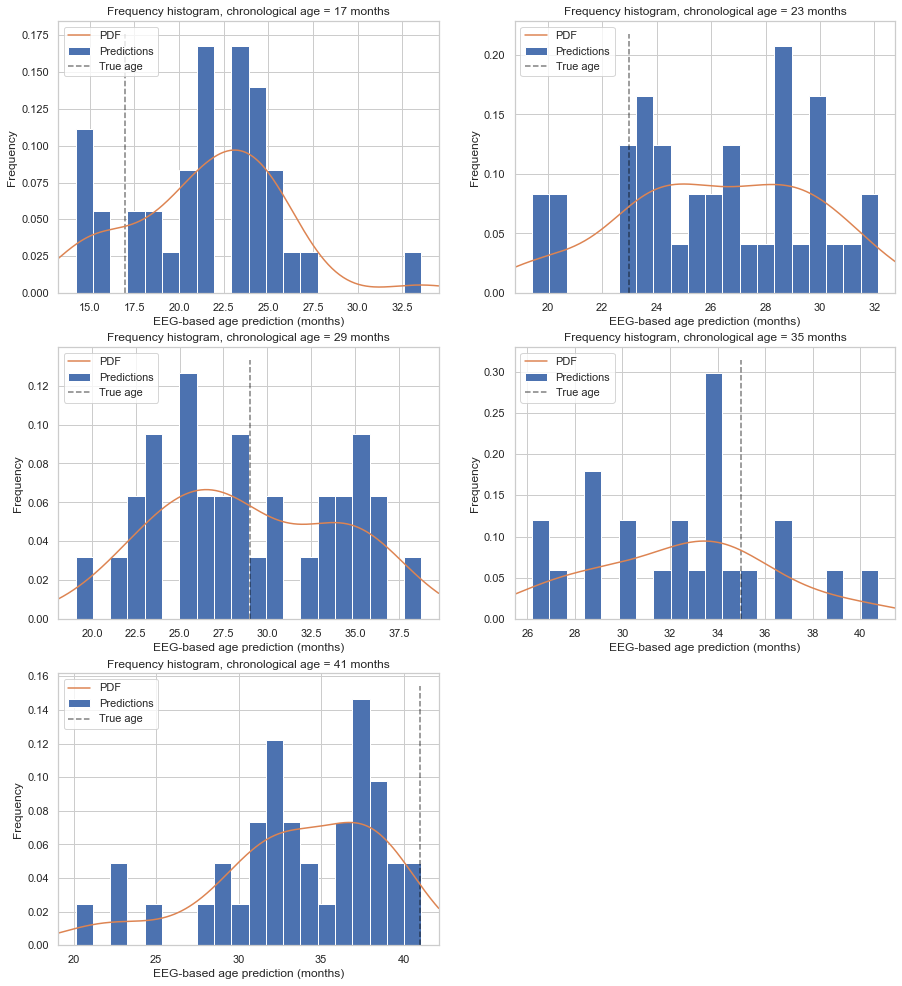

In [72]:
plot_distribution_all(df)

In [73]:
def plot_distributions_combined(df):
    %matplotlib inline
    
    bins = 20
    
    fig, ax = plt.subplots(figsize=(12,6))        
    ax.hist([df.loc[df['true_values'] == 17]['predicted_values'], 
             df.loc[df['true_values'] == 23]['predicted_values'], 
             df.loc[df['true_values'] == 29]['predicted_values'], 
             df.loc[df['true_values'] == 35]['predicted_values'],
             df.loc[df['true_values'] == 41]['predicted_values']], density=True, alpha=0.5, bins=bins, 
            label=["Age = 17", 
                   "Age = 23", 
                   "Age = 29", 
                   "Age = 35",
                   "Age = 41"])

    ax.set_xlabel('EEG-based age prediction (months)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Frequency histogram for all ages')
    
    ax.legend(loc="upper left")

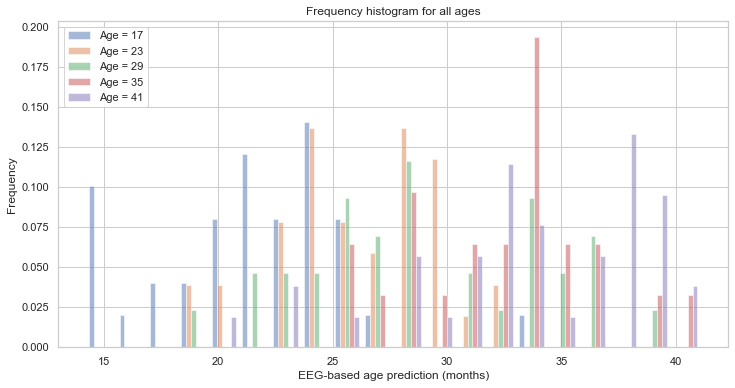

In [74]:
plot_distributions_combined(df)

Text(0.5, 1.0, 'Chronological age vs. predicted EEG-based age')

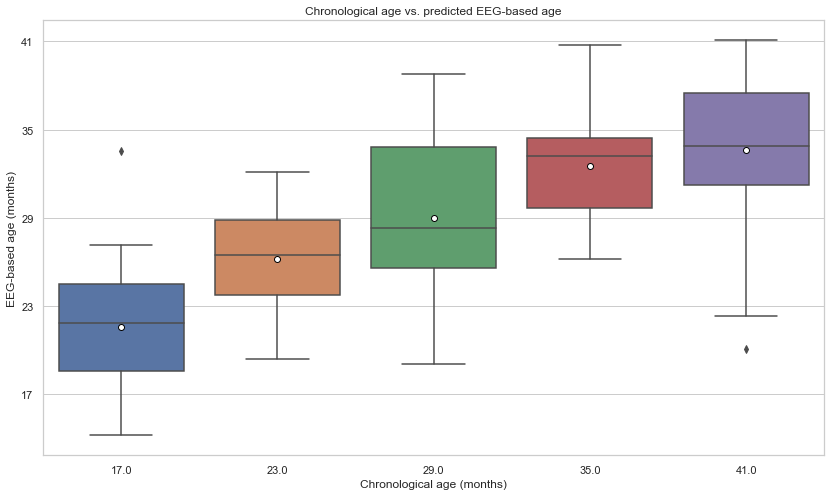

In [75]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_yticks(np.arange(11, 48, 6.0))
sns.boxplot(ax=ax, x="true_values", y="predicted_values", data=df, showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"6"})
ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')

Text(0.5, 1.0, 'Chronological age vs. predicted EEG-based age')

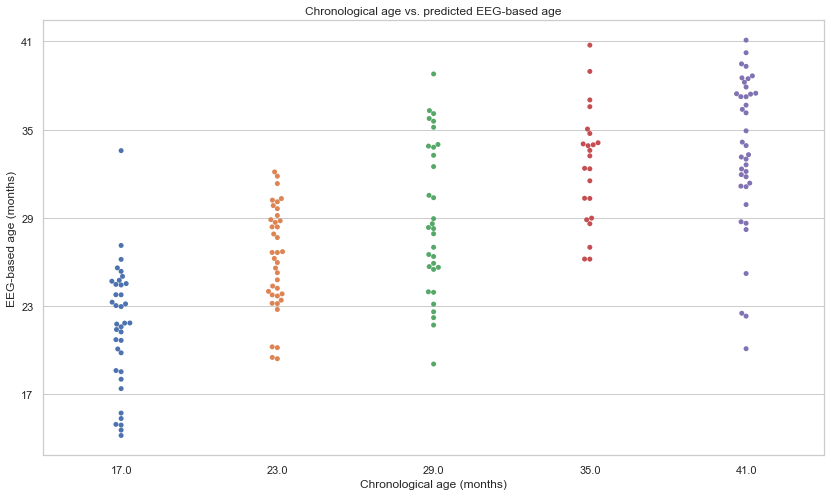

In [76]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_yticks(np.arange(11, 48, 6.0))
sns.swarmplot(ax=ax, x="true_values", y="predicted_values", data=df)
ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')

Text(0.5, 1.0, 'Chronological age vs. predicted EEG-based age')

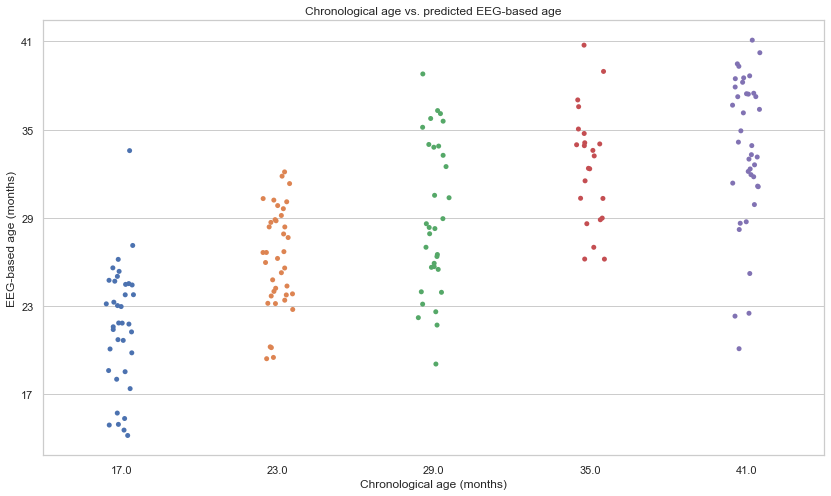

In [77]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_yticks(np.arange(11, 48, 6.0))
sns.stripplot(ax=ax, x="true_values", y="predicted_values", data=df)
ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')

Text(0.5, 1.0, 'Chronological age vs. predicted EEG-based age')

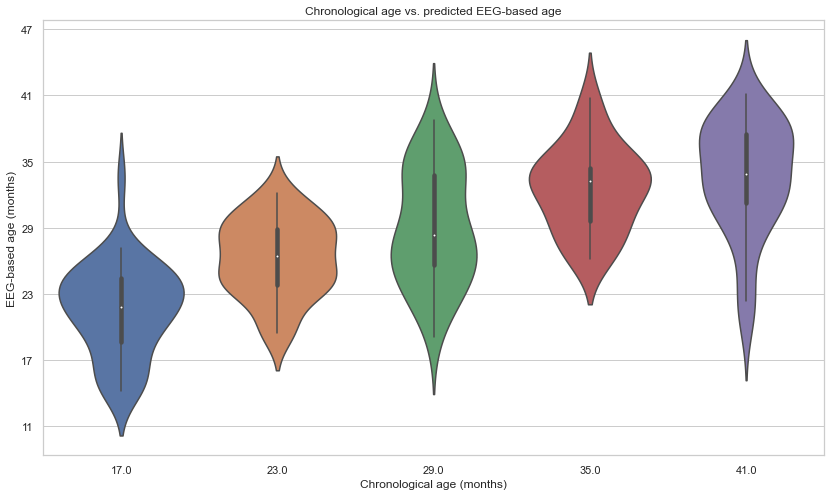

In [78]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_yticks(np.arange(11, 48, 6.0))
sns.violinplot(ax=ax, x="true_values", y="predicted_values", data=df)
ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')

Text(0.5, 1.0, 'Chronological age vs. predicted EEG-based age')

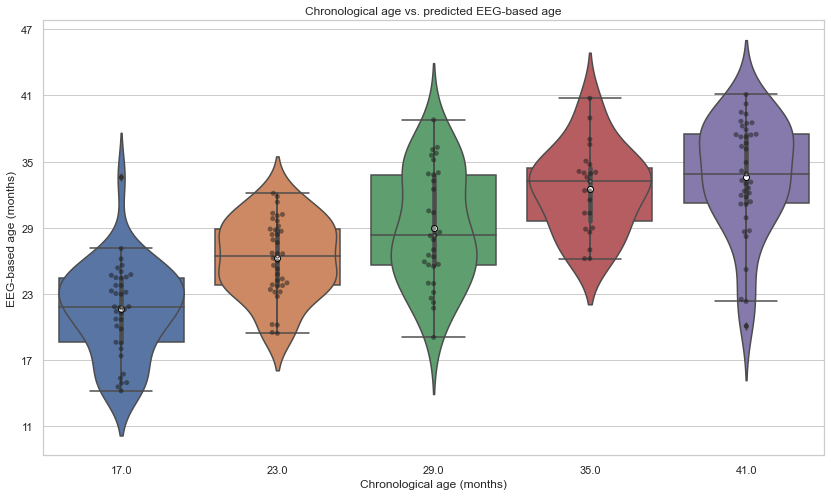

In [79]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_yticks(np.arange(11, 48, 6.0))
sns.violinplot(ax=ax, x="true_values", y="predicted_values", data=df)
sns.swarmplot(ax=ax, x="true_values", y="predicted_values", data=df, color='k', alpha=0.5)
sns.boxplot(ax=ax, x="true_values", y="predicted_values", data=df, showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"6"})
ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('EEG-based age (months)')
ax.set_title('Chronological age vs. predicted EEG-based age')